# Train bidiractional LSTM RNN Functions

All functions and run example

In [1]:
import pandas as pd
import numpy as np
import time
import random
from string import ascii_letters, ascii_lowercase

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from scipy.stats import mode

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
! pwd

/Users/michal/diploma/Hi-ChIP-ML/models/NN_models


# Functions

In [3]:
def main_analysis(data_path,  
                  cell_line, 
                  bioset, 
                  num_experements, 
                  sequenc_len_list = [6], 
                  num_lstm_units = 6, 
                  batch_size = 160, 
                  num_folds = 4,
                  min_delta = 0.001,
                  patience = 5,
                  do_only_1_feature_exps = True, 
                  do_drop_1_feature_exps = True,
                  do_all_together = False, 
                  use_chr_onehotenc=True,
                  use_coord_scale=True, 
                  verbose=True,
                 ):
    data_original = load_data(data_path, index_col=0, verbose=verbose)
    data = proccess_data(data_original, cell_line, bioset, 
                         use_chr_onehotenc=use_chr_onehotenc,
                         use_coord_scale=use_coord_scale)

    target_original, target = get_target(target_path, cell_line, verbose=verbose)
    # data_scaled_clean, target_clean, empty_chr_names, num_empty_bins = data, target, [], [] # cleanDataTarget(data, target)
    target_clean = target['gamma']  # target_clean[['gamma']]
    data_scaled_clean, target_clean = data, target_clean

    if verbose:
        print('data_original.head =', data_original.head())
        print('proccessed data.head =', data.head())
        print('proccessed data.shape =', data.shape)

        print('target_original.head =', target_original.head())
        print('proccessed target.shape =', target.shape)
        print('data_scaled_clean.shape, target_clean.shape =', 
              data_scaled_clean.shape, target_clean.shape)

    # Features correlation matrix
    d = data_original.copy()
    d['target'] = target_original.gamma
    corrs = correlationHeatmap(d, title="Features correlation - Original - c.l. " + cell_line)

    d = data_scaled_clean.copy()
    d['target'] = target_clean # gamma
    corrs = correlationHeatmap(d, title="Features correlation - scaled - c.l. " + cell_line)

    eval_models_df = pd.DataFrame(columns=["exper_num", "sequenc_len", "num_lstm_units", "n_epochs",
                                   "weighted_mse_test", "weighted_mse_train", "weighted_mse_val",
                                   "weighted_mse_test_const",
                                   "batch_size", "duration",
                                   "missing_feature"]) # , 'feature']) 

    eval_models_df_1, eval_models_df_drop, \
        feature_score_1, feature_score_drop = train_1_and_drop(data_scaled_clean=data_scaled_clean,
                                                         target_clean=target_clean,
                                                         eval_models_df=eval_models_df, 
                                                         sequenc_len_list =  sequenc_len_list,
                                                         num_lstm_units = num_lstm_units,
                                                         batch_size=batch_size,
                                                         n_epochs_max = n_epochs_max, 
                                                         num_experements = num_experements,
                                                         num_folds = num_folds,
                                                         min_delta = min_delta,
                                                         patience = patience,
                                                         file_path = file_path, 
                                                         random_state = random_state,
                                                         do_only_1_feature_exps = do_only_1_feature_exps,
                                                         do_drop_1_feature_exps = do_drop_1_feature_exps)

    mean_test_together, std_test_together = None, None
    if do_all_together:
        # print('\n-----\n use all FEATURES -- ' + len(data_scaled_clean) + '\n-----\n')
        # Use all features
        eval_models_df_together = pd.DataFrame(columns=["exper_num", "sequenc_len", "num_lstm_units", "n_epochs",
                                   "weighted_mse_test", "weighted_mse_train", "weighted_mse_val",
                                   "weighted_mse_test_const",
                                   "batch_size", "duration",
                                   "missing_feature"]) 
        get_full_model_experiments(
            data_scaled_clean, target_clean, eval_models_df_together, 
            sequenc_len_list =  sequenc_len_list ,#
            num_lstm_units = num_lstm_units,
            batch_size=batch_size,
            n_epochs_max = n_epochs_max, 
            num_experements = num_experements,
            num_folds = num_folds,
            min_delta = min_delta,
            patience = patience,
            file_path = file_path, 
            missing_feature = -1)

        mean_test_together = eval_models_df_together[eval_models_df_together['exper_num'] == 'mean']['weighted_mse_test']
        std_test_together = eval_models_df_together[eval_models_df_together['exper_num'] == 'std']['weighted_mse_test']

    return eval_models_df_1, eval_models_df_drop, eval_models_df_together, \
             mean_test_together, std_test_together, feature_score_1, feature_score_drop, \
            data_scaled_clean, target_clean, 


In [4]:
def plotData(data, ncols, nrows, method = 'hist', is_sharex=True, share_axes='y', bins=50, 
             plt_title='Histograms of data features', figsize=(20, 18), 
             cmin=None, cmax=None, min_val=None, max_val=None,
             verbose=False, fig=None, axes=None, alpha=0.6):
    if (min_val is None or  max_val is None):
        min_val, max_val = min(np.min(data)) - 3, max(np.max(data))
    if (fig is None or axes is None):
        if (share_axes == 'xy'):
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, 
                                     sharex='all', sharey='all')
        else:
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize,
                                     sharex=is_sharex)
    fig.set_figheight(24)
    i = 0
    for row in range(nrows):
        if i >= len(data.columns):
                break      
        for col in range(ncols):
            if i >= len(data.columns):
                break
            axes[row][col].set_title(data.columns[i], fontsize=22)       
            if method == "hist":
                if (cmin is not None and  cmax is not None):
                    axes[row][col].hist(data[[data.columns[i]]].values, bins=bins, range=(cmin, cmax), alpha=0.6, label=plt_title) # cmin=cmin, cmax=cmax)
                else:
                    axes[row][col].hist(data[[data.columns[i]]].values, bins=bins, alpha=alpha, label=plt_title) # cmin=cmin, cmax=cmax)
                if is_sharex or share_axes == 'xy':
                    axes[row][col].set_xlim(min_val, max_val)
                
            elif method == "original":
                axes[row][col].scatter(np.arange(0, data.shape[0]), data[[data.columns[i]]].values,)
                if is_sharex or share_axes == 'xy':
                    axes[row][col].set_ylim(min_val, max_val)
                    
            if verbose:
                print(i)   
                print(data[[data.columns[i]]].mean(), data[[data.columns[i]]].std(), data[[data.columns[i]]].min(), data[[data.columns[i]]].max())
            i += 1
    plt.suptitle(plt_title, fontsize=30, y=0.92)
    # return fig, axes   


def correlationHeatmap(data, title="Features corrselation - scaled", figsize=(11, 9)):
    sns.set(style="white")
    # Generate a large random dataset
    rs = np.random.RandomState(33)
    # Compute the corrselation matrix
    corrs = data.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # # Draw the heatmap with the mask and corrsect aspect ratio
    # sns.heatmap(corrs, mask=mask, cmap=cmap, vmax=.3, center=0,
    #             square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.heatmap(corrs, cmap=cmap, square=True, linewidths=.5, 
                cbar_kws={"shrink": .5})
    ax.set_title(title)
    plt.show()
    g = sns.clustermap(corrs,     
                       cmap = sns.diverging_palette(220, 10, as_cmap=True) ) 
    plt.title("Features corrselation - scaled sorted - c.l." + cell_line)
    plt.show()
    print(corrs['target'], corrs.index[np.argsort(corrs['target'])])
    return(corrs)


def OneHotEncode(data_feature, feature_preffix="", verbose=True):
    # Integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(data_feature.values)
    # Binary encode
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    onehot_df = pd.DataFrame(onehot_encoded, 
                             columns = feature_preffix + label_encoder.classes_, 
                             index = data_feature.index )
    if verbose: 
        print("values: ", data_feature.values)
        print("integer values: ", integer_encoded.shape, integer_encoded)
        print("one-hot values: ", onehot_encoded.shape, onehot_encoded)
        ## Invert first example
        # inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
        # print("inversed of ", data_feature[0], " is ", inverted)
    return onehot_df, onehot_encoder, label_encoder


def load_data(data_path, index_col=0, verbose=True):
    data = pd.read_csv(data_path, index_col=index_col)
    if verbose:
        print('data.shape = ', data.shape)
        # print(data.head())
        print('column names =', data.columns.values)
    return(data)


def proccess_data(data_original, 
                  cell_line, 
                  bioset, 
                  do_scaling=True,
                  use_chr_onehotenc=True, 
                  use_coord_scale=True,
                  do_plots=True,
                  coord_scale_const=10000000,
                  verbose=True,
                 ):
    ''' Proccess data
         - Drop 'chrN', 'start_coord'
         - Use Biological Dataset if defined
         - Use 1 Cell Line if cell_line is not 'all'
         - Scaling for the non-binary data (specified in the list of features) if do_scaling=True
         - One Hot Encoding of the Chromasome Number feature 'ChrN' if use_chr_onehotenc=True
         - Start coordinate number of the bin scale: devide by const
         - Plot original and proccessed features if do_plots=Trues
         
    '''
    data = data_original.copy()
    
    if bioset:
        data = data[bioset]
        print("Using features bioset:", bioset)
    
    if cell_line != 'all':
        data = data[data[cell_line] == 1]
        data = data.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
        print("Using cell line:", cell_line)

    if do_scaling:
        features_to_scale = data.columns[[f not in ['chrN', 
                                                    'start_coord', 
                                                    'is_s2', 'is_kc', 'is_bg'] for f in data.columns]]
        data[features_to_scale] = preprocessing.scale(data[features_to_scale],
                                          axis=0, with_mean=True, with_std=True)
        print("Scaling of the features:", features_to_scale)
    
    if use_chr_onehotenc:
        onehot_df_chr, onehot_encoder, label_encoder = OneHotEncode(data['chrN'], 
                                                            feature_preffix="", 
                                                            verbose=False)
        data = pd.concat([onehot_df_chr, data.drop(['chrN'], axis=1)], axis=1)
        print("Using chromosome One Hot Encoding:", np.unique(data_original['chrN']))
    else:  
        # drop chrN column - not to work with strings
        data = data.drop(['chrN'], axis=1)
        
        
    if use_coord_scale:
        data[['start_coord']] = data[['start_coord']] / coord_scale_const
        
    if verbose:
        # print('proccessed data.head =', data.head())
        print('proccessed data.shape =', data.shape)
    
    # Plot features 
    if do_plots:
        ncols = 3
        nrows = data_original.shape[1] // ncols + 1
        plotData(data_original[data_original.columns[data_original.columns != 'chrN']],
                 ncols, nrows, bins=30, method = 'original', figsize=(20, 10),
                 is_sharex=False, plt_title='Original data features (ChIP-Seq) - c.l.' + cell_line)
        plotData(data_original[data_original.columns[data_original.columns != 'chrN']], ncols, nrows, 
                 bins=30, method = 'hist', is_sharex = False, 
                 plt_title='Histograms of original data features - c.l. ' + cell_line)


        nrows = data.shape[1] // ncols + 1
        plotData(data, ncols, nrows, bins=30, method = 'original', figsize=(20, 10),
                 is_sharex=False, plt_title='Proccessed data features (ChIP-Seq) - c.l. ' + cell_line)
        plotData(data, ncols, nrows, bins=30, method = 'hist', is_sharex = True, 
                 plt_title='Histograms of proccesed data features - c.l. ' + cell_line)
    return data

def load_target(target_path):
    target = pd.read_csv(target_path, index_col=0)
    if cell_line:
        target = target[target[cell_line] == 1]
        target = target.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
    print('target.shape =', target.shape)
    print('target.column =', target.columns)
    target.head()


def get_target(target_path, cell_line, verbose=True):
    target_original = pd.read_csv(target_path, index_col=0)

    if cell_line != 'all':
        target = target_original[target_original[cell_line] == 1]
        target = target.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
    else:
        target = target_original.copy()  

    if verbose:
        print('original target.shape =', target_original.shape)
        print('target.columns =', target_original.columns)
        target_original.head()

        print('target.shape =', target.shape)
        print('target.column =', target.columns)
        target.head()
        
    return target_original, target
    


def findEmptyChr(data, verbose=True):
    '''Find empty chromosoms.'''
    chr_names = np.unique(data['chrN'])
    empty_chr_names = []
    num_empty_bins = 0

    for chr_i in chr_names:
        gamma_sum = sum(data[data.chrN == chr_i].gamma)
        if (verbose):
            print("---\nChr name =", chr_i)
            print("Sum of gamma values =", gamma_sum)
            print("Number of bins =", len(data[data.chrN == chr_i]))

        if (gamma_sum == 0):
            empty_chr_names.append(chr_i)
            num_empty_bins += len(data[data.chrN == chr_i])
    print("===")
    print("Total num of chr =", len(chr_names), "\n", chr_names)
    print("Num of empty chr =", len(empty_chr_names), "\n", empty_chr_names)
    print("Total num of chr =", len(data.index))
    print("Num of empty bins =", num_empty_bins)
    
    return(empty_chr_names, num_empty_bins)


def cleanDataTarget(data, target, ncols = 3, do_plots=True, verbose=True):
    ''' Remove empty (zeros) chromosomes from data and target '''
    
    empty_chr_names, num_empty_bins = findEmptyChr(target, verbose)
    
    if num_empty_bins > 0:
        data_scaled_clean = data[~target.chrN.isin(empty_chr_names)]
        target_clean = target[~target.chrN.isin(empty_chr_names)]
    
    # Plot features 
    if do_plots:
        nrows = data_scaled_clean.shape[1] // ncols 
        plotData(data_scaled_clean, ncols, nrows, bins=30, method = 'original', figsize=(20, 10),
                 is_sharex=False, plt_title='Clean proccessed data features (ChIP-Seq) - c.l. ' + cell_line)
        plotData(data_scaled_clean, ncols, nrows, bins=30, method = 'hist', is_sharex = True, 
                 plt_title='Histograms of clean proccessed data features - c.l. ' + cell_line)
        
    return (data_scaled_clean, target_clean, empty_chr_names, num_empty_bins)

# ====================================================================== 
# FULL Experiment FUNCTIONS

In [5]:
def split_data_middle_target(data, target, sequenc_len = 6, 
                             overlop_len = 1, random_state=16, 
                             test_size=0.3, val_size=0.3, 
                             shuffle=True):
    '''
    для последовательности мы предсказываем значение целой переменной "центрального" элемента.
    по формуле: int(seq_lenght / 2 ) ( - 1 - т.к. индексация с нуля )
    округление вниз до ближайшего целого
    =>
    То есть в последовательности длины 7, мы каждый раз предсказываем значение 3-го элемента.
    в последовательности длины 6, мы каждый раз предсказываем значение 3-го элемента.
    в последовательности длины 5, мы каждый раз предсказываем значение 2-го элемента.
    в последовательности длины 9, мы каждый раз предсказываем значение 4-го элемента.
    =>
    if random_state is None - shuffel the splitting
    '''
    mid_indx = max(int(sequenc_len/2 + 0.5)-1, 0)
    
    sequenc_data = []
    sequenc_targets = []

    for obj_i in range(len(data)  - sequenc_len + 1):
        sequenc_data.append(data[obj_i: obj_i + sequenc_len]) 
        sequenc_targets.append(target[obj_i + mid_indx] )

    sequenc_data = np.array(sequenc_data)
    sequenc_targets = np.array(sequenc_targets)
    X, y = sequenc_data, sequenc_targets 

    if (random_state is None):
        # if random_state is None - shuffel the splitting
        random_state = random.randint(0, 10000)
    
    # split and mix learning samples
    X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=test_size, 
                                                        random_state=random_state, shuffle=shuffle)
    
    X_test, X_val, y_test, y_val = train_test_split(X_test[:], y_test[:], test_size=val_size,
                                                    random_state=random_state, shuffle=shuffle)
    
    print('X_train.shape, X_test.shape, y_train.shape, y_test.shape =',
          X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    return X_train, X_test, X_val, y_train, y_test, y_val, sequenc_data, sequenc_targets

In [6]:
def weighted_mse(y_true, y_pred, const_scale=11):   
    diff = ((y_true - y_pred)**2) * (const_scale - y_true) / const_scale # / 11
    return  K.mean(diff)  # K.mean(K.sum(diff, axis = -1)) # 

def mae_cout(y_true, y_pred):
    y_pred = np.hstack(y_pred)
    
    return np.mean(np.abs(y_true - y_pred))

def rmse_cout(y_true, y_pred):
    y_pred = np.hstack(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def weighted_mse_cout(y_true, y_pred, const_scale=11):
    y_pred = np.hstack(y_pred)
    return np.mean(((y_true - y_pred)**2) * (const_scale - y_true)) / const_scale  # / 11 ) 

def count_errors_by_target_grid(y_true, y_pred, const_scale=11):
    if (len(y_true) != len(y_pred)):
         return "ERROR of prediction and true size"
    
    mae_errors_by_grid = np.array([0]*const_scale, dtype=float)    
    rmse_errors_by_grid = np.array([0]*const_scale, dtype=float)    
    weig_mse_errors_by_grid = np.array([0]*const_scale, dtype=float)
    objs_by_grid = np.array([0]*const_scale, dtype=float)

    for i in range(len(y_true)):  # K.int_shape(y_true)):
        mae_errors_by_grid[int(y_true[i])] += np.abs(y_true[i] - y_pred[i]) # (y_true[i] - y_pred[i])**2 # mse
        rmse_errors_by_grid[int(y_true[i])] += (y_true[i] - y_pred[i])**2 # mse
        weig_mse_errors_by_grid[int(y_true[i])] += (y_true[i] - y_pred[i])**2 * (const_scale - y_true[i]) 
        objs_by_grid[int(y_true[i])] += 1
      
    mae_errors_by_grid /= objs_by_grid
    rmse_errors_by_grid /= objs_by_grid
    rmse_errors_by_grid = np.sqrt(rmse_errors_by_grid)
    weig_mse_errors_by_grid /= objs_by_grid
    
    return mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, objs_by_grid


def plot_train_res(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss - weighted mse')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # summarize history for MSE
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model mean squared error')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def count_plot_test_errors(model, x_test, y_test):
    y_pred_test = model.predict(x_test)
    print("test sizes = ", len(y_test), len(x_test), len(y_pred_test))

    mae_errors_by_grid, rmse_errors_by_grid, \
        weig_mse_errors_by_grid, objs_by_grid = count_errors_by_target_grid(y_test, y_pred_test)
    return mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, objs_by_grid

# Add colums to 
def add_columns(new_col_names, df):
    for col_name in new_col_names:
        df[col_name] = -1 + np.zeros_like(eval_models_df["model"])
    return df

do_add_columns = False
if do_add_columns:
    new_col_names = ["mae_errors_by_grid_const", "rmse_errors_by_grid_const", "weig_mse_errors_by_grid_const"]
    eval_models_df = add_columns(new_col_names, df=eval_models_df)

In [7]:
def biLSTM_Train_Test(x_train, x_test, x_val, 
                      y_train, y_test, y_val,
                      sequenc_data, sequenc_targets,
                      data, target, 
                      sequenc_len = 6,
                      num_lstm_units = 64,
                      num_epochs=3,
                      BATCH_SIZE = 32,
                      num_features = 5,
                      min_delta = 0.000001,
                      dropout_rat = 0.3,
                      patience = 5,
                      opt_name = 'adam',
                      loss = weighted_mse,
                      metrics = [weighted_mse, 'mse'],
                      rnn_cell_type = "Bidirectional LSTM",
                      overlop_len = -1,
                      output_size = 1,
                      const_scale = 11,
                      random_state = 16):
    start_time = time.time()
    
    # BiLSTM RNN model:
    model = Sequential()
    model.add(Bidirectional(LSTM(num_lstm_units), input_shape=(sequenc_len, num_features)))
    model.add(Dropout(dropout_rat))
    model.add(Dense(output_size))
    
    # Define early stopping callback
    print('min_delta = ',min_delta,
         'patience = ', patience)
    early_stopping_monitor = EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience,
                                           verbose=1, mode='auto') # monitor='val_weighted_mse', mode='min', min_delta=0.000001)
    print('Train... with ')
    model.compile(opt_name, loss = loss, metrics = metrics)  # , mae_by_target_grid])
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=num_epochs,
                        validation_data=[x_val, y_val], 
                        callbacks=[early_stopping_monitor], 
                        verbose=False)
    # plot_train_res(history)
    n_epochs_past = len(history.history["loss"])
    
    # ------------ PREDICTION -------------------------------------------------------------
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)
    
    # -------------------------------------------------------------------------
    #          TEST PREDICTION Error
    # -------------------------------------------------------------------------
    weighted_mse_test = weighted_mse_cout(y_true = y_test, y_pred = y_pred_test, const_scale=const_scale)
    # -------------------------------------------------------------------------
    #          TRAIN PREDICTION Error
    # -------------------------------------------------------------------------
    weighted_mse_train = weighted_mse_cout(y_true = y_train, y_pred = y_pred_train, const_scale=const_scale)
    # -------------------------------------------------------------------------
    #          VAL PREDICTION Error
    # -------------------------------------------------------------------------
    weighted_mse_val = weighted_mse_cout(y_true = y_val, y_pred = y_pred_val, const_scale=const_scale)
    # -------------------------------------------------------------------------
    #          TEST Const Error
    # -------------------------------------------------------------------------
    const_pred = np.mean(y_train)
    const_pred_test = np.array([const_pred] * len(y_test))
    weighted_mse_test_const = weighted_mse_cout(y_true = y_test, 
                                                y_pred = const_pred_test, 
                                                const_scale=const_scale)

    # -- Duration --    
    end_time = time.time()
    duration = end_time - start_time 
    print("duration:", duration)
    
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return (model, 
            weighted_mse_test, weighted_mse_train, weighted_mse_val, 
            weighted_mse_test_const, duration, n_epochs_past)     

In [8]:
def get_full_model(data,
                   target,
                   eval_models_df,
                   sequenc_len_list=[6], 
                   num_lstm_units_list=[16], 
                   n_epochs_list= [63],  
                   missing_feature = -1,
                   file_path = "./eval_models_NN.csv", 
                   exper_num=0, 
                   batch_size = 160,
                   random_state = None,
                   num_folds = 4,
                   overlop_len = -1,
                   output_size = 1,
                   rnn_cell_type = "Bidirectional LSTM",
                   opt_name = 'adam',
                   dropout_rat = 0.3,
                   min_delta = 0.001,
                   patience = 5,
                  ):

    num_features = data.shape[-1]

    for sequenc_len_i in sequenc_len_list:
        for num_lstm_units in num_lstm_units_list: 
            for n_epochs in n_epochs_list:
                ''' make more n_epochs'''
                
                x_train, x_test, x_val, y_train, y_test, y_val, \
                    sequenc_data, sequenc_targets = split_data_middle_target(data.values, 
                                                                             target.values,
                                                                             sequenc_len = sequenc_len_i,
                                                                             overlop_len = overlop_len,
                                                                             random_state = random_state  # if random_state is None - shuffel the splitting
                                                                            )
                # K-folds:
                indexes = np.arange(0, sequenc_data.shape[0])
                kf = KFold(n_splits=num_folds, shuffle=True, random_state=16) # 3)
                k = 0
                for train_idxs, test_idxs in kf.split(indexes):
                    test_idxs, val_idxs = train_test_split(test_idxs, 
                                                           test_size=0.3, 
                                                           random_state=random_state)
                    np.random.shuffle(train_idxs)
                    x_train = sequenc_data[train_idxs]
                    x_test = sequenc_data[test_idxs]
                    x_val = sequenc_data[val_idxs]

                    y_train = sequenc_targets[train_idxs]
                    y_test = sequenc_targets[test_idxs]
                    y_val = sequenc_targets[val_idxs]
                    
                    print('x_val.shape =', x_val.shape)
                    print('y_val.shape =', y_val.shape)
                    print('x_train.shape =', x_train.shape)
                    print('y_train.shape =', y_train.shape)
                    
                    model, \
                        weighted_mse_test, weighted_mse_train, weighted_mse_val, weighted_mse_test_const, \
                        duration, n_epochs_past = biLSTM_Train_Test(
                                    x_train, x_test, x_val, y_train, y_test, y_val,
                        
                                    sequenc_data, sequenc_targets, 

                                    data, target, sequenc_len = sequenc_len_i,

                                    num_lstm_units = num_lstm_units, 

                                    num_epochs= n_epochs,

                                    BATCH_SIZE = batch_size,

                                    num_features = num_features,

                                    dropout_rat = dropout_rat,
                                    
                                    min_delta = min_delta,
                                    
                                    patience = patience,

                                    opt_name = opt_name,

                                    loss = weighted_mse,

                                    metrics = [weighted_mse, 'mse'],

                                    rnn_cell_type = rnn_cell_type,

                                    overlop_len = overlop_len,
                                    
                                    output_size = output_size,

                                    random_state = random_state)
                    
                    model_name = "bidirect LSTM input_window = " + str(sequenc_len_i)

                    model_rezs = exper_num, sequenc_len_i, num_lstm_units, n_epochs_past, \
                        weighted_mse_test, weighted_mse_train, weighted_mse_val, weighted_mse_test_const,\
                        batch_size, duration, \
                        missing_feature

                    new_indx = eval_models_df.shape[0]
                    eval_models_df.loc[new_indx] = model_rezs
                    print("TEST WMSE = ", weighted_mse_test)
                    K.clear_session()
            
    print("TEST MEAN WMSE = ", weighted_mse_test)
    return model, \
                    weighted_mse_test, weighted_mse_train, weighted_mse_val, weighted_mse_test_const, \
                    duration, n_epochs_past,  \
                    eval_models_df, missing_feature


def get_full_model_experiments(data, 
                               target,
                               eval_models_df,
                               sequenc_len_list =  6, # [1, 5, 6, 8 ]  
                               num_lstm_units = 64,
                               n_epochs_max = 46, #  2 
                               num_experements = 4,
                               file_path = "./eval_LSTM", # data_csv,
                               missing_feature = -1, 
                               batch_size = 160,
                               random_state = None,
                               min_delta = 0.001,
                               patience = 5,
                               num_folds = 4):
    for sequenc_len_i in sequenc_len_list: 
        for exper_num in range(num_experements):
            K.clear_session()
            model, \
                weighted_mse_test, weighted_mse_train, weighted_mse_val, weighted_mse_test_const, \
                duration, n_epochs_past,  \
                eval_models_df, \
                missing_feature = get_full_model(data, target,
                           eval_models_df, 
                           sequenc_len_list=[sequenc_len_i], num_lstm_units_list=[num_lstm_units],
                           n_epochs_list = [n_epochs_max],  
                           missing_feature = missing_feature,
                           file_path = file_path,
                           exper_num = exper_num, 
                           batch_size = batch_size,
                           random_state = random_state,
                           min_delta = min_delta,
                           patience = patience,
                           num_folds = num_folds)
        
        new_indx = eval_models_df.shape[0]
        eval_models_df.loc[new_indx] = eval_models_df[new_indx - num_experements  * num_folds : new_indx ].mean(axis=0)
        eval_models_df["exper_num"][new_indx] = "mean"

        new_indx = eval_models_df.shape[0]
        eval_models_df.loc[new_indx] = eval_models_df[new_indx - num_experements  * num_folds : new_indx ].std(axis=0)
        eval_models_df["exper_num"][new_indx] = "std"


# RUN FULL EXPERIMENTS

In [12]:
def get_means_featured(data, eval_models_df, num_experements, 
                       num_folds, data_csv, do_save=True):
    # Set feature names
    features = np.hstack([data.columns, ['all']])
    print(eval_models_df, num_experements * num_folds, 
          np.hstack([[f]* (num_experements * num_folds + 2) for f in features]) )
    
    eval_models_df['feature'] = np.hstack([features[int(feat_idxs)] for feat_idxs in eval_models_df['missing_feature'].values]) # features[feat_idxs]
    
    print('eval_models_df.shape, eval_models_df.columns =',
          eval_models_df.shape, eval_models_df.columns)

    print('data.columns.shape, data.columns', 
          data.columns.shape, data.columns)

    ## Means - from experiments
    eval_models_df_means = eval_models_df[eval_models_df['exper_num'] == 'mean']
    # eval_models_df[num_experements * num_folds::num_experements * num_folds+2]
   
    ### std
    eval_models_df_std =  eval_models_df[eval_models_df['exper_num'] == 'std']
    
    if do_save:
        print(data_csv)
        eval_models_df.to_csv("../experiments/eval" + data_csv)
        data.to_csv("../experiments/data" + data_csv)
        eval_models_df_means.to_csv("../experiments/exp_means" + data_csv)
        eval_models_df_std.to_csv("../experiments/exp_stds" + data_csv)
        
    return eval_models_df_means, eval_models_df_std, eval_models_df


def plot_exps_together(eval_models_df_means, eval_models_df_std):
    exps_grid = np.arange(eval_models_df_means.shape[0])
    fig, ax0 = plt.subplots(nrows=1, figsize=(16, 10))

    value_name = 'weighted_mse_test'  
    means = np.sort(eval_models_df_means[value_name])
    arg_sort_features = np.argsort(eval_models_df_means[value_name]).values
    
    stds = eval_models_df_std[value_name].values[arg_sort_features] # eval_models_df_std[value_name]
    ax0.errorbar(exps_grid, means, yerr=stds,  fmt='-o', label=value_name, color='g')
    
    # Test value using all data
    ax0.plot([means[0]]*means.shape[0], color='g' )

    value_name = 'weighted_mse_train'
    means = eval_models_df_means[value_name].values[arg_sort_features]
    stds = eval_models_df_std[value_name].values[arg_sort_features]
    ax0.errorbar(exps_grid, means, yerr=stds,  fmt='-o', label=value_name, color='b')
    # ax0.plot([means.values[-1]]*means.shape[0])

    value_name = 'weighted_mse_val' 
    means = eval_models_df_means[value_name].values[arg_sort_features]
    stds = eval_models_df_std[value_name].values[arg_sort_features]
    ax0.errorbar(exps_grid, means, yerr=stds,  fmt='-o', label=value_name, color='y', alpha=0.7)

    plt.legend(loc='lower left')

    features = eval_models_df_means['feature'].values  # list(data.columns.values) 
    features_sorted = features[arg_sort_features]
    [print(f) for f in features_sorted]
    print('num_features: ', len(features))

    ax0.set_title(str(len(features))+' features - USE 1 -' + str(num_experements) +\
                  ' experiments (means,std) - C.L.' + cell_line + '\ntest features order', 
                  fontsize=18)
    # Set number of ticks for x-axis
    ax0.set_xticks(np.arange(means.shape[0]))
    # Set ticks labels for x-axis
    ax0.set_xticklabels(features_sorted, rotation='vertical', fontsize=18)

    plt.show()
    return features_sorted

    
def plot_exps_drops(eval_models_df_means, 
                    eval_models_df_std,
                    value_name = 'weighted_mse_train'):
    exps_grid = np.arange(eval_models_df_means.shape[0])
    fig, ax0 = plt.subplots(nrows=1, figsize=(16, 10))


    means = np.sort(eval_models_df_means[value_name])
    arg_sort_features = np.argsort(eval_models_df_means[value_name]).values
    stds = eval_models_df_std[value_name].values[arg_sort_features] 
    
    features = eval_models_df_means['feature'].values 
    features_sorted = features[arg_sort_features]

    len(features), features

    [print(f) for f in features_sorted]
    print('num_features: ', len(features))

    
    ax0.errorbar(exps_grid, means, yerr=stds,  fmt='-o', label=value_name)
    ax0.set_title(str(len(features)) +' features - USE 1 -' +
                  str(num_experements) + ' experiments (means,std) - C.L.' + 
                  cell_line + '\n' + value_name, 
                  fontsize=18)
    ax0.plot([means[0]]*means.shape[0])
    # Set number of ticks for x-axis
    ax0.set_xticks(np.arange(means.shape[0]))
    # Set ticks labels for x-axis
    ax0.set_xticklabels(features_sorted, rotation='vertical', fontsize=18)
    plt.legend(loc='lower left')
    plt.show()
    return(features_sorted)

    
def run_exps_use_1_features(data,
                            target,
                            eval_models_df, 
                            sequenc_len_list,
                            num_lstm_units,
                            n_epochs_max, 
                            num_experements,
                            num_folds, 
                            file_path, 
                            missing_feature,
                            batch_size,
                            min_delta,
                            patience,
                            random_state): 
    for out_feat_indx in range(data.shape[1]):
            K.clear_session()
            data_out1 = data[[data.columns[out_feat_indx]]].copy() 
            missing_feature = out_feat_indx    
            print('\n-----\n USE FEATURE NUMBER -- ' + str(out_feat_indx) + '\n-----\n')
            print('\n-----\n FEATURE NAME -- ' + str(data_out1.columns[out_feat_indx]) + '\n-----\n')    
            get_full_model_experiments(
                data_out1, 
                target,
                eval_models_df, 
                sequenc_len_list =  sequenc_len_list,
                num_lstm_units = num_lstm_units,
                n_epochs_max = n_epochs_max, 
                num_experements = num_experements,
                num_folds = num_folds, 
                file_path = file_path, 
                missing_feature = missing_feature,
                batch_size = batch_size,
                min_delta = min_delta,
                patience = patience,
                random_state = random_state)

            eval_models_df.to_csv("../experiments/exps_1_feature" + data_csv)
            if out_feat_indx == data.shape[1]-1:    
                print('\n-----\n KEEP FEATURES -- ' + str(out_feat_indx) + '\n-----\n')
                # Use all features
                get_full_model_experiments(
                    data, target, eval_models_df, 
                    sequenc_len_list =  sequenc_len_list ,#
                    num_lstm_units = num_lstm_units,
                    n_epochs_max = n_epochs_max, 
                    num_experements = num_experements,
                    num_folds = num_folds, 

                    min_delta = min_delta,
                    patience = patience,
                    file_path = file_path, 
                    missing_feature = -1)
    return(eval_models_df)


def run_exps_drop_1_features(data,
                            target,
                            eval_models_df, 
                            sequenc_len_list,
                            num_lstm_units,
                            n_epochs_max, 
                            num_experements,
                            file_path, 
                            missing_feature,
                            batch_size,
                            min_delta,
                            patience,
                            num_folds, 
                            random_state): 
    for out_feat_indx in range(data.shape[1]):
            K.clear_session()
            data_out1 = data.copy()
            data_out1[data_out1.columns[out_feat_indx]] = 0
            missing_feature = out_feat_indx     

            print('\n-----\n DROP FEATURE NUMBER -- ' + str(out_feat_indx) + '\n-----\n')
            print('\n-----\n FEATURE NAME -- ' + str(data_out1.columns[out_feat_indx]) + '\n-----\n')
            get_full_model_experiments(
                data_out1, 
                target,
                eval_models_df, 
                sequenc_len_list =  sequenc_len_list,
                num_lstm_units = num_lstm_units,
                n_epochs_max = n_epochs_max, 
                num_experements = num_experements,
                file_path = file_path, 
                missing_feature = missing_feature, # -1 #missing_feature,
                batch_size = batch_size,
                min_delta = min_delta,
                patience = patience,
                num_folds = num_folds, 
                random_state = random_state)
            eval_models_df.to_csv("../experiments/exps_drop_1_" + data_csv)

            if out_feat_indx == data.shape[1]-1:    
                print('\n-----\n KEEP FEATURES -- ' + str(out_feat_indx) + '\n-----\n')
                # Use all features
                get_full_model_experiments(
                    data, target, eval_models_df, 
                    sequenc_len_list =  sequenc_len_list ,#
                    num_lstm_units = num_lstm_units,
                    n_epochs_max = n_epochs_max, 
                    num_experements = num_experements,
                    num_folds =  num_folds, 
                    file_path = file_path, 
                    min_delta = min_delta,
                    patience = patience,
                    missing_feature = -1)
    return(eval_models_df)


def train_1_and_drop(data_scaled_clean,
                     target_clean,
                     eval_models_df, 
                     sequenc_len_list,
                     num_lstm_units,
                     n_epochs_max, 
                     num_experements,
                     file_path, 
                     batch_size,
                     min_delta,
                     patience,
                     num_folds, 
                     random_state,
                     do_only_1_feature_exps = True,
                     do_drop_1_feature_exps = True):
    eval_models_df_1, eval_models_df_drop = None, None
    feature_score_1, feature_score_drop = None, None
    
    if do_only_1_feature_exps:
        eval_models_df_1 = pd.DataFrame(columns=["exper_num", "sequenc_len", "num_lstm_units", "n_epochs",
                                   "weighted_mse_test", "weighted_mse_train", "weighted_mse_val",
                                   "weighted_mse_test_const",
                                   "batch_size", "duration",
                                   "missing_feature"]) 
        eval_models_df_1 = run_exps_use_1_features(data=data_scaled_clean,
                                                 target=target_clean,
                                                 eval_models_df=eval_models_df_1, 
                                                 sequenc_len_list =  sequenc_len_list,
                                                 num_lstm_units = num_lstm_units,
                                                 n_epochs_max = n_epochs_max, 
                                                 num_experements = num_experements,
                                                 file_path = file_path, 
                                                 missing_feature = -1, # missing_feature,
                                                 batch_size = batch_size,
                                                 num_folds =  num_folds, 
                                                 min_delta = min_delta,
                                                 patience = patience,
                                                 random_state = random_state)

        eval_models_df_means, eval_models_df_std, eval_models_df = get_means_featured(data_scaled_clean, 
                                                                                      eval_models_df_1, 
                                                                                      num_experements,
                                                                                      num_folds, 
                                                                                      data_csv, 
                                                                                      do_save=True)
        plot_exps_together(eval_models_df_means, eval_models_df_std)
        plot_exps_drops(eval_models_df_means, eval_models_df_std, value_name = 'weighted_mse_train')
        plot_exps_drops(eval_models_df_means, eval_models_df_std, value_name = 'weighted_mse_test')
        

        value_name = 'weighted_mse_test'
        means = np.sort(eval_models_df_means[value_name])
        arg_sort_features = np.argsort(eval_models_df_means[value_name]).values
        # stds = eval_models_df_std[value_name].values[arg_sort_features] # eval_models_df_std[value_name
        features = list(eval_models_df_means.feature) 

        print('TEST wMSE using 1')
        [print(features[i], ',', eval_models_df_means[value_name].values[i])  for i in arg_sort_features] 

        feature_score_1 = [[features[i], eval_models_df_means[value_name].values[i]]  for i in arg_sort_features] 

    
    if do_drop_1_feature_exps:
        eval_models_df_drop = pd.DataFrame(columns=["exper_num", "sequenc_len", "num_lstm_units", "n_epochs",
                                   "weighted_mse_test", "weighted_mse_train", "weighted_mse_val",
                                   "weighted_mse_test_const",
                                   "batch_size", "duration",
                                   "missing_feature"]) 
        eval_models_df_drop = run_exps_drop_1_features(data=data_scaled_clean,
                                                 target=target_clean,
                                                 eval_models_df=eval_models_df_drop, 
                                                 sequenc_len_list =  sequenc_len_list,
                                                 num_lstm_units = num_lstm_units,
                                                 n_epochs_max = n_epochs_max, 
                                                 num_experements = num_experements,
                                                 num_folds=num_folds,
                                                 file_path = file_path, 
                                                 missing_feature = -1, # missing_feature,
                                                 batch_size = batch_size, 
                                                 min_delta = min_delta,
                                                 patience = patience,
                                                 random_state = random_state)

        eval_models_df_means, eval_models_df_std, eval_models_df = get_means_featured(data_scaled_clean, 
                                                                                      eval_models_df_drop, 
                                                                                      num_experements,
                                                                                      num_folds, 
                                                                                      data_csv, 
                                                                                      do_save=True)
        plot_exps_together(eval_models_df_means, eval_models_df_std)
        plot_exps_drops(eval_models_df_means, eval_models_df_std, value_name = 'weighted_mse_train')
        plot_exps_drops(eval_models_df_means, eval_models_df_std, value_name = 'weighted_mse_test')

        value_name = 'weighted_mse_test'
        means = np.sort(eval_models_df_means[value_name])
        arg_sort_features = np.argsort(eval_models_df_means[value_name]).values
        # stds = eval_models_df_std[value_name].values[arg_sort_features] # eval_models_df_std[value_name
        features = list(eval_models_df_means.feature) 

        print('TEST wMSE using 1')
        [print(features[i], ',', eval_models_df_means[value_name].values[i])  for i in arg_sort_features] 
        feature_score_drop = [[features[i], eval_models_df_means[value_name].values[i]]  for i in arg_sort_features] 
        feature_score_drop


    return eval_models_df_1, eval_models_df_drop, feature_score_1, feature_score_drop


# Run Experiments

data.shape =  (17850, 23)
column names = ['is_s2' 'is_kc' 'is_bg' 'chrN' 'start_coord' 'Chriz' 'CTCF' 'Su(Hw)'
 'BEAF-32' 'CP190' 'GAF' 'H3K4me1' 'H3K4me2' 'H3K4me3' 'H3K9me2' 'H3K9me3'
 'H3K27ac' 'H3K27me1' 'H3K27me3' 'H3K36me1' 'H3K36me3' 'H4K16ac'
 'RNA-polymerase-II']
Using cell line: is_s2
Scaling of the features: Index(['Chriz', 'CTCF', 'Su(Hw)', 'BEAF-32', 'CP190', 'GAF', 'H3K4me1',
       'H3K4me2', 'H3K4me3', 'H3K9me2', 'H3K9me3', 'H3K27ac', 'H3K27me1',
       'H3K27me3', 'H3K36me1', 'H3K36me3', 'H4K16ac', 'RNA-polymerase-II'],
      dtype='object')
Using chromosome One Hot Encoding: ['chr2L' 'chr2R' 'chr3L' 'chr3R' 'chrX']
proccessed data.shape = (5950, 24)
original target.shape = (17850, 6)
target.columns = Index(['is_s2', 'is_kc', 'is_bg', 'chrN', 'start_coord', 'gamma'], dtype='object')
target.shape = (5950, 3)
target.column = Index(['chrN', 'start_coord', 'gamma'], dtype='object')
data_original.head =    is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw

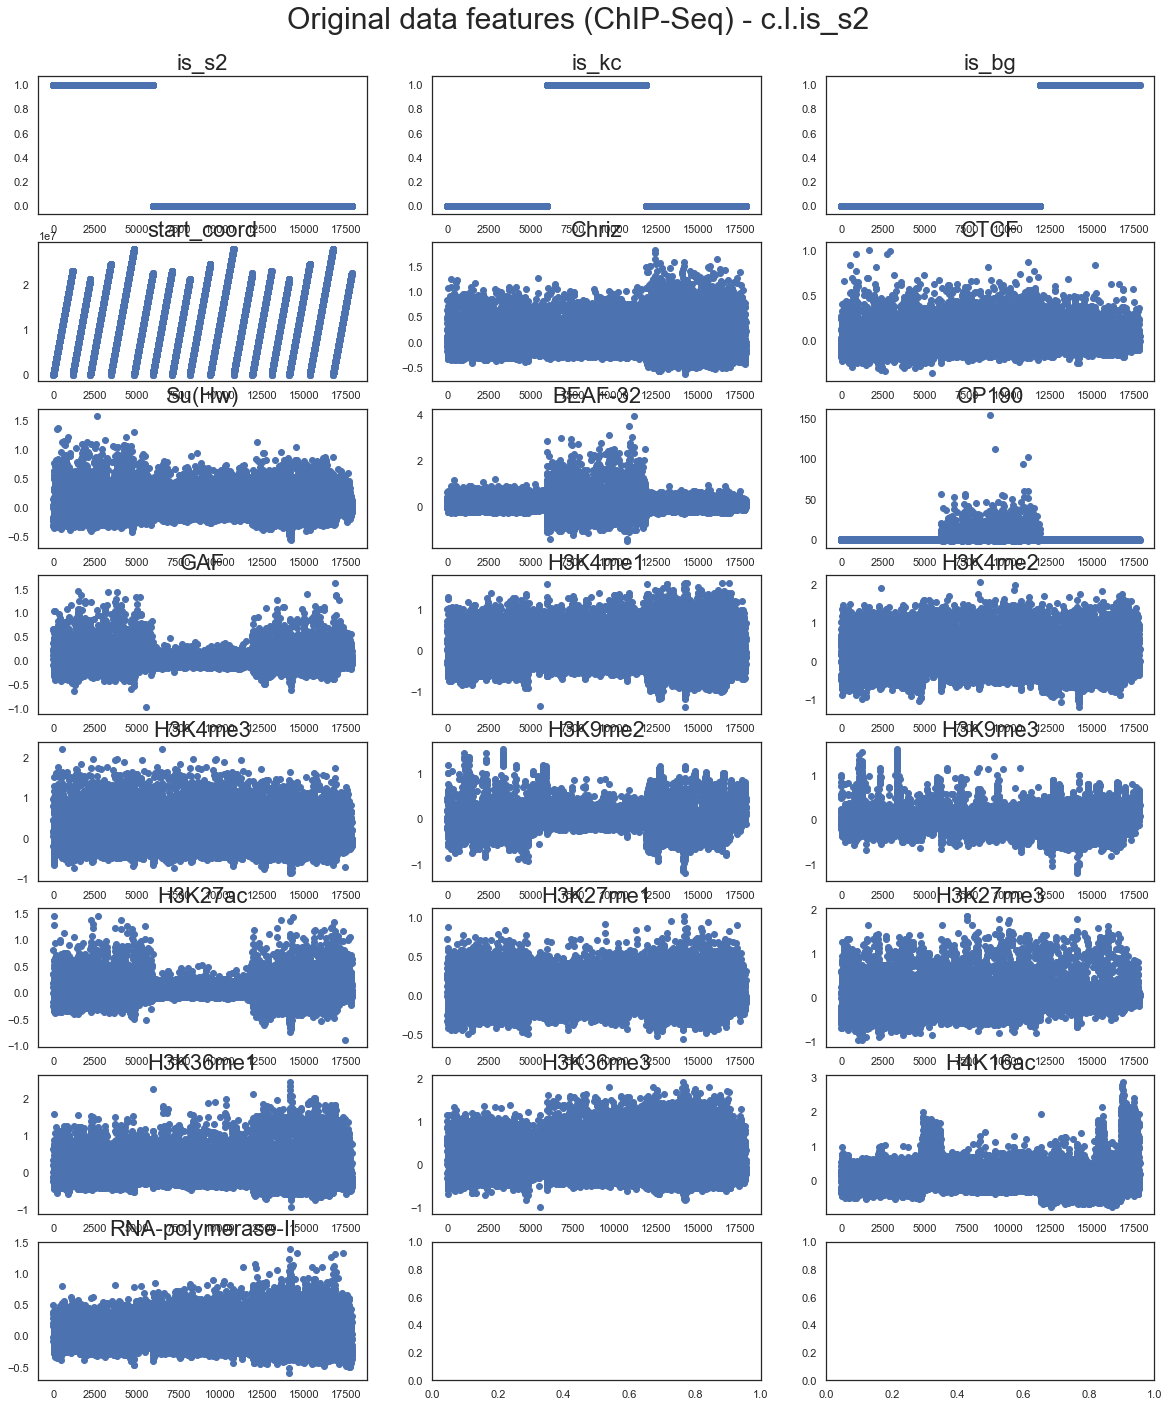

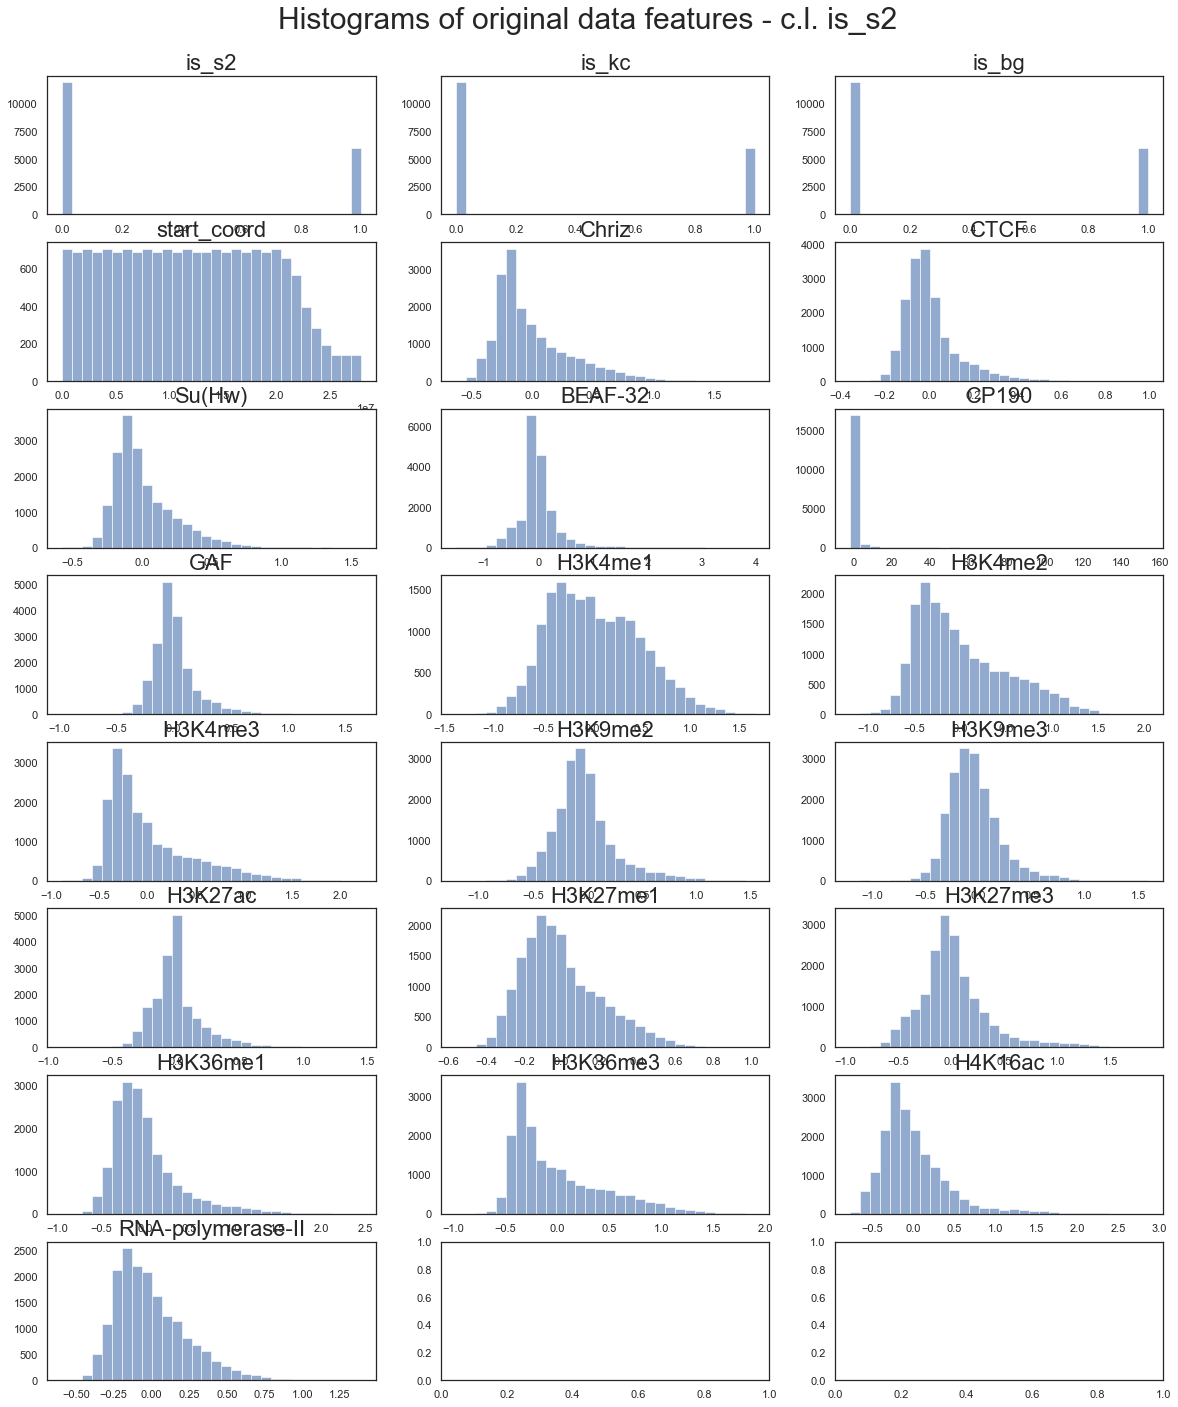

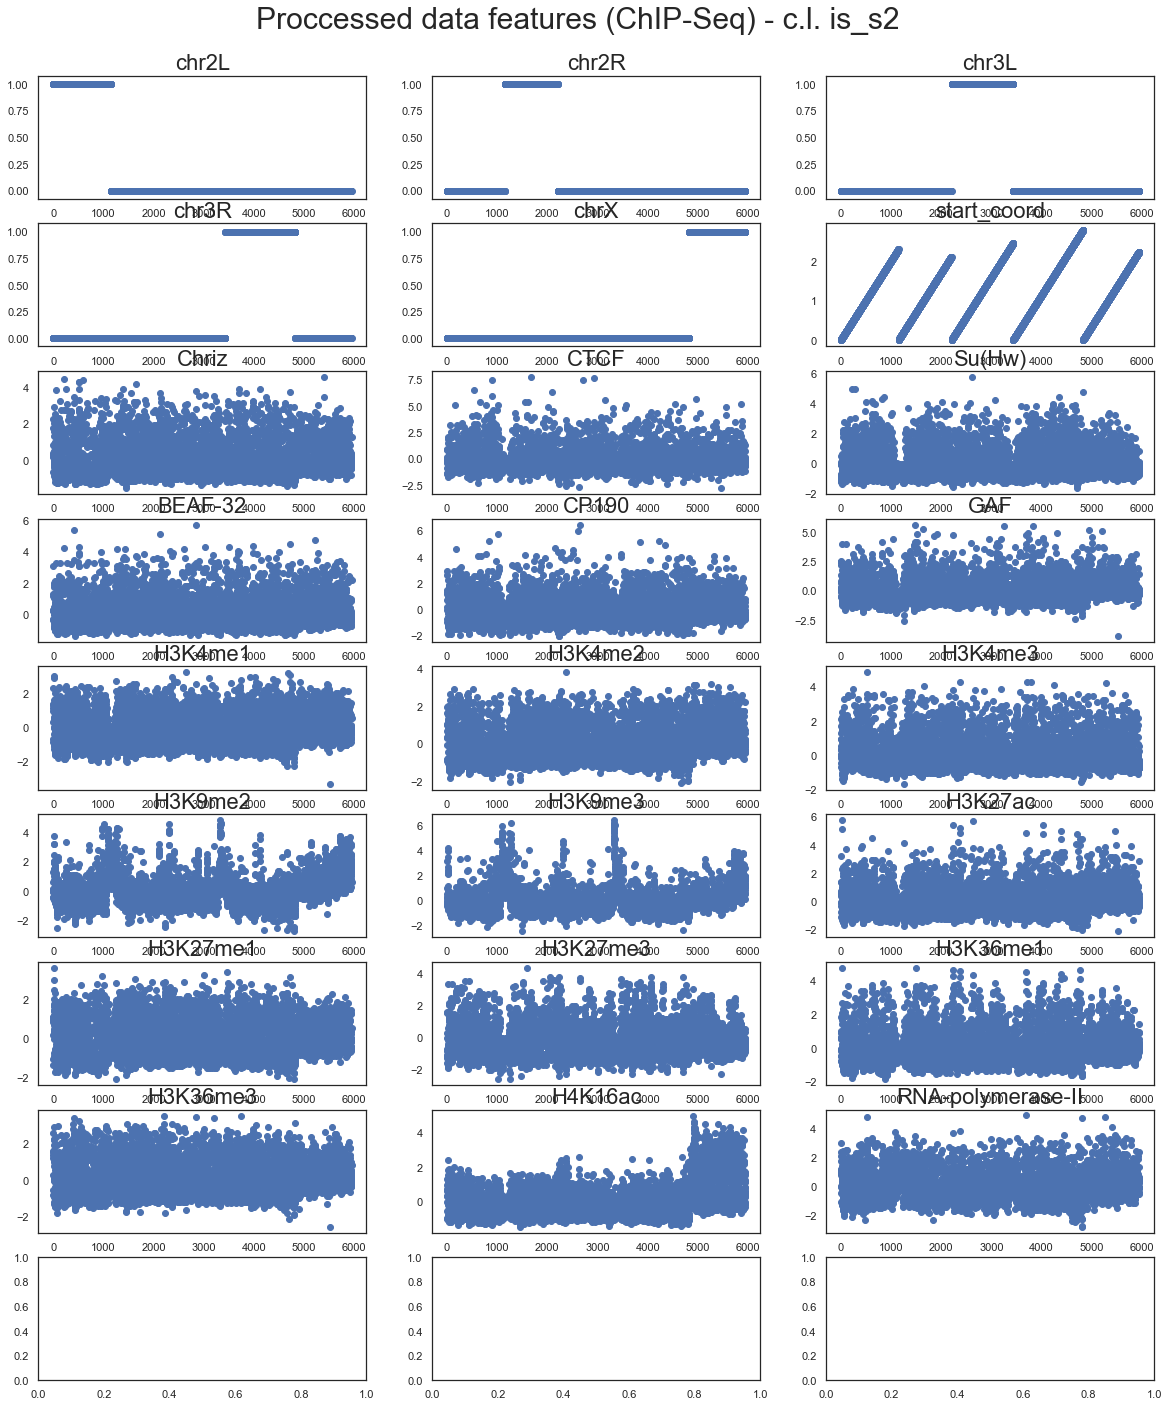

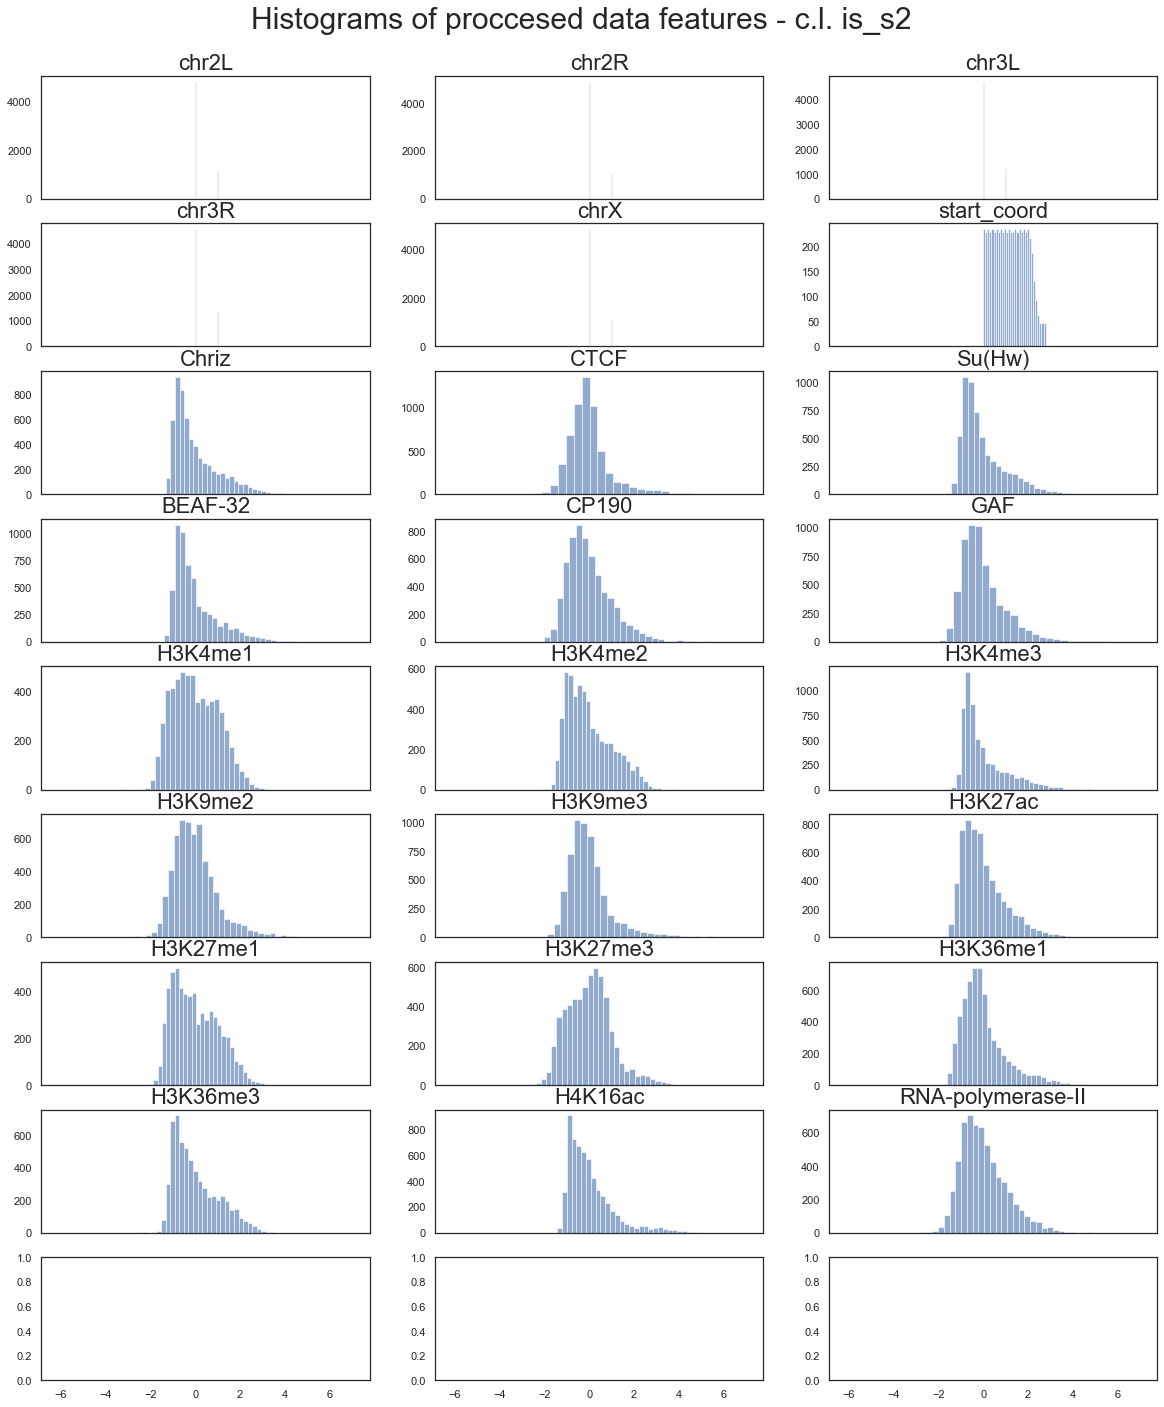

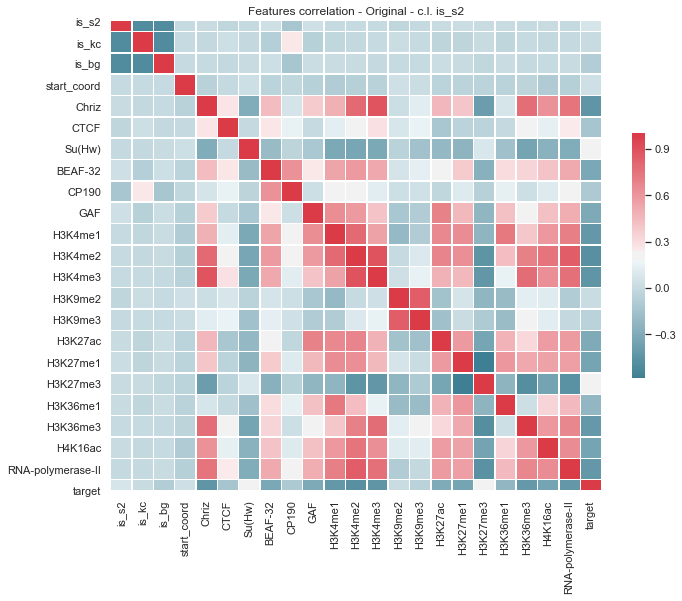

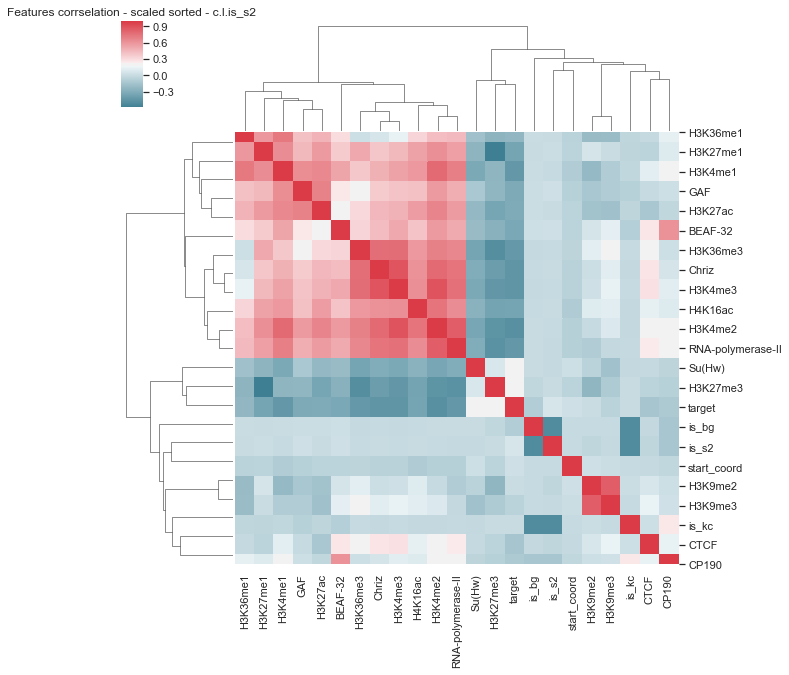

is_s2                0.068995
is_kc                0.006377
is_bg               -0.075372
start_coord          0.036987
Chriz               -0.435195
CTCF                -0.134135
Su(Hw)               0.189629
BEAF-32             -0.318613
CP190               -0.105750
GAF                 -0.306469
H3K4me1             -0.417050
H3K4me2             -0.468518
H3K4me3             -0.438623
H3K9me2              0.017396
H3K9me3             -0.045845
H3K27ac             -0.299087
H3K27me1            -0.342611
H3K27me3             0.199935
H3K36me1            -0.220909
H3K36me3            -0.410151
H4K16ac             -0.345961
RNA-polymerase-II   -0.415684
target               1.000000
Name: target, dtype: float64 Index(['H3K4me2', 'H3K4me3', 'Chriz', 'H3K4me1', 'RNA-polymerase-II',
       'H3K36me3', 'H4K16ac', 'H3K27me1', 'BEAF-32', 'GAF', 'H3K27ac',
       'H3K36me1', 'CTCF', 'CP190', 'is_bg', 'H3K9me3', 'is_kc', 'H3K9me2',
       'start_coord', 'is_s2', 'Su(Hw)', 'H3K27me3', 'target'],


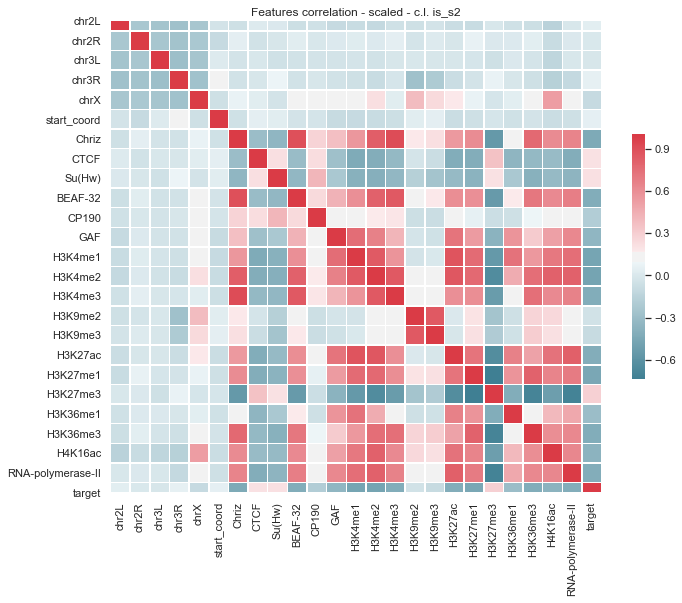

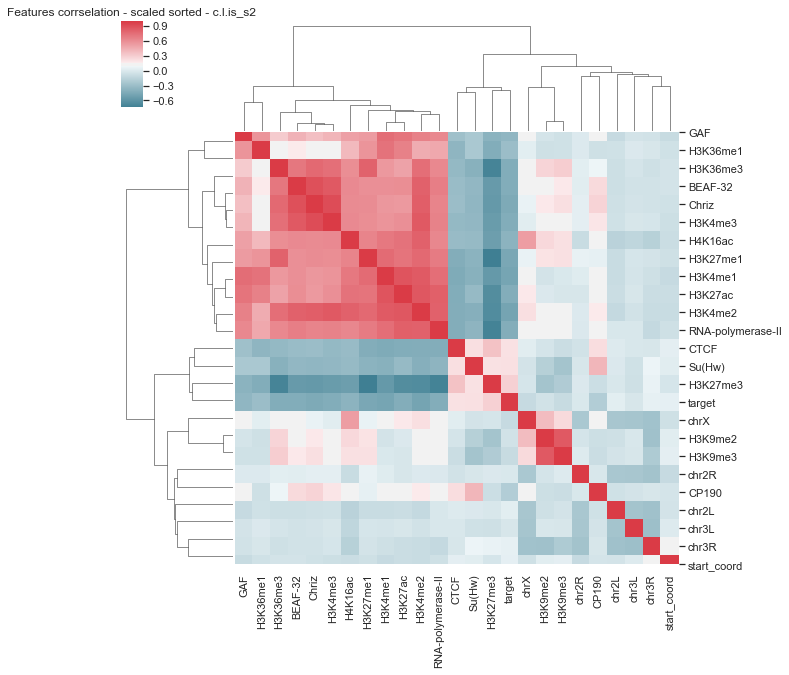

chr2L                0.040893
chr2R               -0.001248
chr3L               -0.016377
chr3R                0.063608
chrX                -0.092044
start_coord          0.051515
Chriz               -0.435518
CTCF                 0.208482
Su(Hw)               0.215525
BEAF-32             -0.412301
CP190               -0.180716
GAF                 -0.342976
H3K4me1             -0.465251
H3K4me2             -0.475649
H3K4me3             -0.413663
H3K9me2             -0.042617
H3K9me3             -0.085199
H3K27ac             -0.405127
H3K27me1            -0.453703
H3K27me3             0.294239
H3K36me1            -0.296120
H3K36me3            -0.415567
H4K16ac             -0.366379
RNA-polymerase-II   -0.407321
target               1.000000
Name: target, dtype: float64 Index(['H3K4me2', 'H3K4me1', 'H3K27me1', 'Chriz', 'H3K36me3', 'H3K4me3',
       'BEAF-32', 'RNA-polymerase-II', 'H3K27ac', 'H4K16ac', 'GAF', 'H3K36me1',
       'CP190', 'chrX', 'H3K9me3', 'H3K9me2', 'chr3L', 'chr2R', 'chr

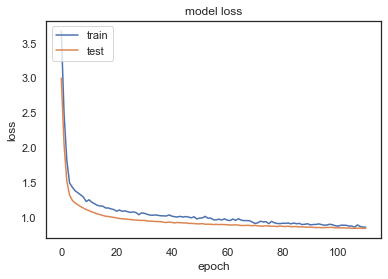

TEST WMSE =  0.8788913436201369
x_val.shape = (595, 6, 24)
y_val.shape = (595,)
x_train.shape = (3963, 6, 24)
y_train.shape = (3963,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00082: early stopping
duration: 17.173918962478638


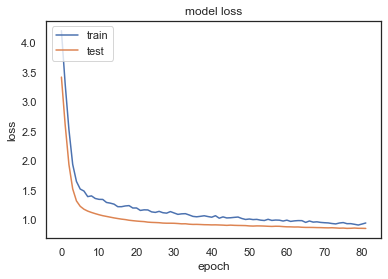

TEST WMSE =  0.8410196271829836
x_val.shape = (595, 6, 24)
y_val.shape = (595,)
x_train.shape = (3964, 6, 24)
y_train.shape = (3964,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00090: early stopping
duration: 19.088747024536133


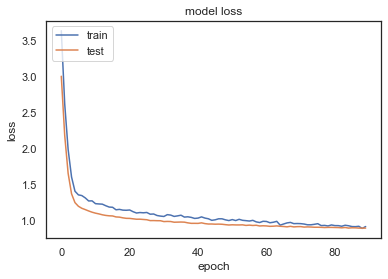

TEST WMSE =  0.8554916477992702
TEST MEAN WMSE =  0.8554916477992702


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3    0.858468
Name: weighted_mse_test, dtype: float64

In [17]:
data_csv = "_example_results_18_bioset_1_exps_21_04_20.csv"

num_experements = 1

cell_line = 'is_s2' #  'all' #  'is_bg' # 'all' # 'is_s2' # cell_line one of: 'is_s2', 'is_kc', 'is_bg',  or 'all'

bioset = None  # bioset: defines the biological features to use. 
               #  If bioset is None, use all availible features

data_path_18features = '../../data/epigenetics/s2_kc_bg_scaled_18_features.csv'
data_path = data_path_18features
target_path = "../../data/target/s2_kc_bg_clean_gamma_2901.csv"  # "../data/epigenetics/s2_kc_bg_clean_gamma.csv"
index_col = 0

random_state = 16 # None  # Shuffle the data splittings
batch_size = 160 
sequenc_len_list =  [6] # , 5, 6, 8 ] ,# 
num_lstm_units = 64 
n_epochs_max = 364 
num_folds = 3
use_chr_onehotenc = True
use_coord_scale = True

do_only_1_feature_exps = False 
do_drop_1_feature_exps = False


file_path = "./exps" + data_csv


eval_models_df_1_10x_18, eval_models_df_drop_10x_18, eval_models_df_together_10x_18, \
            mean_together_10x_18, std_together_10x_18, feature_score_1, feature_score_drop, \
            data_scaled_clean, target_clean, = main_analysis(data_path,  
                                                       cell_line, 
                                                       bioset, 
                                                       num_experements,
                                                       sequenc_len_list = [6], 
                                                       num_lstm_units = 6,
                                                       num_folds = num_folds,
                                                       batch_size = batch_size,
                                                       do_only_1_feature_exps = do_only_1_feature_exps, 
                                                       do_drop_1_feature_exps = do_drop_1_feature_exps,
                                                       do_all_together = True,
                                                       use_chr_onehotenc = use_chr_onehotenc,
                                                       use_coord_scale=use_coord_scale,
                                                       verbose=True)


mean_together_10x_18

In [18]:
 eval_models_df_together_10x_18 

exper_num  sequenc_len  num_lstm_units    n_epochs  weighted_mse_test  \
0         0          6.0             6.0  111.000000           0.878891   
1         0          6.0             6.0   82.000000           0.841020   
2         0          6.0             6.0   90.000000           0.855492   
3      mean          6.0             6.0   94.333333           0.858468   
4       std          0.0             0.0    6.256848           0.009334   

   weighted_mse_train  weighted_mse_val  weighted_mse_test_const  batch_size  \
0            0.771114          0.845591                 1.634159       160.0   
1            0.804111          0.859049                 1.600410       160.0   
2            0.793788          0.889818                 1.603966       160.0   
3            0.789671          0.864820                 1.612845       160.0   
4            0.007439          0.016355                 0.006404         0.0   

    duration  missing_feature  
0  22.112520             -1.0  
1  17.173919             -1.0  
2  19.088747             -1.0  
3  19.458395             -1.0  
4   1.226243              0.0

data.shape =  (17850, 23)
column names = ['is_s2' 'is_kc' 'is_bg' 'chrN' 'start_coord' 'Chriz' 'CTCF' 'Su(Hw)'
 'BEAF-32' 'CP190' 'GAF' 'H3K4me1' 'H3K4me2' 'H3K4me3' 'H3K9me2' 'H3K9me3'
 'H3K27ac' 'H3K27me1' 'H3K27me3' 'H3K36me1' 'H3K36me3' 'H4K16ac'
 'RNA-polymerase-II']
Using features bioset: ['Chriz', 'CTCF', 'H3K27ac', 'H3K27me3', 'Su(Hw)', 'is_s2', 'is_kc', 'is_bg', 'chrN', 'start_coord']
Using cell line: is_s2
Scaling of the features: Index(['Chriz', 'CTCF', 'H3K27ac', 'H3K27me3', 'Su(Hw)'], dtype='object')
Using chromosome One Hot Encoding: ['chr2L' 'chr2R' 'chr3L' 'chr3R' 'chrX']
proccessed data.shape = (5950, 11)
original target.shape = (17850, 6)
target.columns = Index(['is_s2', 'is_kc', 'is_bg', 'chrN', 'start_coord', 'gamma'], dtype='object')
target.shape = (5950, 3)
target.column = Index(['chrN', 'start_coord', 'gamma'], dtype='object')
data_original.head =    is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw)  \
0      1      0      0  chr2L            

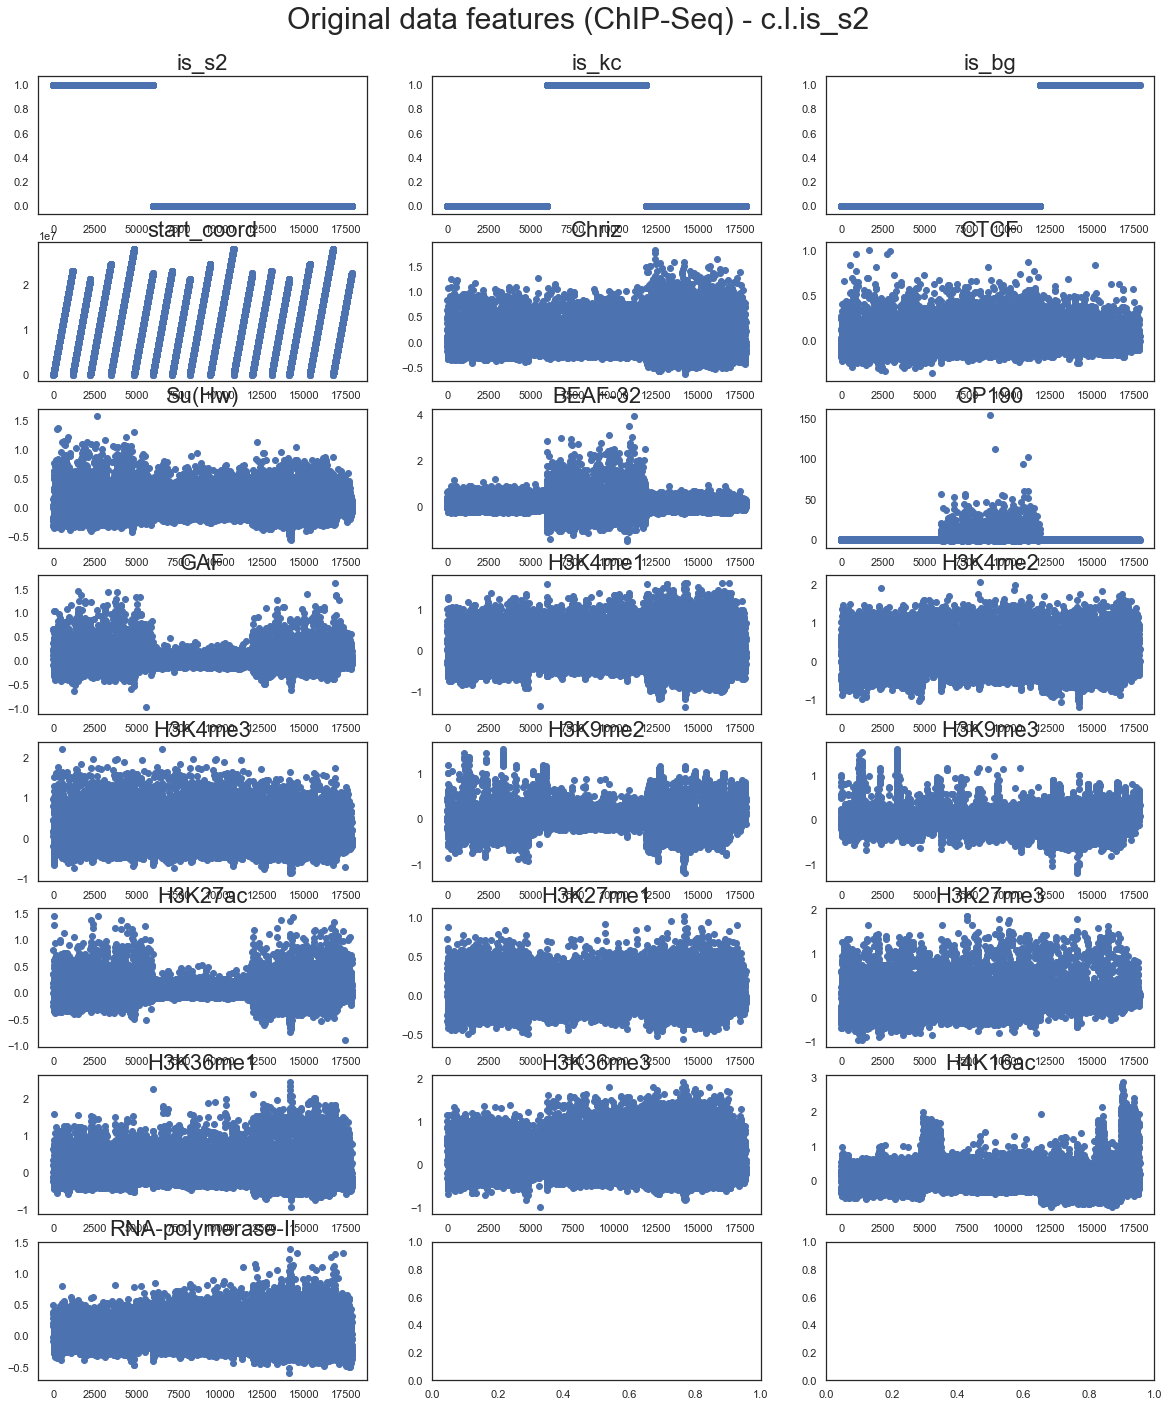

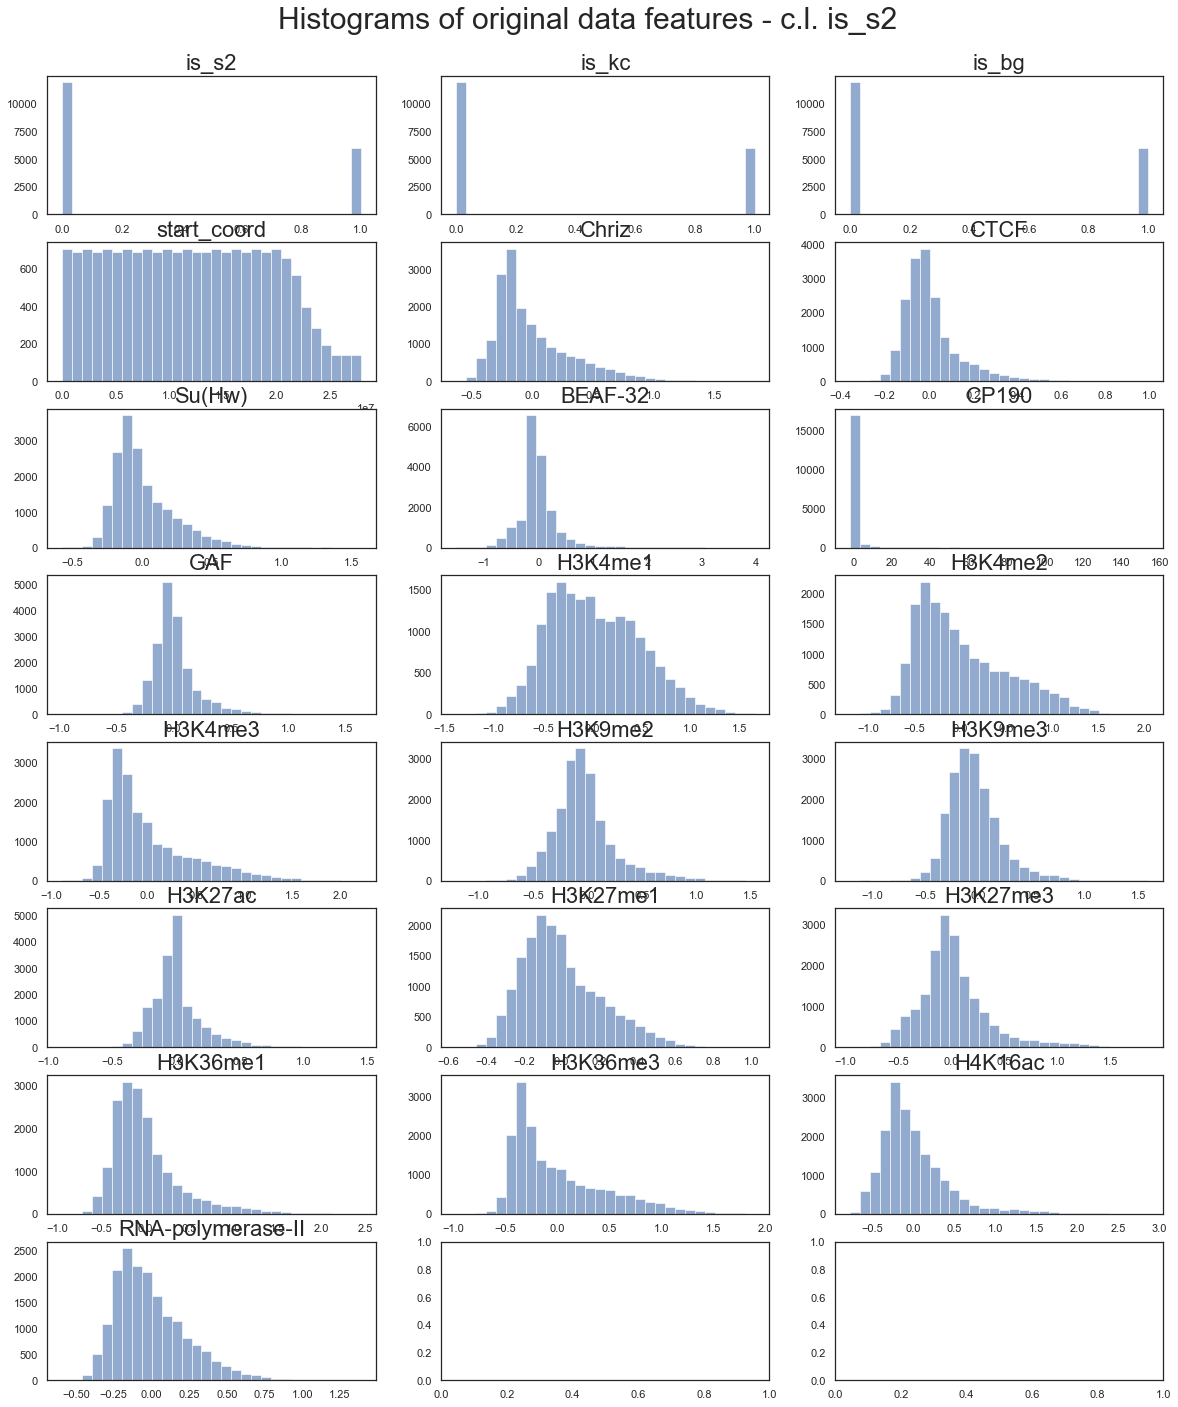

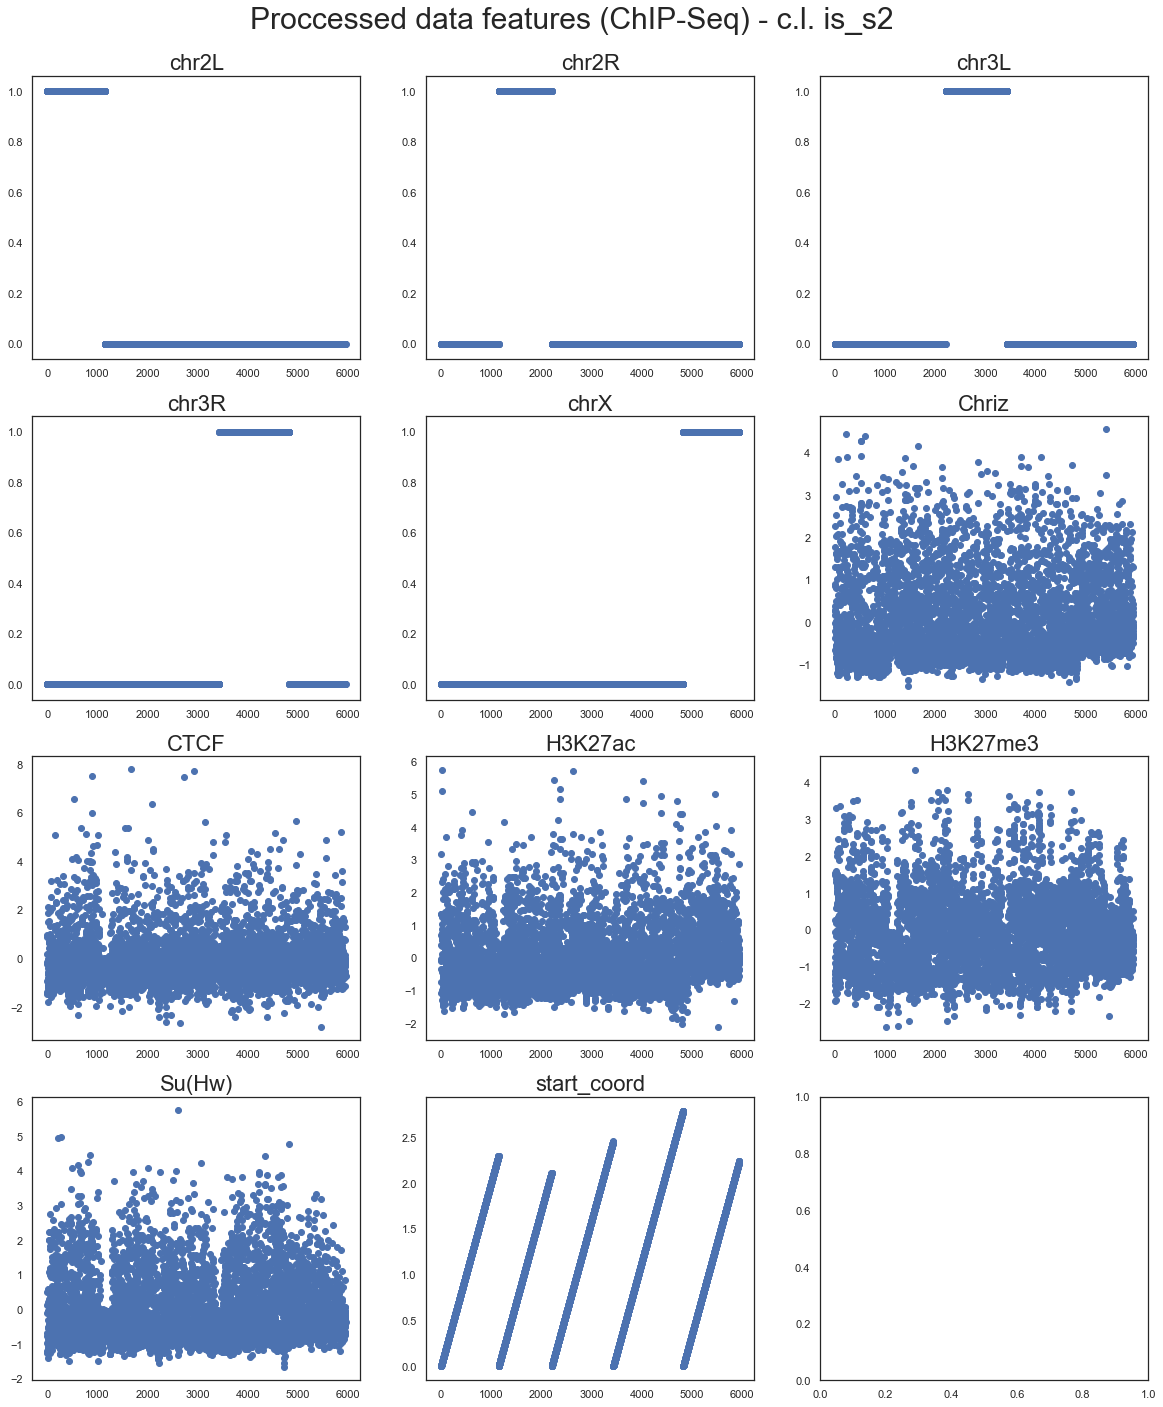

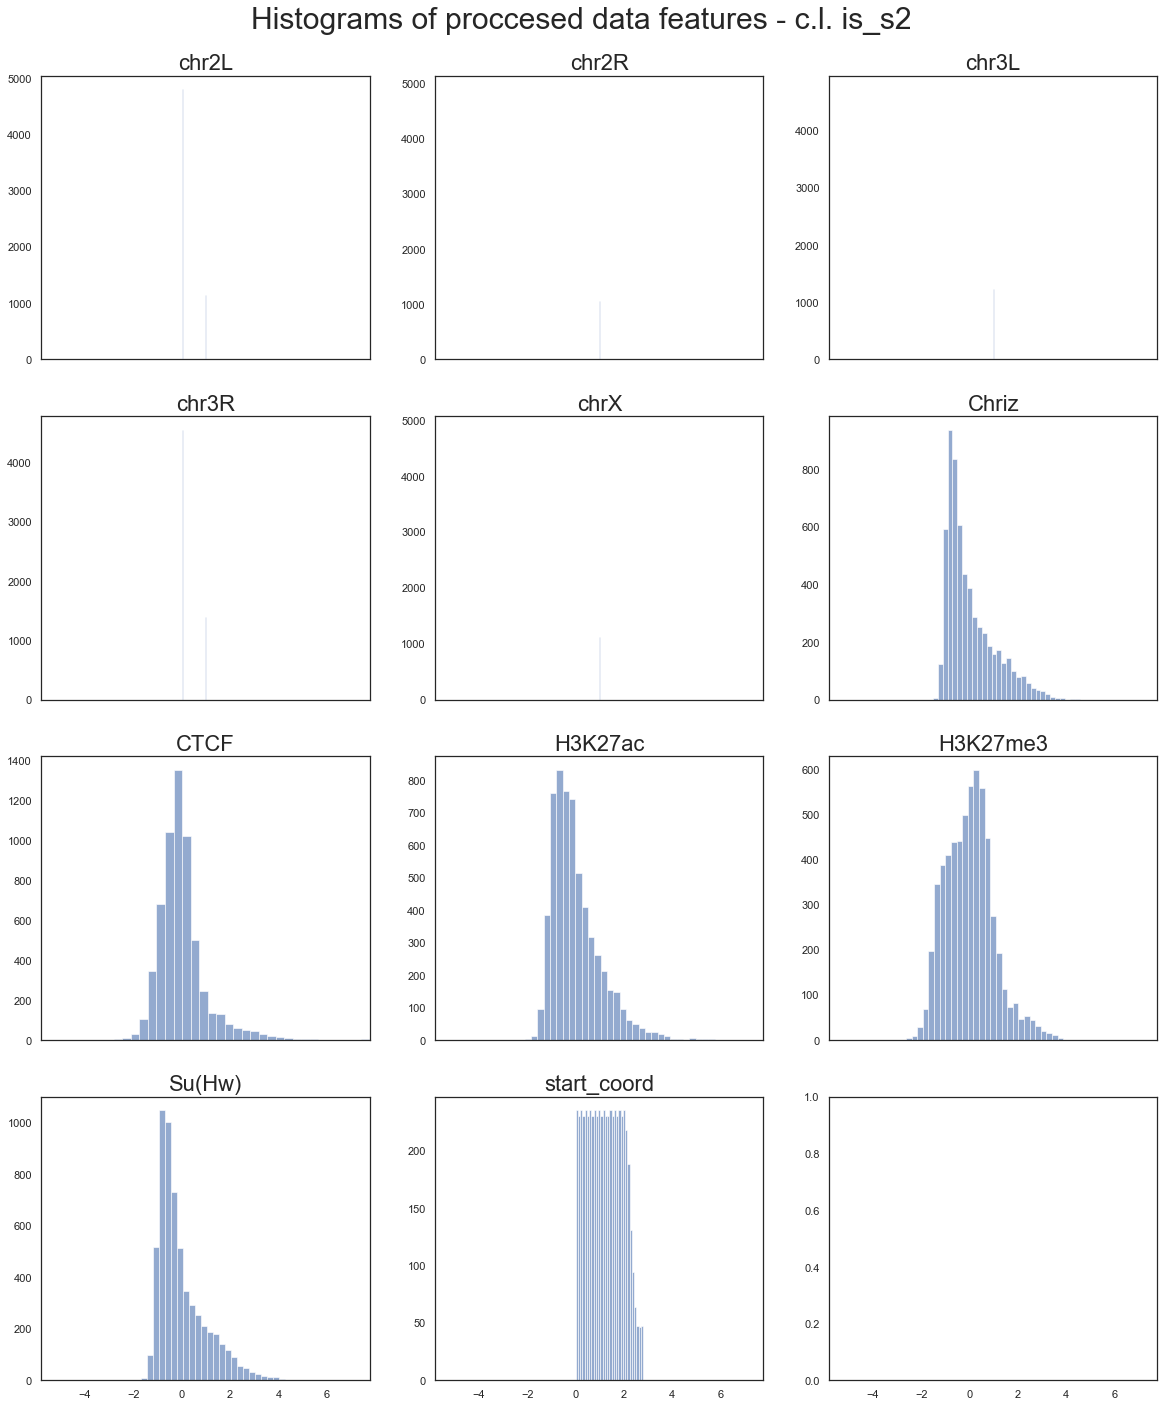

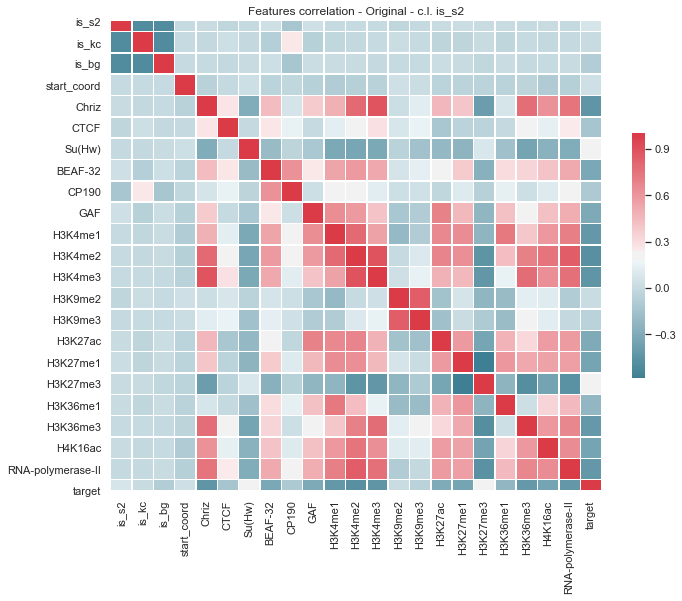

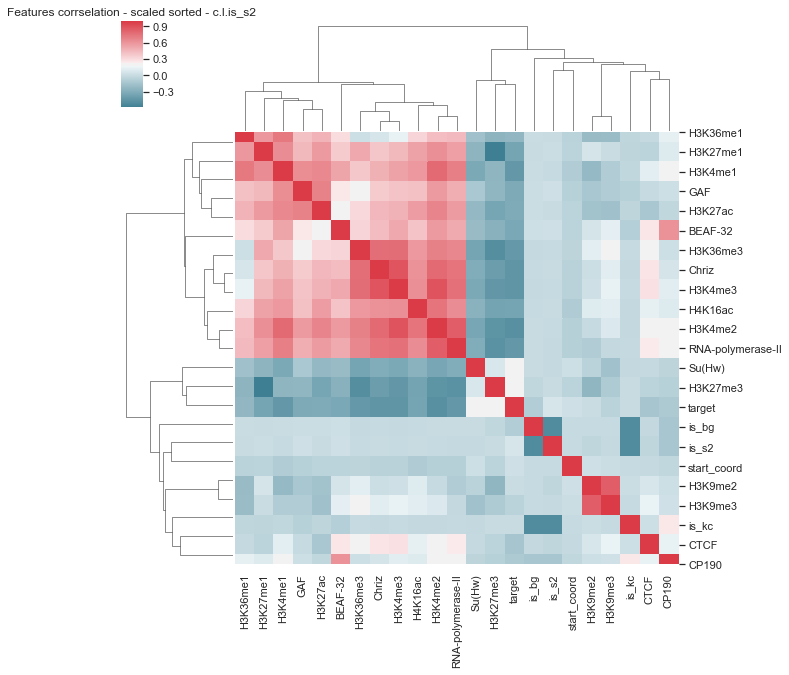

is_s2                0.068995
is_kc                0.006377
is_bg               -0.075372
start_coord          0.036987
Chriz               -0.435195
CTCF                -0.134135
Su(Hw)               0.189629
BEAF-32             -0.318613
CP190               -0.105750
GAF                 -0.306469
H3K4me1             -0.417050
H3K4me2             -0.468518
H3K4me3             -0.438623
H3K9me2              0.017396
H3K9me3             -0.045845
H3K27ac             -0.299087
H3K27me1            -0.342611
H3K27me3             0.199935
H3K36me1            -0.220909
H3K36me3            -0.410151
H4K16ac             -0.345961
RNA-polymerase-II   -0.415684
target               1.000000
Name: target, dtype: float64 Index(['H3K4me2', 'H3K4me3', 'Chriz', 'H3K4me1', 'RNA-polymerase-II',
       'H3K36me3', 'H4K16ac', 'H3K27me1', 'BEAF-32', 'GAF', 'H3K27ac',
       'H3K36me1', 'CTCF', 'CP190', 'is_bg', 'H3K9me3', 'is_kc', 'H3K9me2',
       'start_coord', 'is_s2', 'Su(Hw)', 'H3K27me3', 'target'],


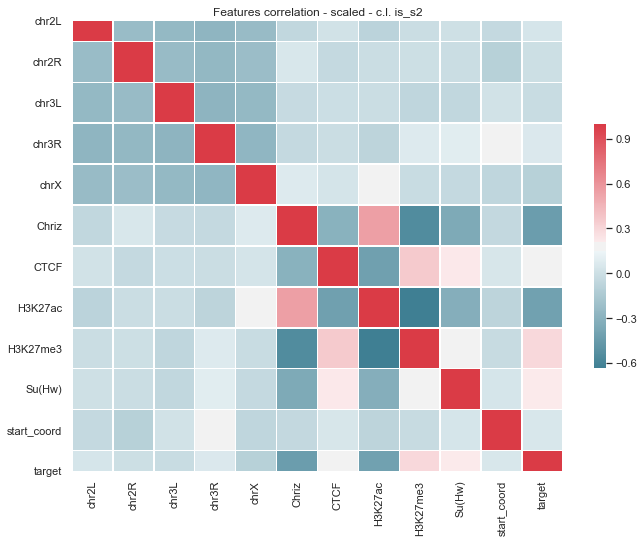

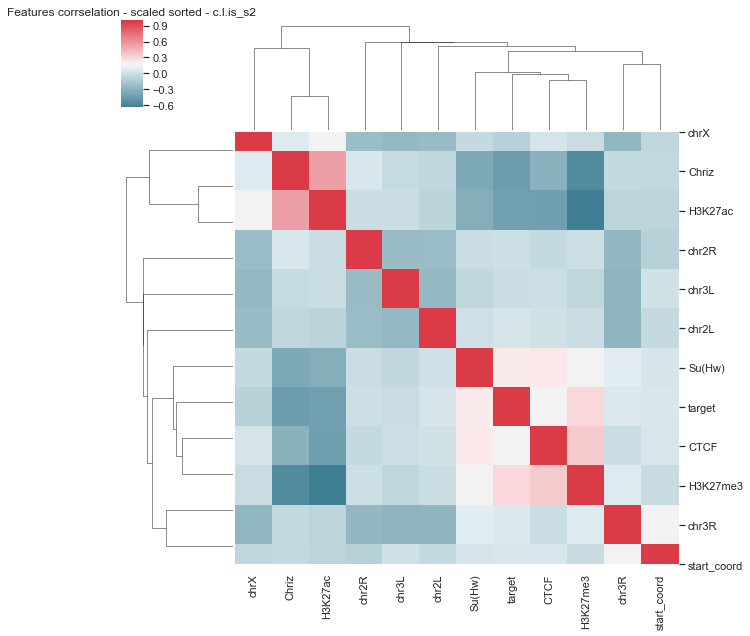

chr2L          0.040893
chr2R         -0.001248
chr3L         -0.016377
chr3R          0.063608
chrX          -0.092044
Chriz         -0.435518
CTCF           0.208482
H3K27ac       -0.405127
H3K27me3       0.294239
Su(Hw)         0.215525
start_coord    0.051515
target         1.000000
Name: target, dtype: float64 Index(['Chriz', 'H3K27ac', 'chrX', 'chr3L', 'chr2R', 'chr2L', 'start_coord',
       'chr3R', 'CTCF', 'Su(Hw)', 'H3K27me3', 'target'],
      dtype='object')

-----
 DROP FEATURE NUMBER -- 0
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00022: early stopping
duration: 14.983024835586548


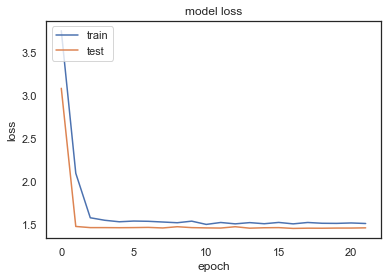

TEST WMSE =  1.649273046730572
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 8.042836904525757


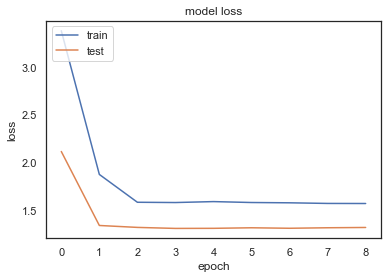

TEST WMSE =  1.453696604673731
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00014: early stopping
duration: 11.203949928283691


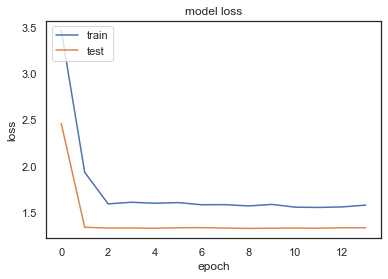

TEST WMSE =  1.4786539455931005
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00014: early stopping
duration: 9.734354734420776


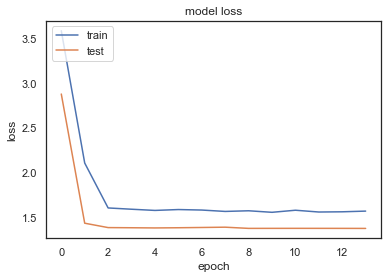

TEST WMSE =  1.4705298403317015
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00008: early stopping
duration: 7.336784839630127


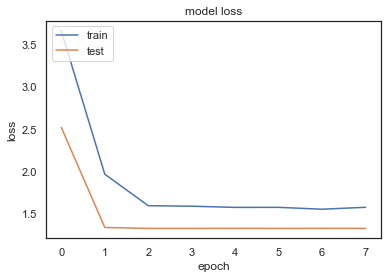

TEST WMSE =  1.5428781981900308
TEST MEAN WMSE =  1.5428781981900308


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 1
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00007: early stopping
duration: 7.521298170089722


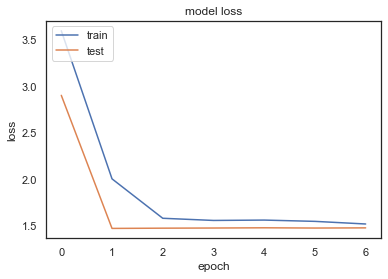

TEST WMSE =  1.6704142773558552
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00015: early stopping
duration: 9.423136949539185


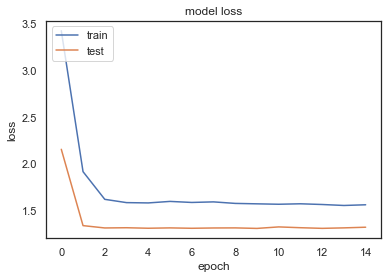

TEST WMSE =  1.4555695307863872
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00010: early stopping
duration: 8.25935411453247


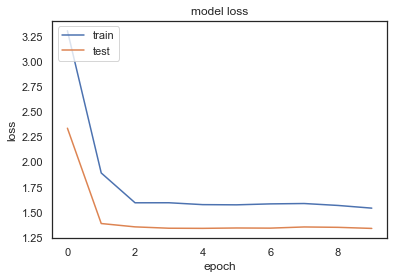

TEST WMSE =  1.4754203451497914
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00011: early stopping
duration: 8.874278783798218


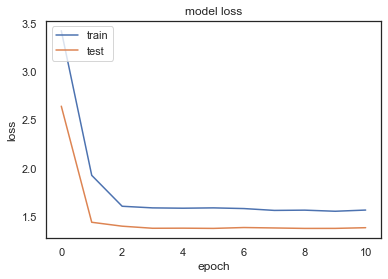

TEST WMSE =  1.4731520901514943
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00008: early stopping
duration: 7.15217399597168


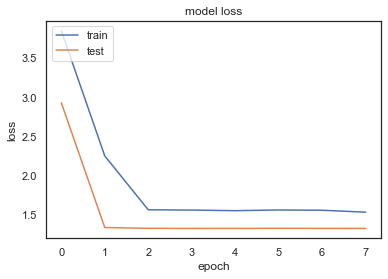

TEST WMSE =  1.5529977481594512
TEST MEAN WMSE =  1.5529977481594512


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 2
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 7.285849094390869


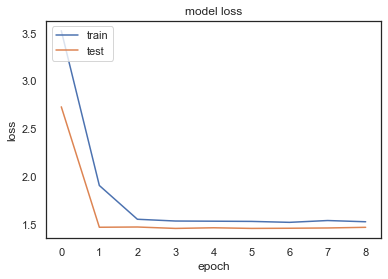

TEST WMSE =  1.6645736060526621
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00011: early stopping
duration: 8.670321941375732


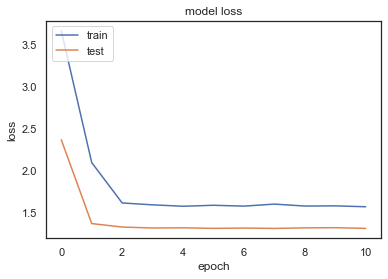

TEST WMSE =  1.4573702116781495
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00011: early stopping
duration: 8.49026107788086


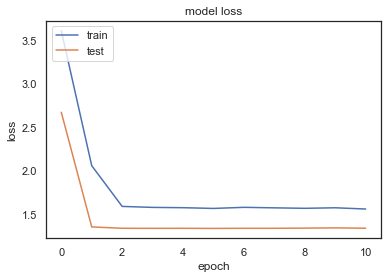

TEST WMSE =  1.4747900965039002
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00007: early stopping
duration: 7.000508069992065


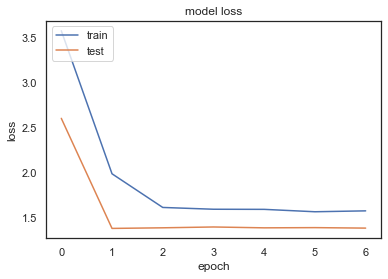

TEST WMSE =  1.470486435180607
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 6.507087707519531


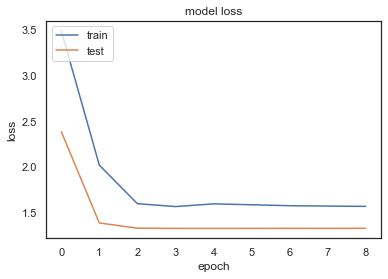

TEST WMSE =  1.5557974784611088
TEST MEAN WMSE =  1.5557974784611088


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 3
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00014: early stopping
duration: 8.835862159729004


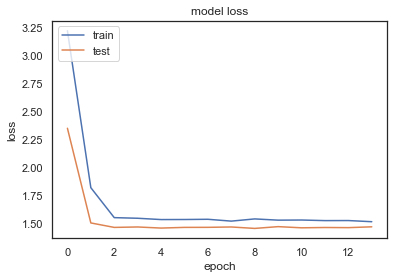

TEST WMSE =  1.6628155595600247
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00011: early stopping
duration: 8.067095041275024


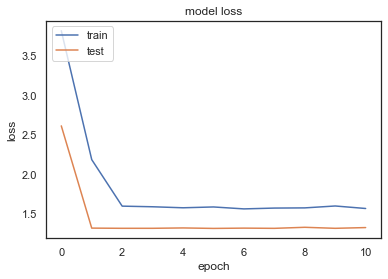

TEST WMSE =  1.4531207129382802
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00010: early stopping
duration: 6.427632808685303


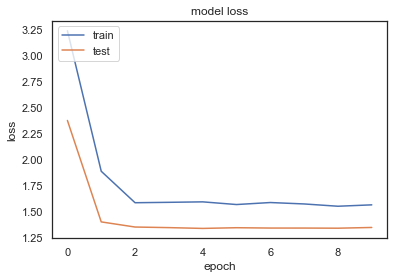

TEST WMSE =  1.4776554881530395
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 6.7003021240234375


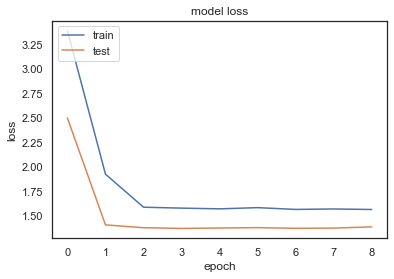

TEST WMSE =  1.4780955502362885
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 6.418423175811768


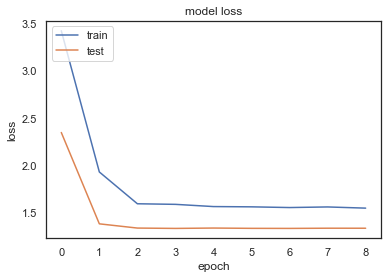

TEST WMSE =  1.5470472497353014
TEST MEAN WMSE =  1.5470472497353014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 4
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00012: early stopping
duration: 7.3102641105651855


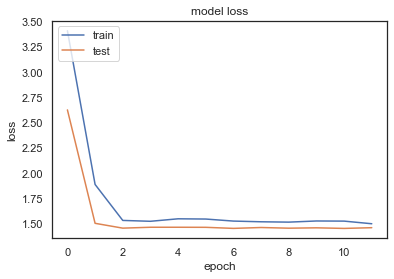

TEST WMSE =  1.65157015939022
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00011: early stopping
duration: 6.764657735824585


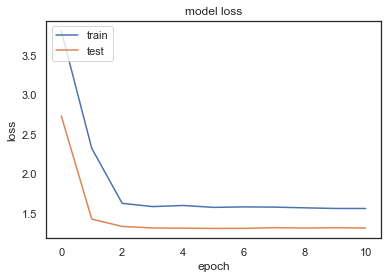

TEST WMSE =  1.4488306942704607
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00012: early stopping
duration: 7.055759906768799


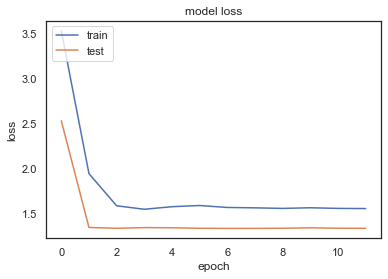

TEST WMSE =  1.4760160988088353
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00012: early stopping
duration: 7.7938690185546875


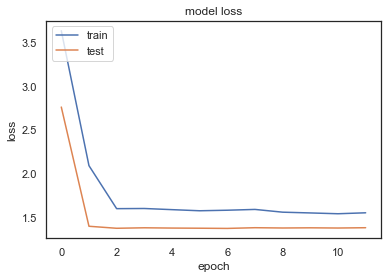

TEST WMSE =  1.472025160481091
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00008: early stopping
duration: 6.052540063858032


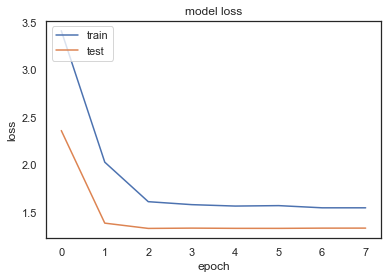

TEST WMSE =  1.5398900221711485
TEST MEAN WMSE =  1.5398900221711485


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 5
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00042: early stopping
duration: 18.09514284133911


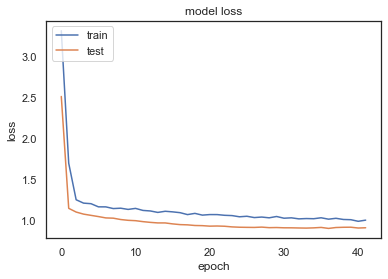

TEST WMSE =  1.1500139274109598
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00065: early stopping
duration: 26.241459846496582


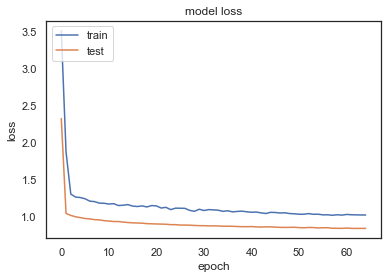

TEST WMSE =  0.9409137689945314
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00038: early stopping
duration: 16.96086311340332


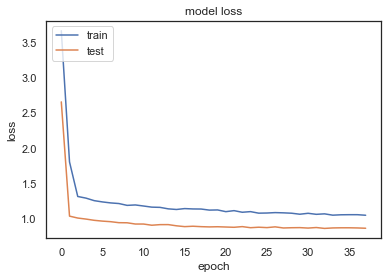

TEST WMSE =  0.9344577025695003
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00036: early stopping
duration: 16.94711399078369


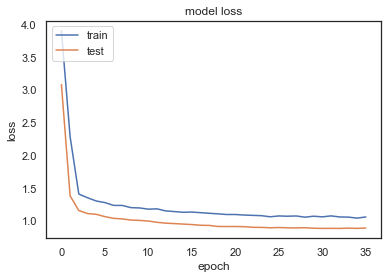

TEST WMSE =  0.9451203699806684
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00049: early stopping
duration: 21.168338298797607


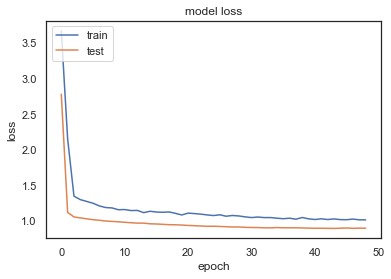

TEST WMSE =  1.0438109120946104
TEST MEAN WMSE =  1.0438109120946104


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 6
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00043: early stopping
duration: 19.003378868103027


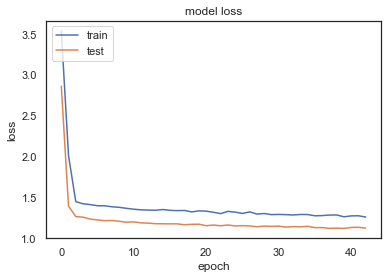

TEST WMSE =  1.3769831276162845
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00053: early stopping
duration: 22.810264110565186


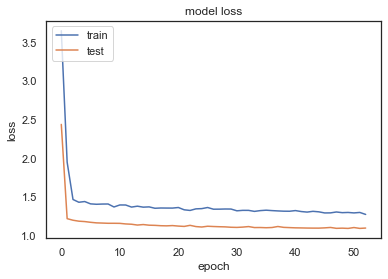

TEST WMSE =  1.2257607633041323
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00062: early stopping
duration: 25.7801570892334


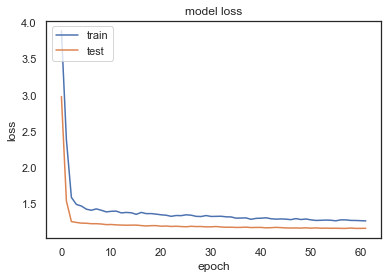

TEST WMSE =  1.1922526592550649
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00014: early stopping
duration: 8.47965407371521


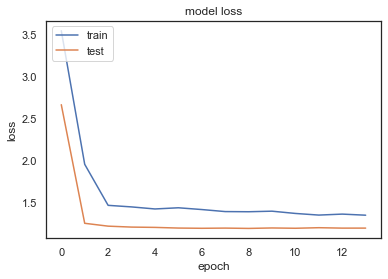

TEST WMSE =  1.2812159256261733
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00037: early stopping
duration: 16.382910013198853


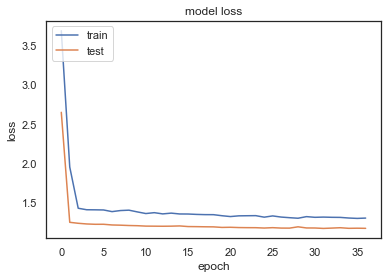

TEST WMSE =  1.310663173134374
TEST MEAN WMSE =  1.310663173134374


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 7
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00041: early stopping
duration: 22.13996434211731


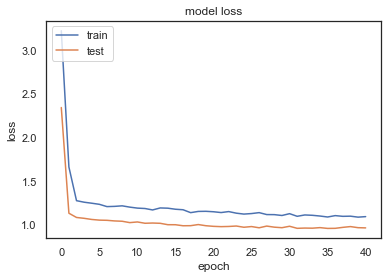

TEST WMSE =  1.1934236359275163
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00033: early stopping
duration: 19.585415840148926


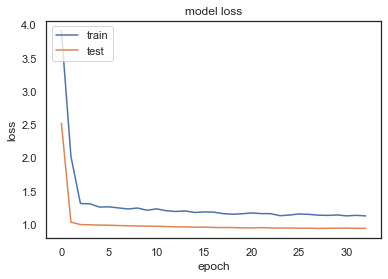

TEST WMSE =  0.992914182949351
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00054: early stopping
duration: 30.408059120178223


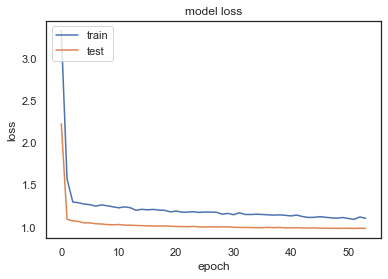

TEST WMSE =  1.0166995544541317
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00034: early stopping
duration: 19.525145292282104


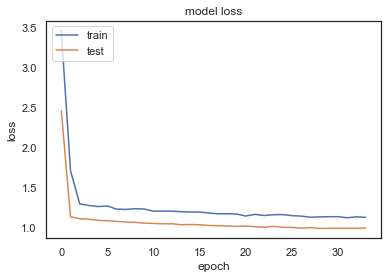

TEST WMSE =  1.0602801643288953
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00062: early stopping
duration: 35.2629759311676


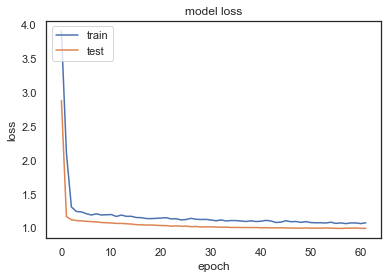

TEST WMSE =  1.1026911089586213
TEST MEAN WMSE =  1.1026911089586213


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 8
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00050: early stopping
duration: 29.433929204940796


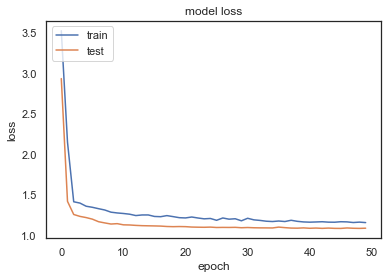

TEST WMSE =  1.281714690874246
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00040: early stopping
duration: 23.80602717399597


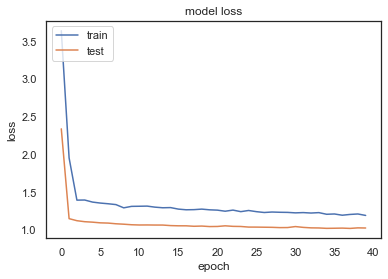

TEST WMSE =  1.1101943700270942
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00030: early stopping
duration: 18.255682229995728


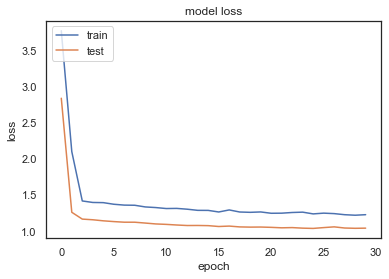

TEST WMSE =  1.0636649051283864
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00034: early stopping
duration: 19.01149892807007


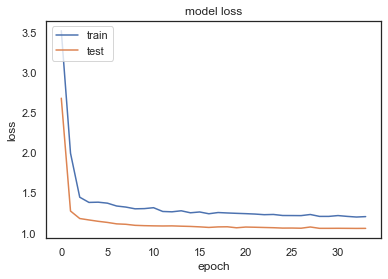

TEST WMSE =  1.1401628726915896
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00075: early stopping
duration: 39.90585207939148


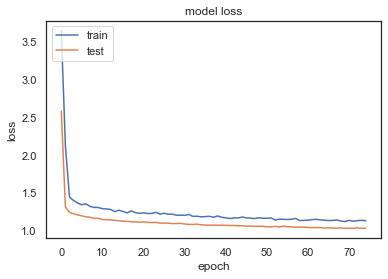

TEST WMSE =  1.2028912327899837
TEST MEAN WMSE =  1.2028912327899837


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 9
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00020: early stopping
duration: 13.916500806808472


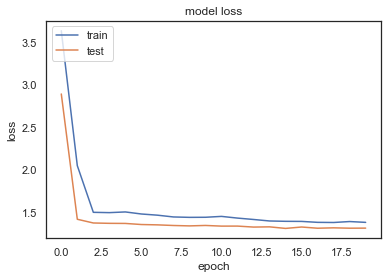

TEST WMSE =  1.47192388080678
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00024: early stopping
duration: 14.96496319770813


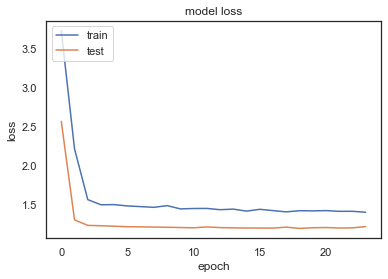

TEST WMSE =  1.3254727098727648
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00033: early stopping
duration: 19.504374980926514


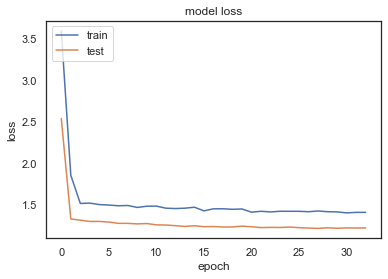

TEST WMSE =  1.2934610352821028
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00029: early stopping
duration: 17.408112049102783


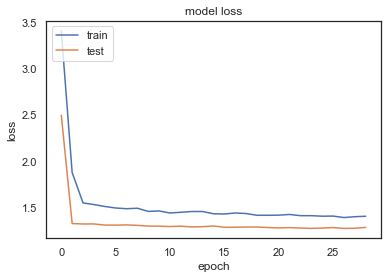

TEST WMSE =  1.3428575726527565
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00028: early stopping
duration: 18.93389582633972


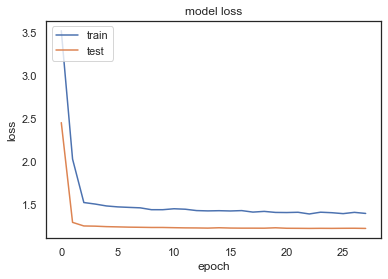

TEST WMSE =  1.4037054924713503
TEST MEAN WMSE =  1.4037054924713503


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 10
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00013: early stopping
duration: 9.360414981842041


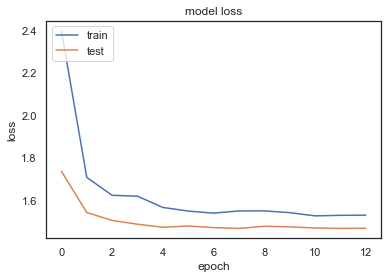

TEST WMSE =  1.6554671140521853
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00018: early stopping
duration: 11.18546724319458


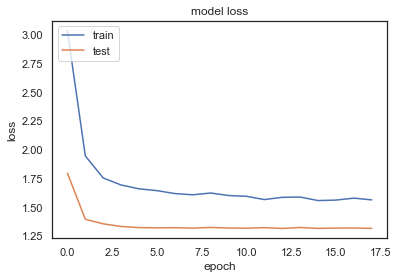

TEST WMSE =  1.4594028319877113
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00020: early stopping
duration: 12.163279294967651


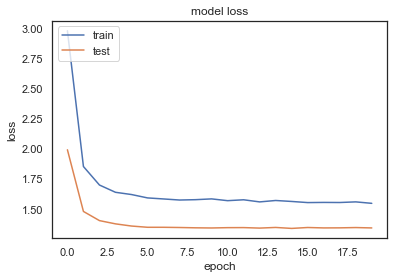

TEST WMSE =  1.4755787842307064
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00019: early stopping
duration: 12.54052209854126


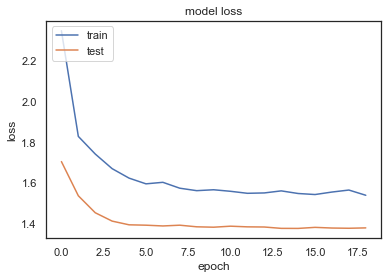

TEST WMSE =  1.4671504730613547
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00017: early stopping
duration: 11.30615496635437


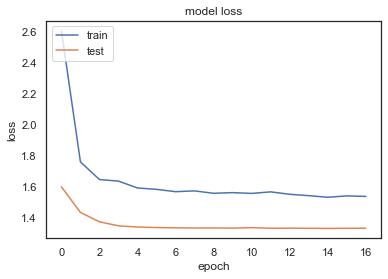

TEST WMSE =  1.5502175276139367
TEST MEAN WMSE =  1.5502175276139367


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 KEEP FEATURES -- 10
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 11) (1248, 6, 11) (4161,) (1248,)
x_val.shape = (357, 6, 11)
y_val.shape = (357,)
x_train.shape = (4756, 6, 11)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00076: early stopping
duration: 19.820496320724487


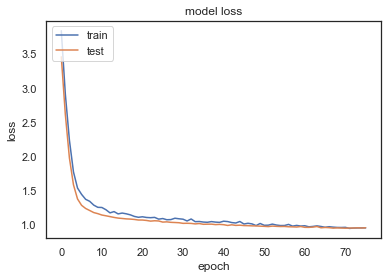

TEST WMSE =  0.979452470261758
x_val.shape = (357, 6, 11)
y_val.shape = (357,)
x_train.shape = (4756, 6, 11)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00084: early stopping
duration: 23.585825204849243


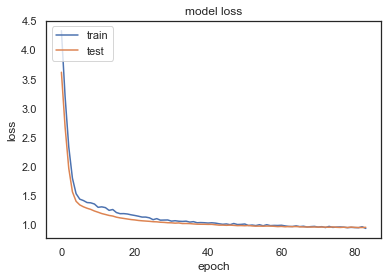

TEST WMSE =  0.7855675811155471
x_val.shape = (357, 6, 11)
y_val.shape = (357,)
x_train.shape = (4756, 6, 11)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00104: early stopping
duration: 26.333833932876587


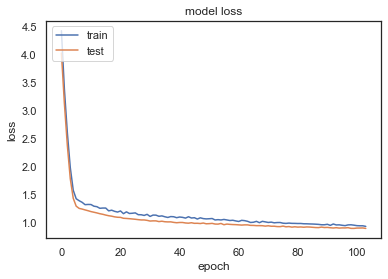

TEST WMSE =  0.8037091144658188
x_val.shape = (357, 6, 11)
y_val.shape = (357,)
x_train.shape = (4756, 6, 11)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00067: early stopping
duration: 17.7257399559021


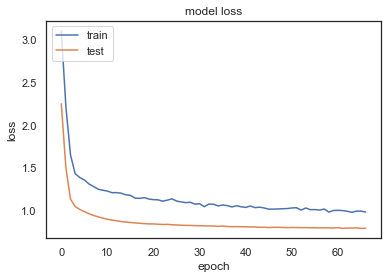

TEST WMSE =  0.9289827979990534
x_val.shape = (357, 6, 11)
y_val.shape = (357,)
x_train.shape = (4756, 6, 11)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00076: early stopping
duration: 19.6927809715271


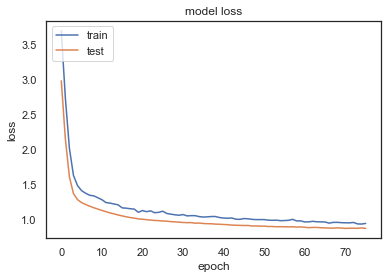

TEST WMSE =  0.9479386684325465
TEST MEAN WMSE =  0.9479386684325465


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   exper_num  sequenc_len  num_lstm_units    n_epochs  weighted_mse_test  \
0          0          6.0             6.0   22.000000           1.649273   
1          0          6.0             6.0    9.000000           1.453697   
2          0          6.0             6.0   14.000000           1.478654   
3          0          6.0             6.0   14.000000           1.470530   
4          0          6.0             6.0    8.000000           1.542878   
5       mean          6.0             6.0   13.400000           1.519006   
6        std          0.0             0.0    2.934621           0.036809   
7          0          6.0             6.0    7.000000           1.670414   
8          0          6.0             6.0   15.000000           1.455570   
9          0          6.0             6.0   10.000000           1.475420   
10         0          6.0             6.0   11.000000           1.473152   
11         0          6.0             6.0    8.000000           1.552998   
12      mean

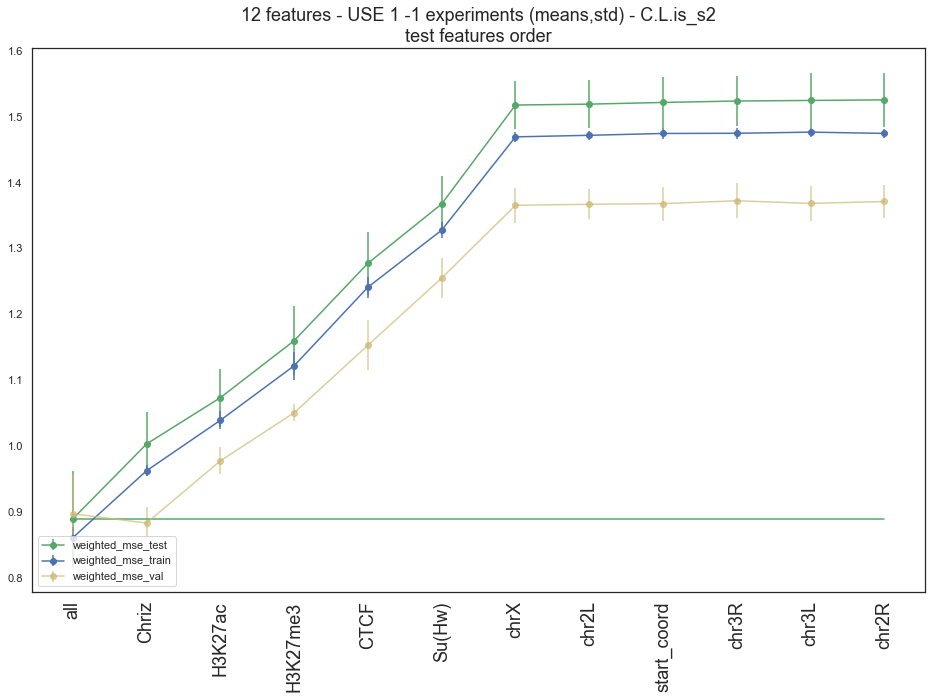

all
Chriz
H3K27ac
H3K27me3
CTCF
Su(Hw)
chrX
chr2L
start_coord
chr2R
chr3R
chr3L
num_features:  12


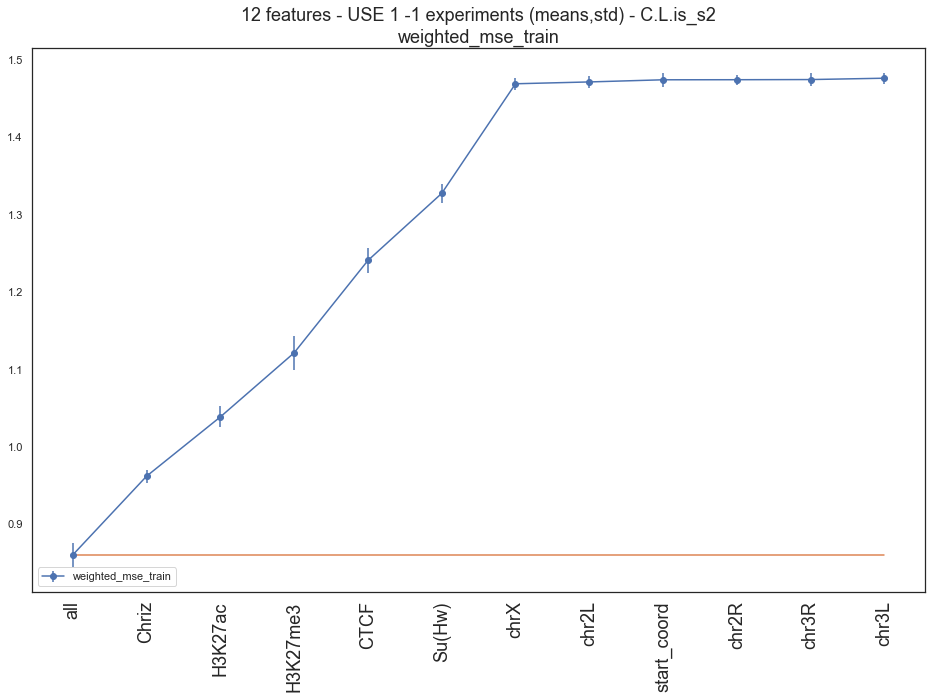

all
Chriz
H3K27ac
H3K27me3
CTCF
Su(Hw)
chrX
chr2L
start_coord
chr3R
chr3L
chr2R
num_features:  12


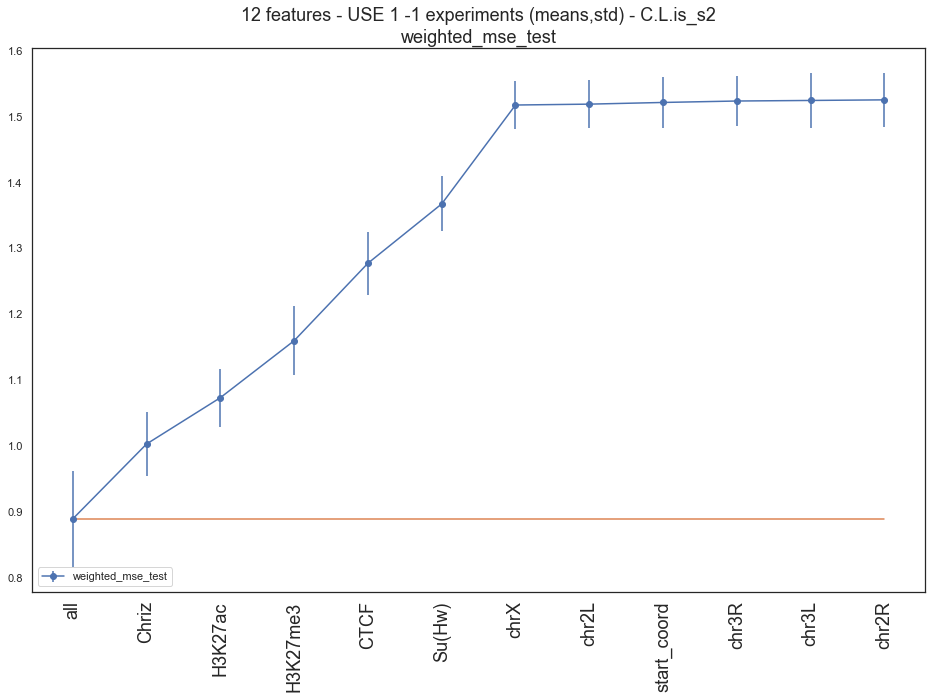

TEST wMSE using 1
all , 0.8891301264549447
Chriz , 1.002863336210054
H3K27ac , 1.0732017293237033
H3K27me3 , 1.15972561430226
CTCF , 1.2773751297872058
Su(Hw) , 1.367484138217151
chrX , 1.517666427024351
chr2L , 1.5190063271038272
start_coord , 1.5215633461891789
chr3R , 1.523746912124587
chr3L , 1.5246035655752856
chr2R , 1.5255107983205958
X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 11) (1248, 6, 11) (4161,) (1248,)
x_val.shape = (357, 6, 11)
y_val.shape = (357,)
x_train.shape = (4756, 6, 11)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00066: early stopping
duration: 34.664571046829224


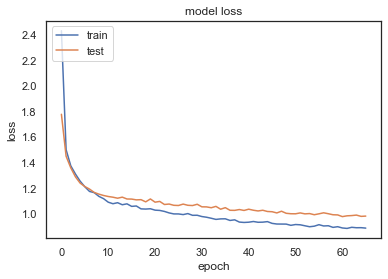

TEST WMSE =  0.9298238354552869
x_val.shape = (357, 6, 11)
y_val.shape = (357,)
x_train.shape = (4756, 6, 11)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00082: early stopping
duration: 44.07437992095947


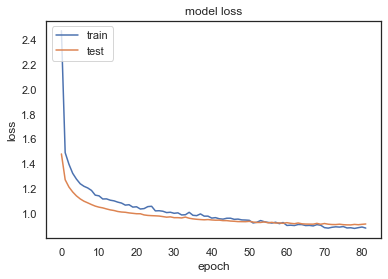

TEST WMSE =  0.8022320090853405
x_val.shape = (357, 6, 11)
y_val.shape = (357,)
x_train.shape = (4756, 6, 11)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00046: early stopping
duration: 25.64636492729187


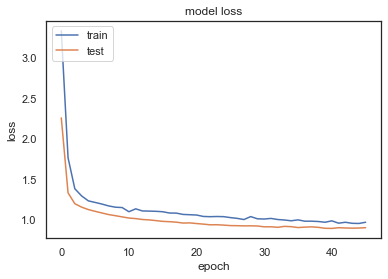

TEST WMSE =  0.8185553688595019
x_val.shape = (357, 6, 11)
y_val.shape = (357,)
x_train.shape = (4756, 6, 11)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00067: early stopping
duration: 34.157203912734985


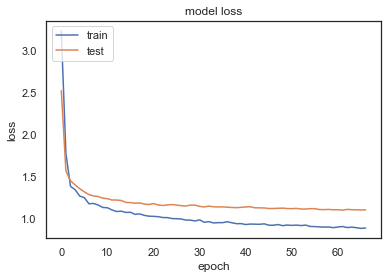

TEST WMSE =  0.7411023347056208
x_val.shape = (357, 6, 11)
y_val.shape = (357,)
x_train.shape = (4756, 6, 11)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00051: early stopping
duration: 27.27448606491089


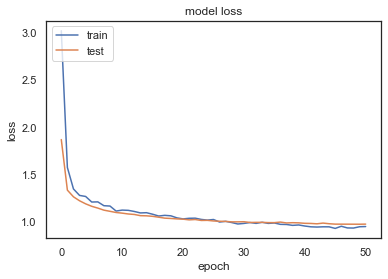

TEST WMSE =  0.9208472722572462
TEST MEAN WMSE =  0.9208472722572462


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
data_csv = "_example_results_18_bioset_10_exps_23_04_20.csv"

num_experements = 1

cell_line = 'is_s2' #  'all' #  'is_bg' # 'all' # 'is_s2' # cell_line one of: 'is_s2', 'is_kc', 'is_bg',  or 'all'

bioset = None  # bioset: defines the biological features to use. 
               #  If bioset is None, use all availible features
bioset = [
    'Chriz',
    'CTCF',
    'H3K27ac',
    'H3K27me3',
    'Su(Hw)',
    'is_s2', 'is_kc', 'is_bg', 
    'chrN', 
    'start_coord',
]


data_path_18features = '../../data/epigenetics/s2_kc_bg_scaled_18_features.csv'
data_path = data_path_18features


target_path = "../../data/target/s2_kc_bg_clean_gamma_2901.csv"  # "../data/epigenetics/s2_kc_bg_clean_gamma.csv"
index_col = 0
random_state = 16 # None  # Shuffle the data splittings
batch_size = 60 
sequenc_len_list =  [6]
num_lstm_units = 64 
n_epochs_max = 364 
num_folds = 5
file_path = "./exps" + data_csv
use_chr_onehotenc = True
use_coord_scale = True

do_only_1_feature_exps = True 
do_drop_1_feature_exps = False

eval_models_df_1_10x_5f, eval_models_df_drop_10x_5f, eval_models_df_together_10x_5f, \
            mean_together_10x_5f, std_together_10x_5f, feature_score_1, feature_score_drop, \
            data_scaled_clean, target_clean, = main_analysis(data_path,  
                                                       cell_line, 
                                                       bioset, 
                                                       num_experements,
                                                       sequenc_len_list = [6], 
                                                       num_lstm_units = 6,
                                                       num_folds = num_folds,
                                                       batch_size = batch_size,
                                                       do_only_1_feature_exps = do_only_1_feature_exps, 
                                                       do_drop_1_feature_exps = do_drop_1_feature_exps,
                                                       do_all_together = True,
                                                       use_chr_onehotenc = use_chr_onehotenc,
                                                       use_coord_scale=use_coord_scale,
                                                       verbose=True)


In [20]:
eval_models_df_together_10x_5f

exper_num  sequenc_len  num_lstm_units   n_epochs  weighted_mse_test  \
0         0          6.0             6.0  66.000000           0.929824   
1         0          6.0             6.0  82.000000           0.802232   
2         0          6.0             6.0  46.000000           0.818555   
3         0          6.0             6.0  67.000000           0.741102   
4         0          6.0             6.0  51.000000           0.920847   
5      mean          6.0             6.0  62.400000           0.842512   
6       std          0.0             0.0  14.156695           0.065368   

   weighted_mse_train  weighted_mse_val  weighted_mse_test_const  batch_size  \
0            0.822931          0.981474                 1.642320        60.0   
1            0.818563          0.915844                 1.616391        60.0   
2            0.880665          0.901166                 1.536139        60.0   
3            0.830249          1.108318                 1.527955        60.0   
4            0.849399          0.970605                 1.578861        60.0   
5            0.840361          0.975481                 1.580333        60.0   
6            0.023573          0.081764                 0.036161         0.0   

    duration  missing_feature  
0  34.664571             -1.0  
1  44.074380             -1.0  
2  25.646365             -1.0  
3  34.157204             -1.0  
4  27.274486             -1.0  
5  33.163401             -1.0  
6   7.258987              0.0

In [23]:
eval_models_df_1_10x_5f

data.shape =  (17850, 34)
column names = ['is_s2' 'is_kc' 'is_bg' 'chrN' 'start_coord' 'Chriz' 'H1' 'H2Av' 'H2Bubi'
 'H3' 'H3K18ac' 'H3K23ac' 'H3K27me1' 'H3K27me3' 'H3K36me1' 'H3K36me3'
 'H3K4me1' 'H3K4me2' 'H3K79me3' 'H3K9acS10P' 'H4K16ac' 'H4K8ac' 'HP1b'
 'HP1c' 'HP2' 'ISWI' 'JIL-1' 'MOF' 'MRG15' 'RNA-polymerase-II' 'Su(Hw)'
 'Su(var)3-7' 'WDS' 'dSFMBT']
Using features bioset: ['H3K4me2', 'ISWI', 'Chriz', 'WDS', 'MRG15', 'H3K79me3', 'RNA-polymerase-II', 'H1', 'H3K27me3', 'is_s2', 'is_kc', 'is_bg', 'chrN', 'start_coord']
Using cell line: is_s2
Scaling of the features: Index(['H3K4me2', 'ISWI', 'Chriz', 'WDS', 'MRG15', 'H3K79me3',
       'RNA-polymerase-II', 'H1', 'H3K27me3'],
      dtype='object')
Using chromosome One Hot Encoding: ['chr2L' 'chr2R' 'chr3L' 'chr3R' 'chrX']
proccessed data.shape = (5950, 15)
original target.shape = (17850, 6)
target.columns = Index(['is_s2', 'is_kc', 'is_bg', 'chrN', 'start_coord', 'gamma'], dtype='object')
target.shape = (5950, 3)
target.column = Index

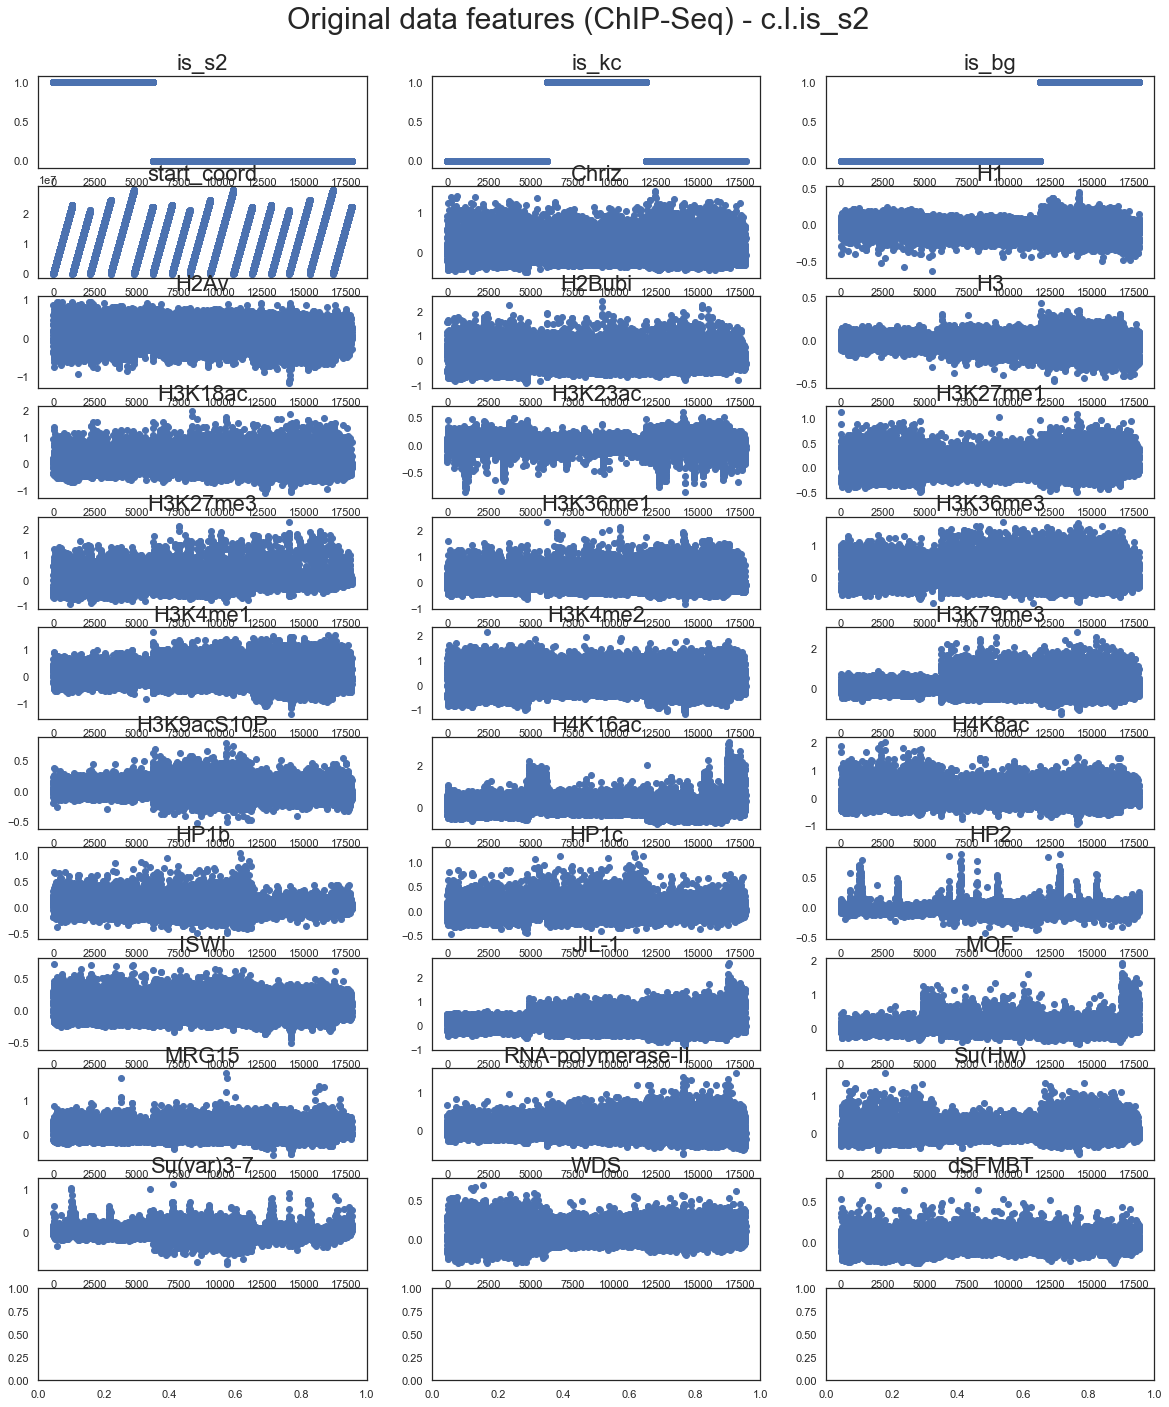

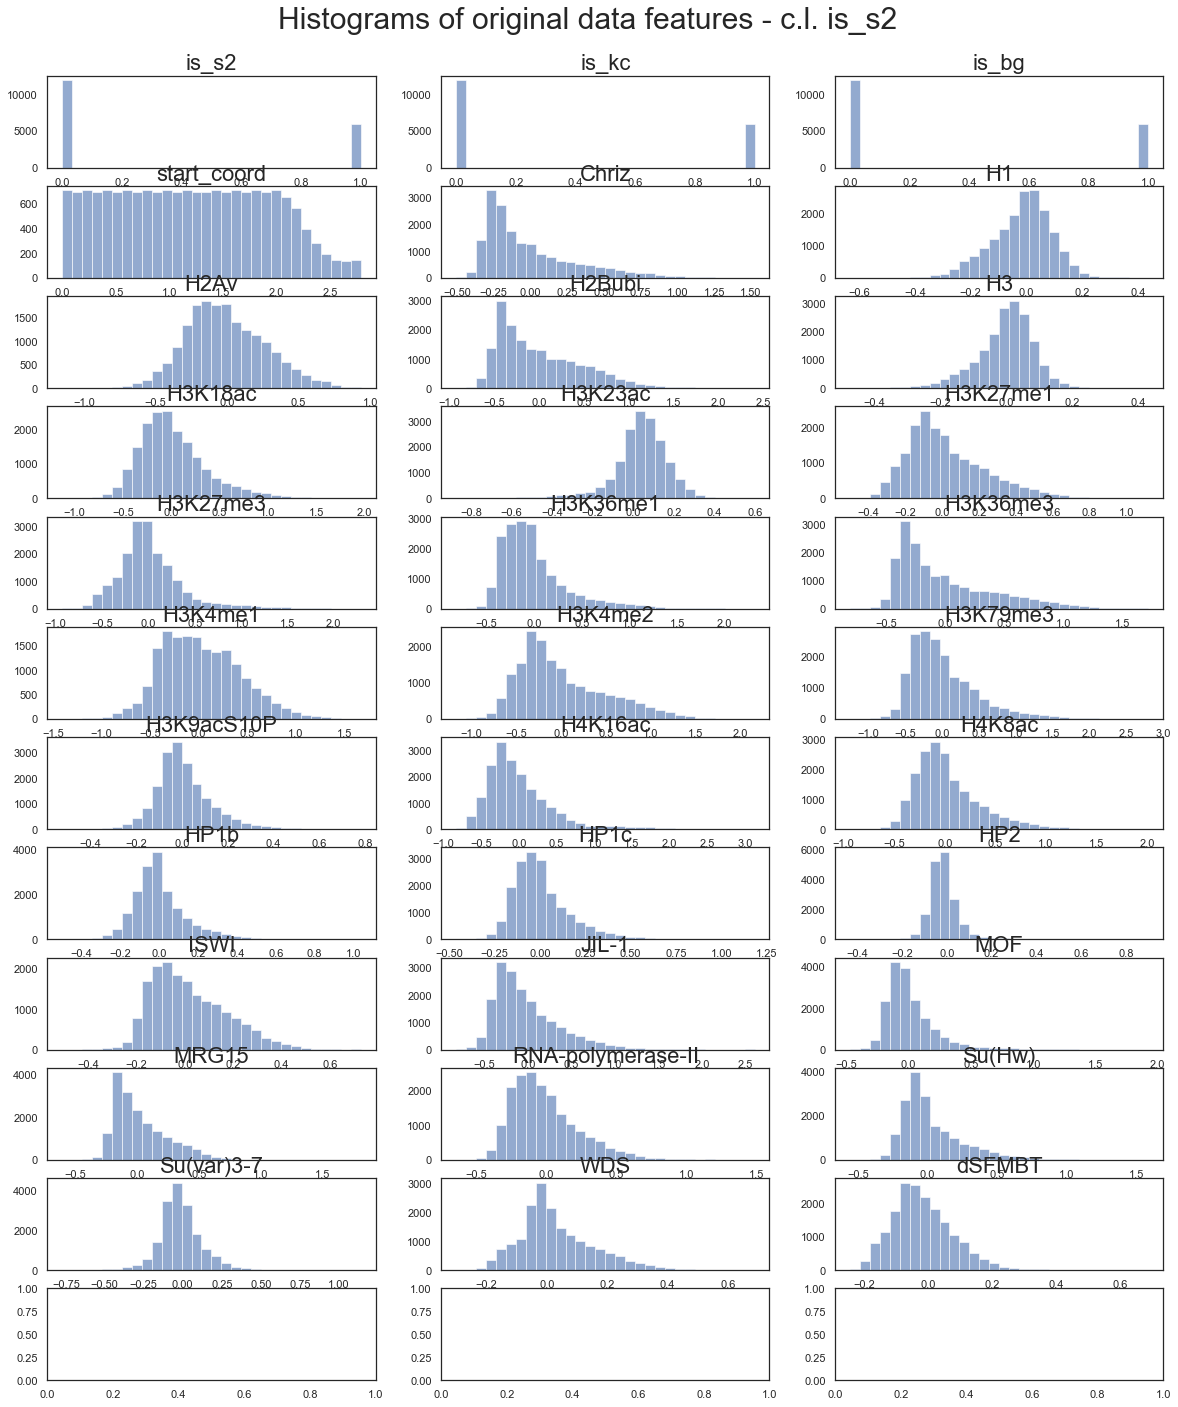

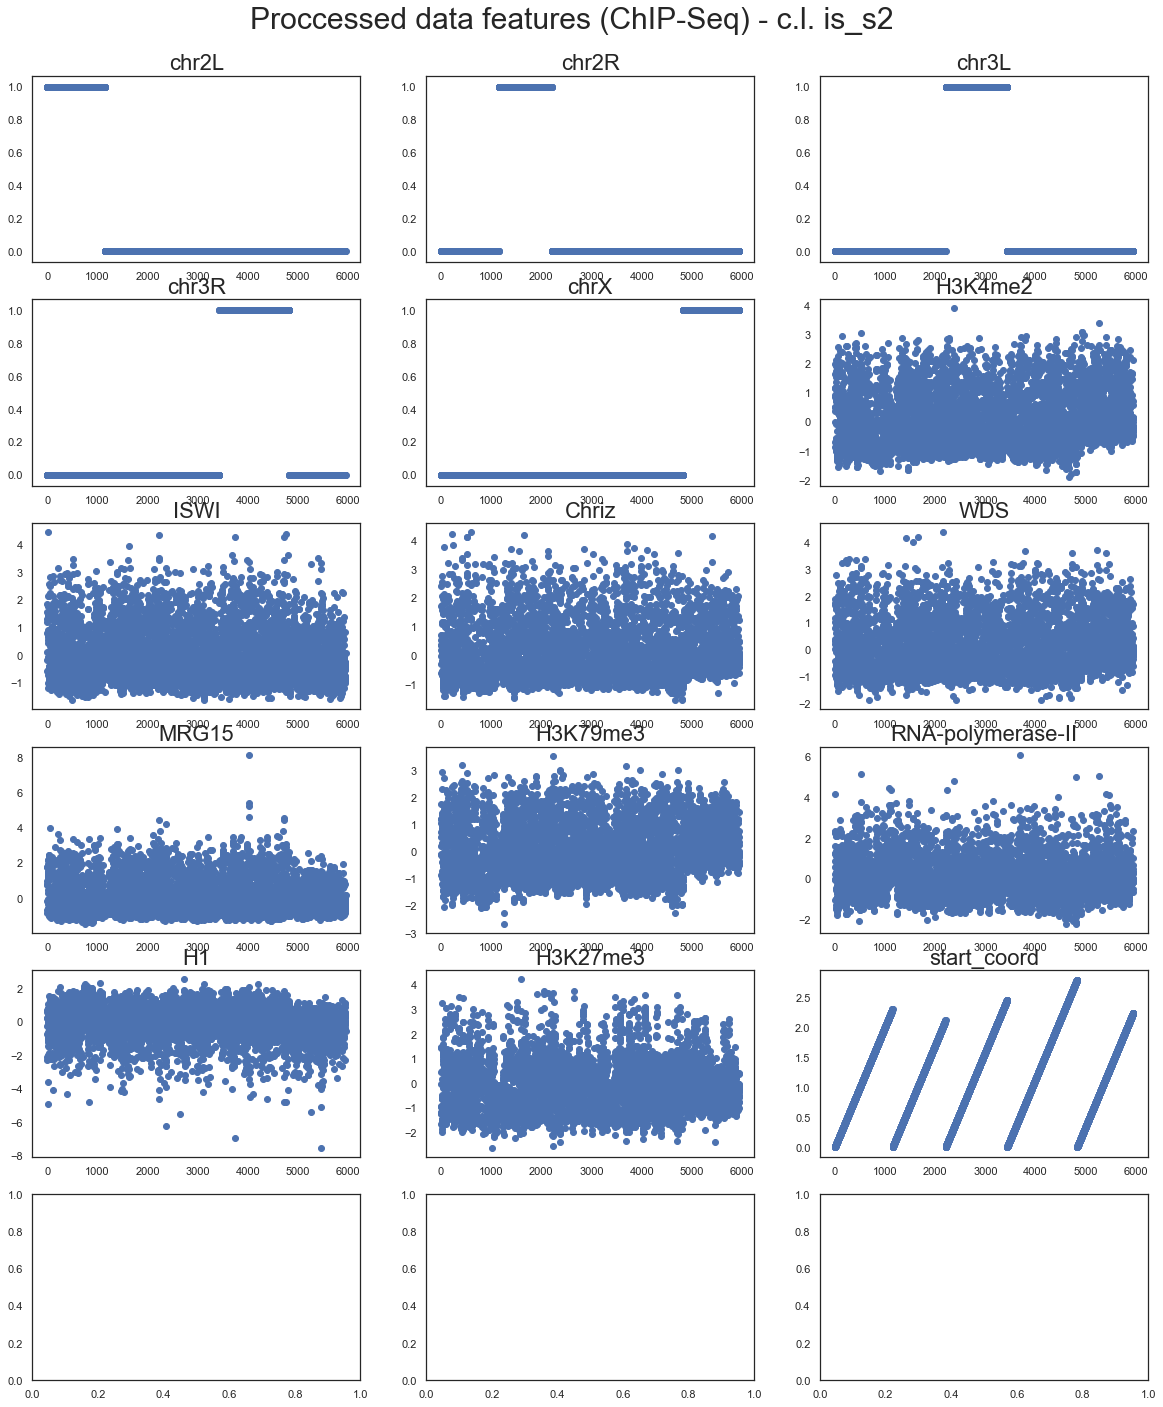

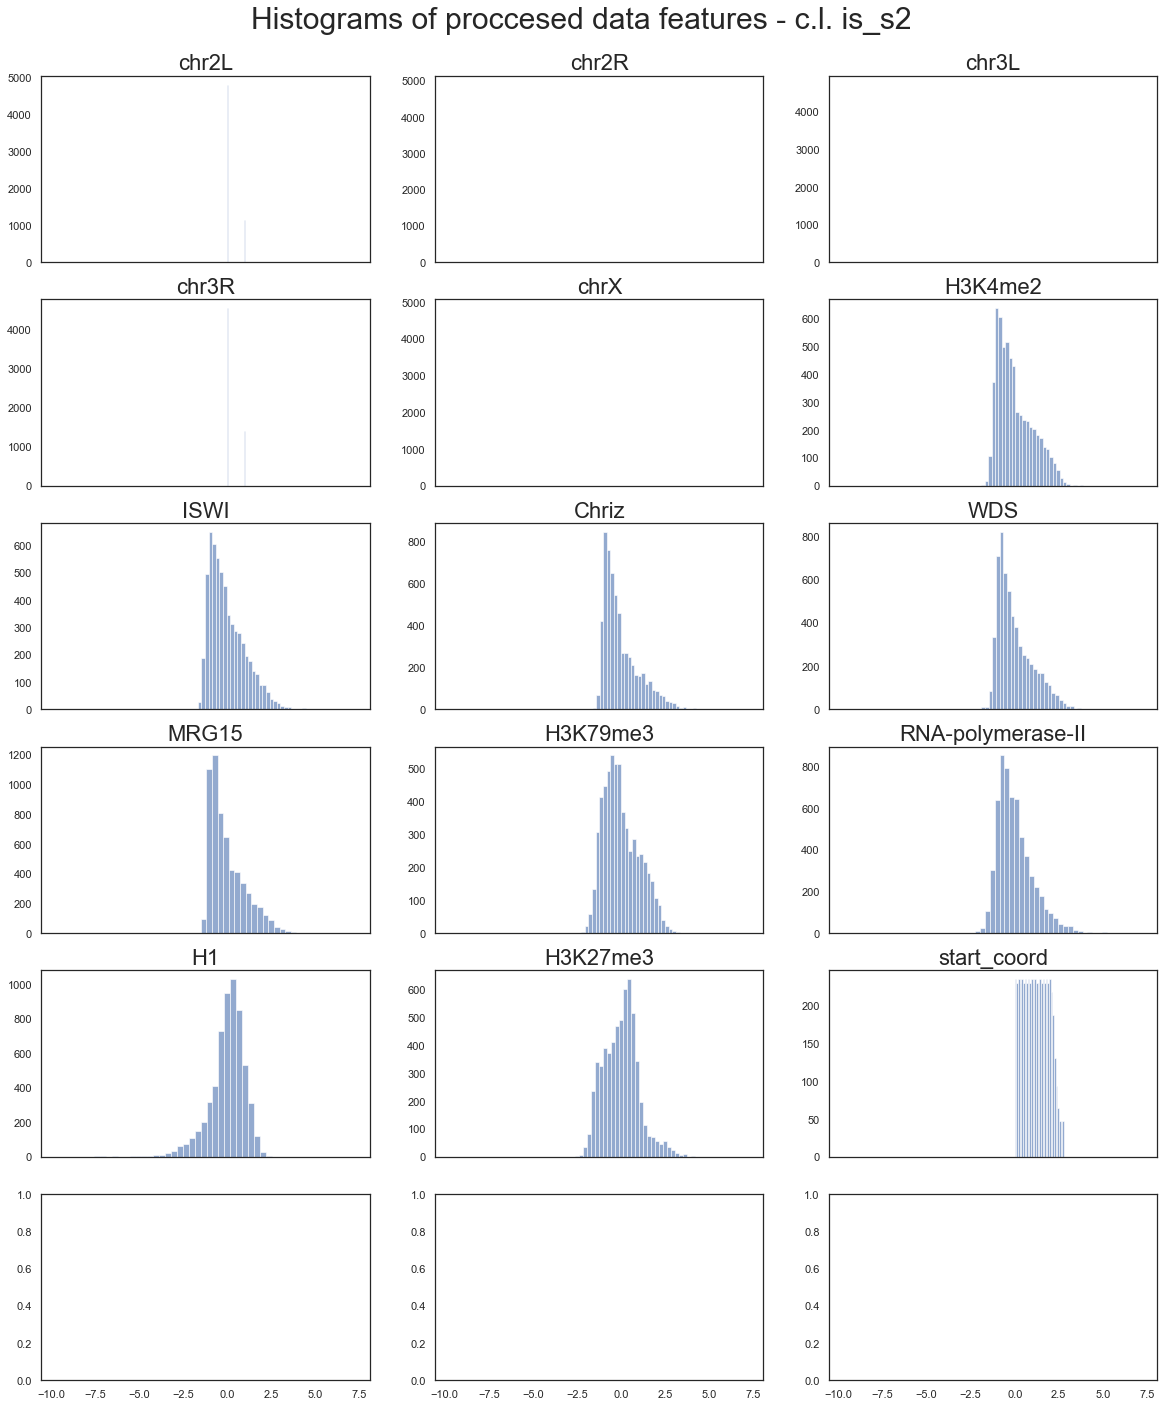

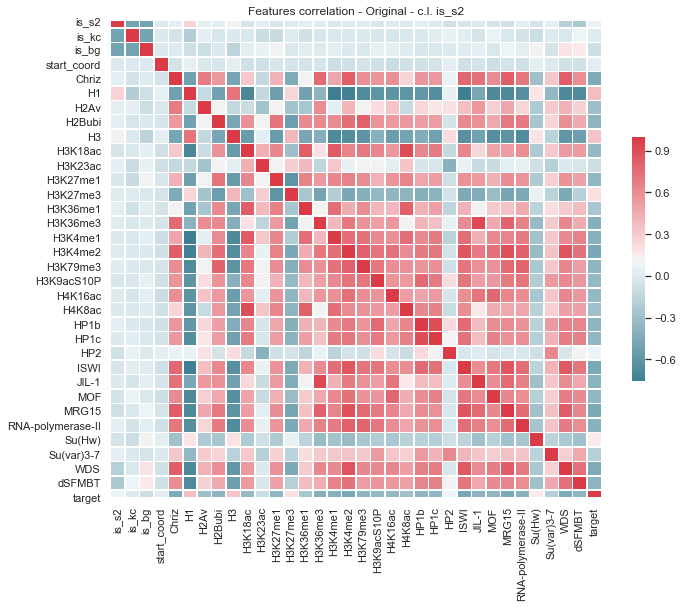

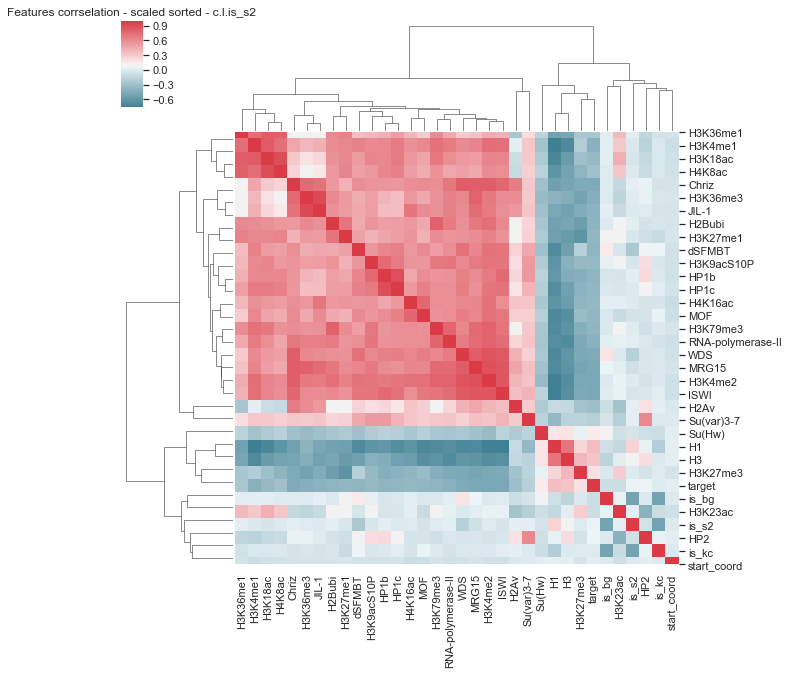

is_s2                0.068995
is_kc                0.006377
is_bg               -0.075372
start_coord          0.036987
Chriz               -0.447513
H1                   0.368121
H2Av                -0.305448
H2Bubi              -0.376450
H3                   0.337213
H3K18ac             -0.333723
H3K23ac             -0.080334
H3K27me1            -0.358176
H3K27me3             0.206352
H3K36me1            -0.247128
H3K36me3            -0.413217
H3K4me1             -0.406032
H3K4me2             -0.467798
H3K79me3            -0.374167
H3K9acS10P          -0.339806
H4K16ac             -0.342435
H4K8ac              -0.287738
HP1b                -0.371539
HP1c                -0.358979
HP2                  0.076845
ISWI                -0.469752
JIL-1               -0.394342
MOF                 -0.359221
MRG15               -0.461165
RNA-polymerase-II   -0.400547
Su(Hw)               0.161442
Su(var)3-7          -0.187351
WDS                 -0.449091
dSFMBT              -0.372893
target    

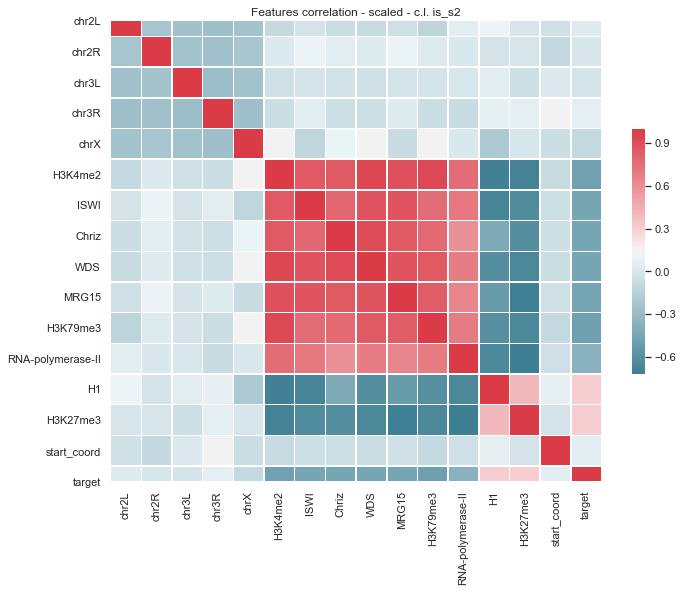

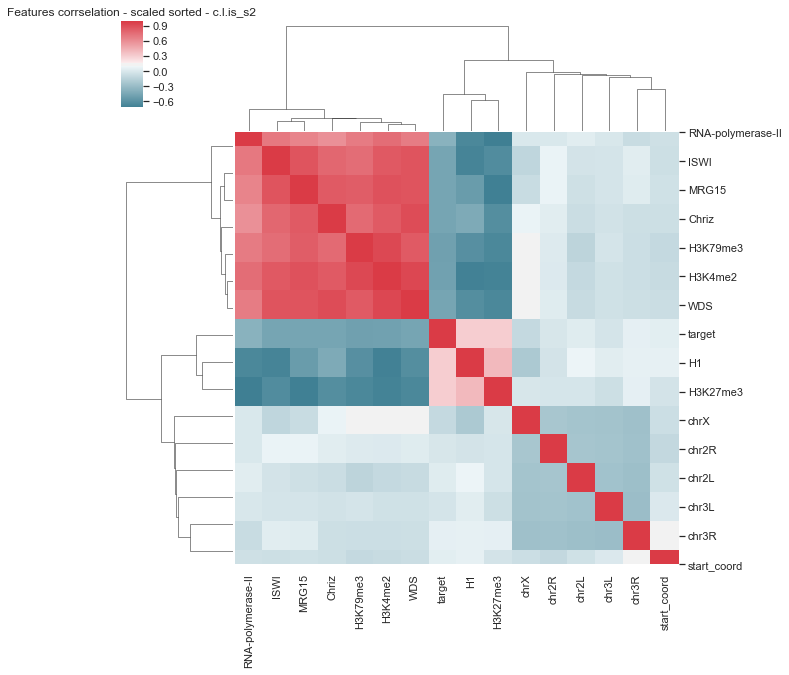

chr2L                0.040893
chr2R               -0.001248
chr3L               -0.016377
chr3R                0.063608
chrX                -0.092044
H3K4me2             -0.478476
ISWI                -0.450137
Chriz               -0.449578
WDS                 -0.453064
MRG15               -0.453526
H3K79me3            -0.485059
RNA-polymerase-II   -0.367820
H1                   0.313379
H3K27me3             0.314305
start_coord          0.051515
target               1.000000
Name: target, dtype: float64 Index(['H3K79me3', 'H3K4me2', 'MRG15', 'WDS', 'ISWI', 'Chriz',
       'RNA-polymerase-II', 'chrX', 'chr3L', 'chr2R', 'chr2L', 'start_coord',
       'chr3R', 'H1', 'H3K27me3', 'target'],
      dtype='object')
X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00031: early stopping
du

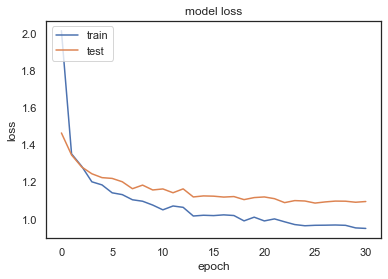

TEST WMSE =  0.9354240435425105
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00041: early stopping
duration: 22.251281023025513


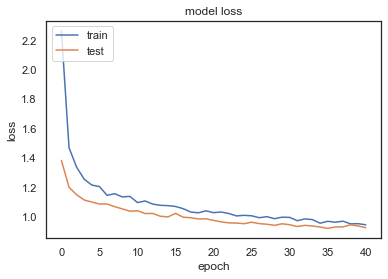

TEST WMSE =  0.7860370700756696
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00035: early stopping
duration: 20.567936897277832


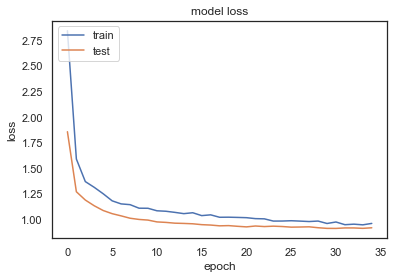

TEST WMSE =  0.785605214697291
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00030: early stopping
duration: 17.55422806739807


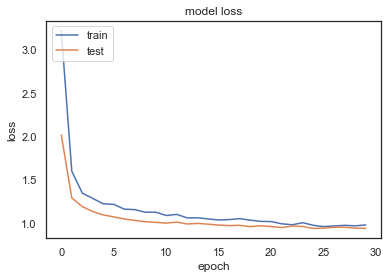

TEST WMSE =  0.8330404679866884
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00035: early stopping
duration: 19.573340892791748


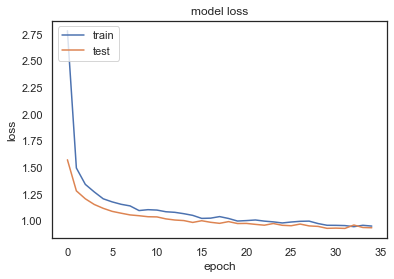

TEST WMSE =  0.9231018301306958
TEST MEAN WMSE =  0.9231018301306958


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:

    
data_csv = "_example_results_18_bioset_10_exps_23_04_20.csv"

num_experements = 1

cell_line = 'is_s2' #  'all' #  'is_bg' # 'all' # 'is_s2' # cell_line one of: 'is_s2', 'is_kc', 'is_bg',  or 'all'

bioset = None  # bioset: defines the biological features to use. 
               #  If bioset is None, use all availible features
bioset = [ 
    'H3K4me2', 
    'ISWI',
    'Chriz',
    'WDS', 
    'MRG15',
    'H3K79me3', 
    'RNA-polymerase-II',
    'H1', 
    'H3K27me3',
    'is_s2', 'is_kc', 'is_bg', 
    'chrN', 
    'start_coord',
  ]


data_path_18features = '../../data/epigenetics/s2_kc_bg_scaled_18_features.csv'
data_path_35features = '../../data/epigenetics/s2_kc_bg_scaled_34_overlap_features_2901.csv'
data_path = data_path_35features

target_path = "../../data/target/s2_kc_bg_clean_gamma_2901.csv"
index_col = 0

random_state = 16 # None  # Shuffle the data splittings
batch_size = 60 
sequenc_len_list =  [6]
num_lstm_units = 64 
n_epochs_max = 364 
num_folds = 5
file_path = "./exps" + data_csv
use_chr_onehotenc = True
use_coord_scale = True

eval_models_df_1_10x_5f, eval_models_df_drop_10x_5f, eval_models_df_together_10x_5f, \
            mean_together_10x_5f, std_together_10x_5f, feature_score_1, feature_score_drop, \
            data_scaled_clean, target_clean, = main_analysis(data_path,  
                                                       cell_line, 
                                                       bioset, 
                                                       num_experements,
                                                       sequenc_len_list = [6], 
                                                       num_lstm_units = 6,
                                                       num_folds = num_folds,
                                                       batch_size = batch_size,
                                                       do_only_1_feature_exps = False, 
                                                       do_drop_1_feature_exps = False,
                                                       do_all_together = True,
                                                       use_chr_onehotenc = use_chr_onehotenc,
                                                       use_coord_scale=use_coord_scale,
                                                       verbose=True)


In [22]:
eval_models_df_together_10x_5f

exper_num  sequenc_len  num_lstm_units  n_epochs  weighted_mse_test  \
0         0          6.0             6.0  31.00000           0.935424   
1         0          6.0             6.0  41.00000           0.786037   
2         0          6.0             6.0  35.00000           0.785605   
3         0          6.0             6.0  30.00000           0.833040   
4         0          6.0             6.0  35.00000           0.923102   
5      mean          6.0             6.0  34.40000           0.852642   
6       std          0.0             0.0   3.91561           0.056807   

   weighted_mse_train  weighted_mse_val  weighted_mse_test_const  batch_size  \
0            0.857891          1.095500                 1.618290        60.0   
1            0.858982          0.926255                 1.609941        60.0   
2            0.861486          0.920972                 1.563746        60.0   
3            0.859789          0.944144                 1.517877        60.0   
4            0.855886          0.937699                 1.681724        60.0   
5            0.858807          0.964914                 1.598316        60.0   
6            0.002034          0.017226                 0.060576         0.0   

    duration  missing_feature  
0  18.708523             -1.0  
1  22.251281             -1.0  
2  20.567937             -1.0  
3  17.554228             -1.0  
4  19.573341             -1.0  
5  19.731062             -1.0  
6   1.703396              0.0

data.shape =  (17850, 34)
column names = ['is_s2' 'is_kc' 'is_bg' 'chrN' 'start_coord' 'Chriz' 'H1' 'H2Av' 'H2Bubi'
 'H3' 'H3K18ac' 'H3K23ac' 'H3K27me1' 'H3K27me3' 'H3K36me1' 'H3K36me3'
 'H3K4me1' 'H3K4me2' 'H3K79me3' 'H3K9acS10P' 'H4K16ac' 'H4K8ac' 'HP1b'
 'HP1c' 'HP2' 'ISWI' 'JIL-1' 'MOF' 'MRG15' 'RNA-polymerase-II' 'Su(Hw)'
 'Su(var)3-7' 'WDS' 'dSFMBT']
Using features bioset: ['H3K4me2', 'ISWI', 'Chriz', 'WDS', 'MRG15', 'H3K79me3', 'RNA-polymerase-II', 'H1', 'H3K27me3', 'is_s2', 'is_kc', 'is_bg', 'chrN', 'start_coord']
Using cell line: is_s2
Scaling of the features: Index(['H3K4me2', 'ISWI', 'Chriz', 'WDS', 'MRG15', 'H3K79me3',
       'RNA-polymerase-II', 'H1', 'H3K27me3'],
      dtype='object')
Using chromosome One Hot Encoding: ['chr2L' 'chr2R' 'chr3L' 'chr3R' 'chrX']
proccessed data.shape = (5950, 15)
original target.shape = (17850, 6)
target.columns = Index(['is_s2', 'is_kc', 'is_bg', 'chrN', 'start_coord', 'gamma'], dtype='object')
target.shape = (5950, 3)
target.column = Index

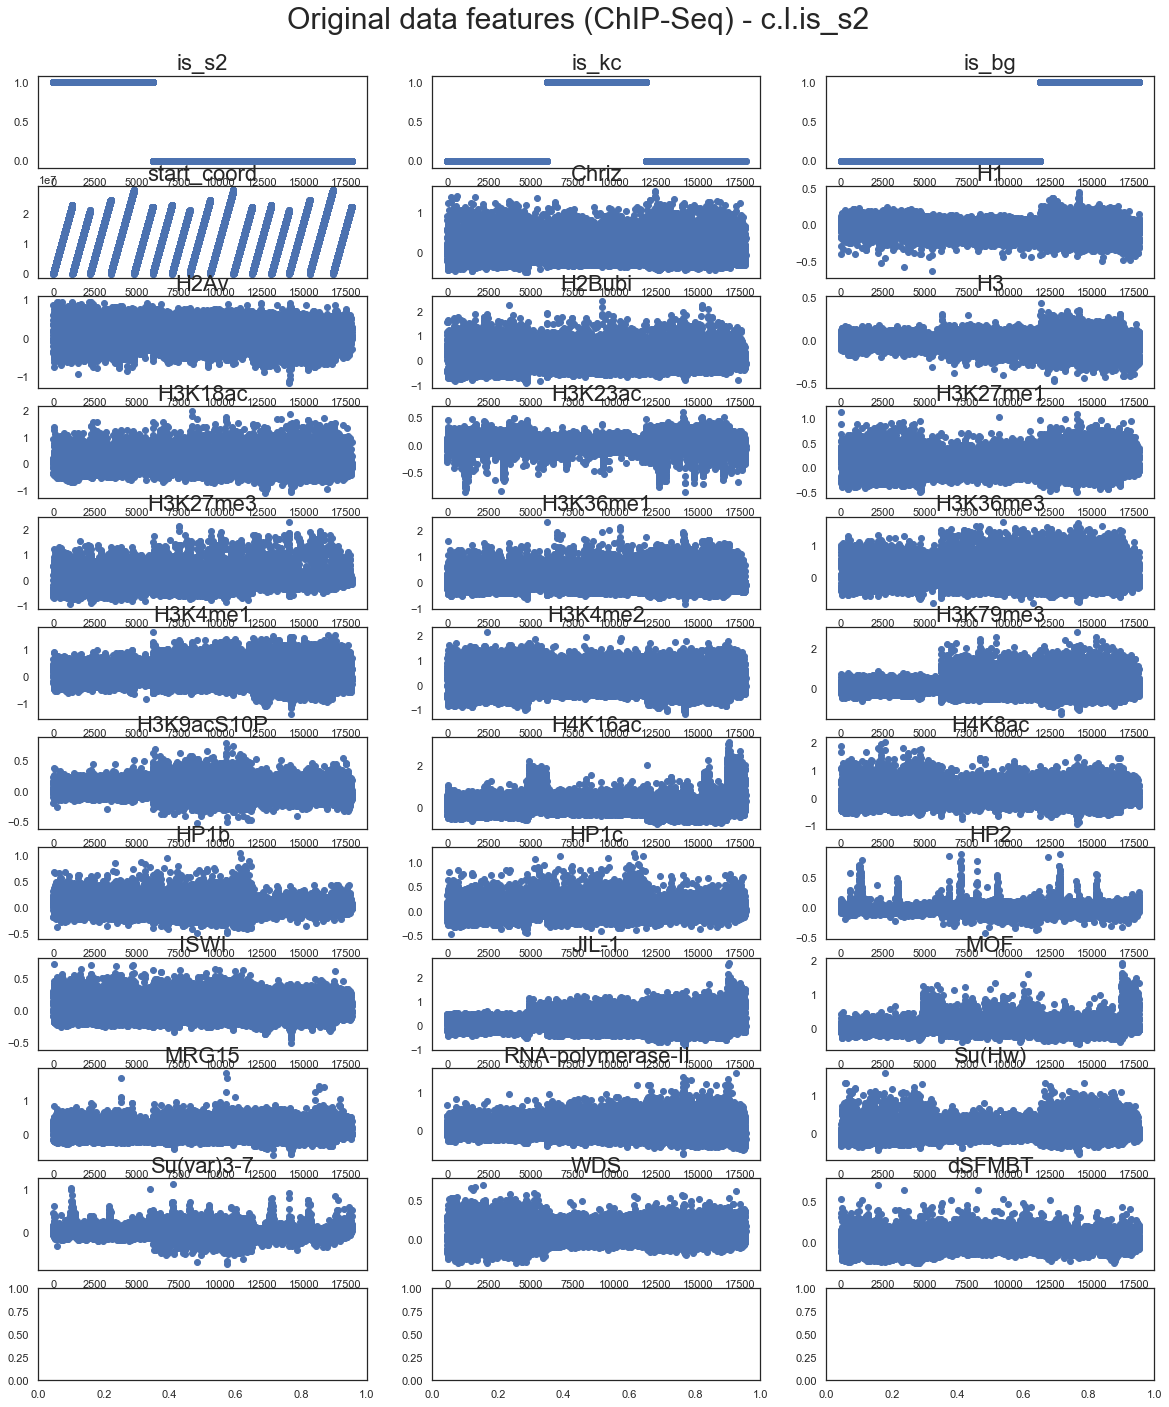

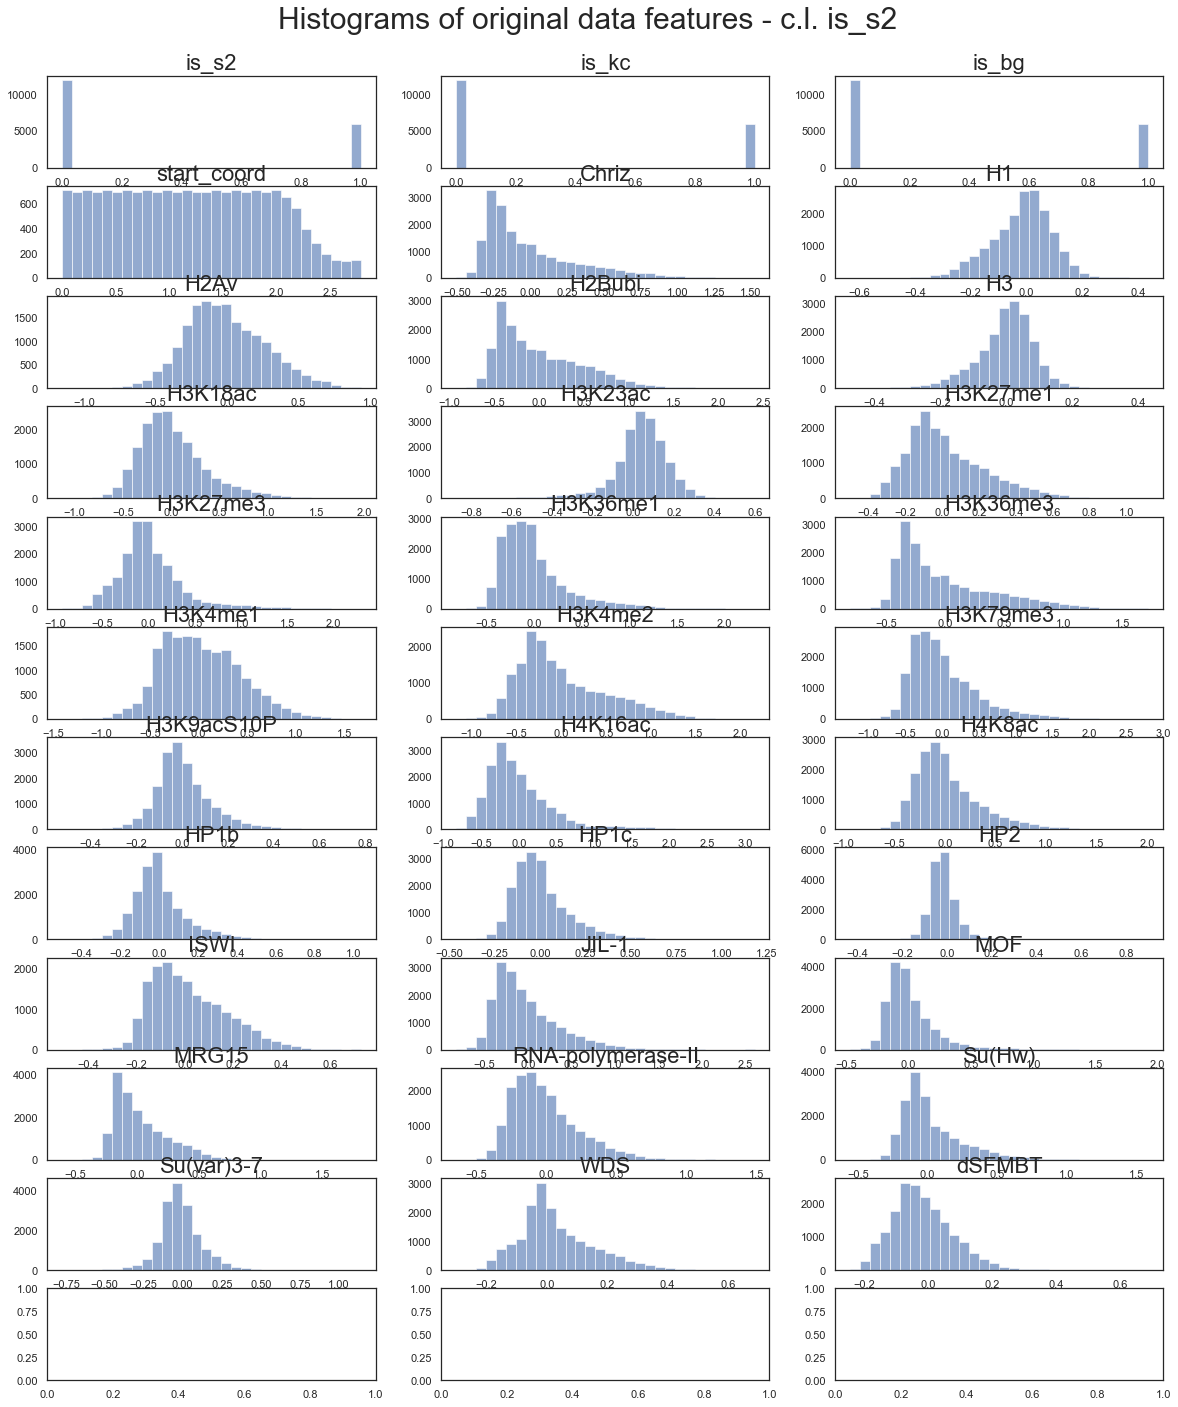

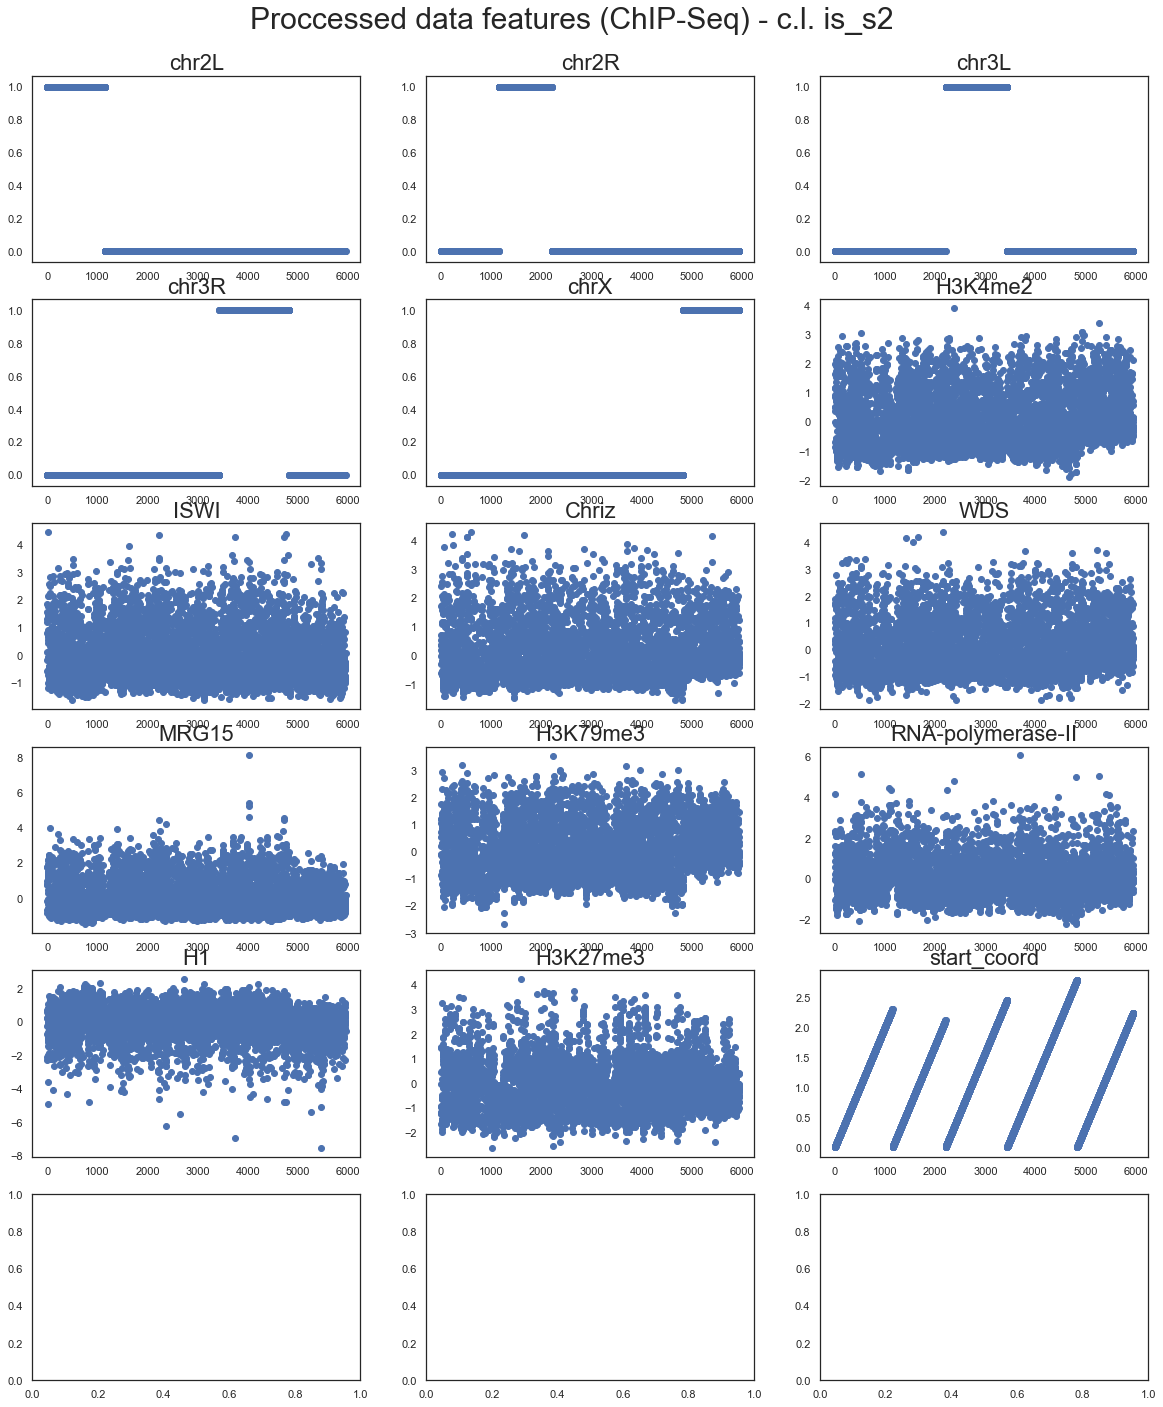

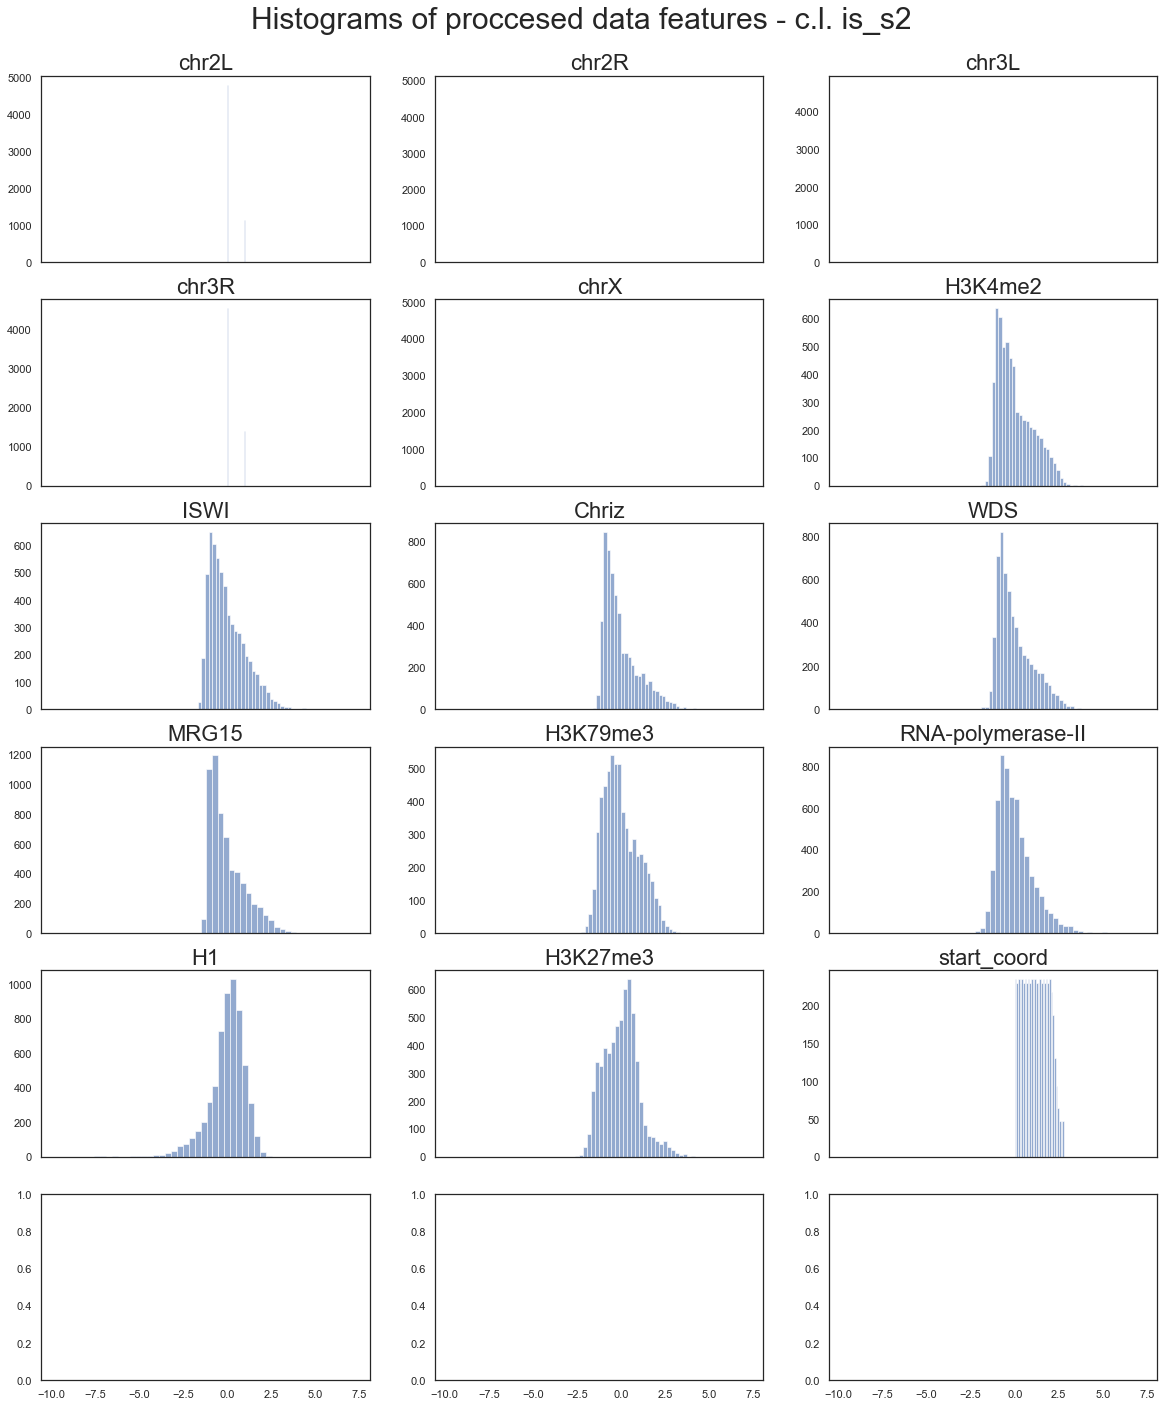

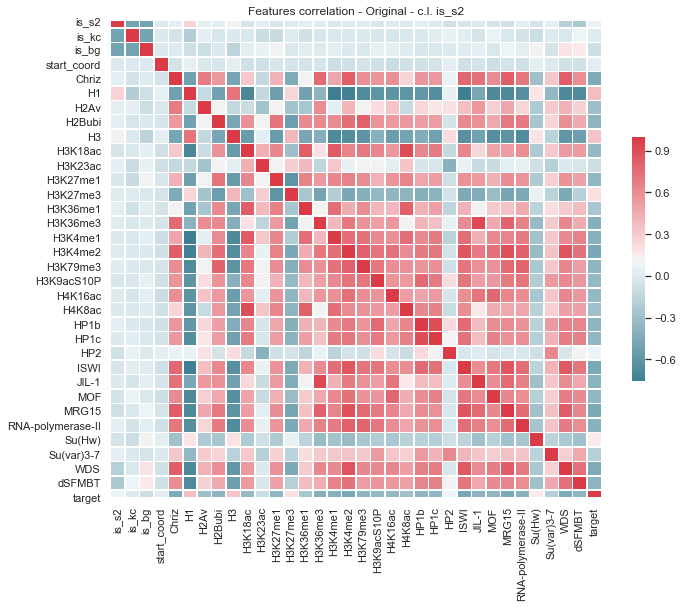

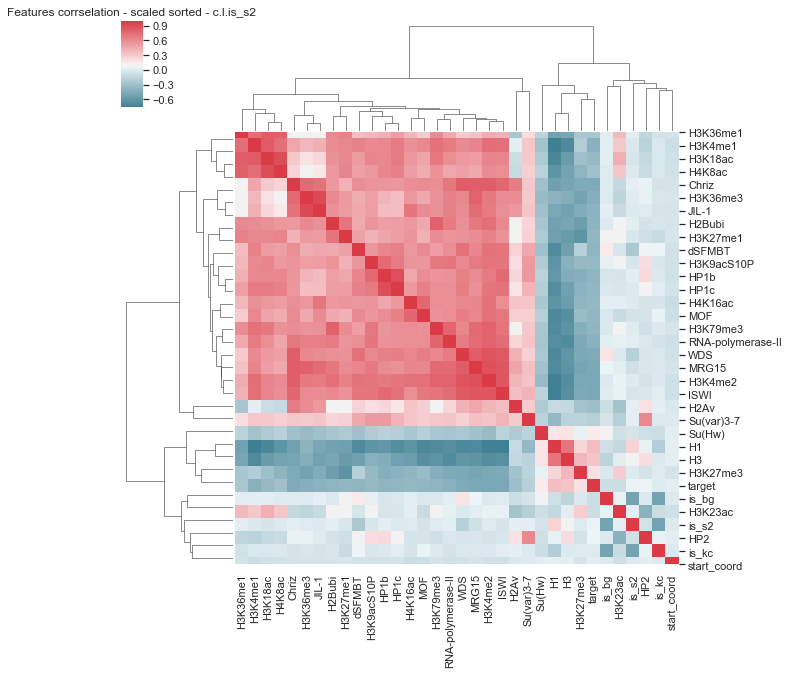

is_s2                0.068995
is_kc                0.006377
is_bg               -0.075372
start_coord          0.036987
Chriz               -0.447513
H1                   0.368121
H2Av                -0.305448
H2Bubi              -0.376450
H3                   0.337213
H3K18ac             -0.333723
H3K23ac             -0.080334
H3K27me1            -0.358176
H3K27me3             0.206352
H3K36me1            -0.247128
H3K36me3            -0.413217
H3K4me1             -0.406032
H3K4me2             -0.467798
H3K79me3            -0.374167
H3K9acS10P          -0.339806
H4K16ac             -0.342435
H4K8ac              -0.287738
HP1b                -0.371539
HP1c                -0.358979
HP2                  0.076845
ISWI                -0.469752
JIL-1               -0.394342
MOF                 -0.359221
MRG15               -0.461165
RNA-polymerase-II   -0.400547
Su(Hw)               0.161442
Su(var)3-7          -0.187351
WDS                 -0.449091
dSFMBT              -0.372893
target    

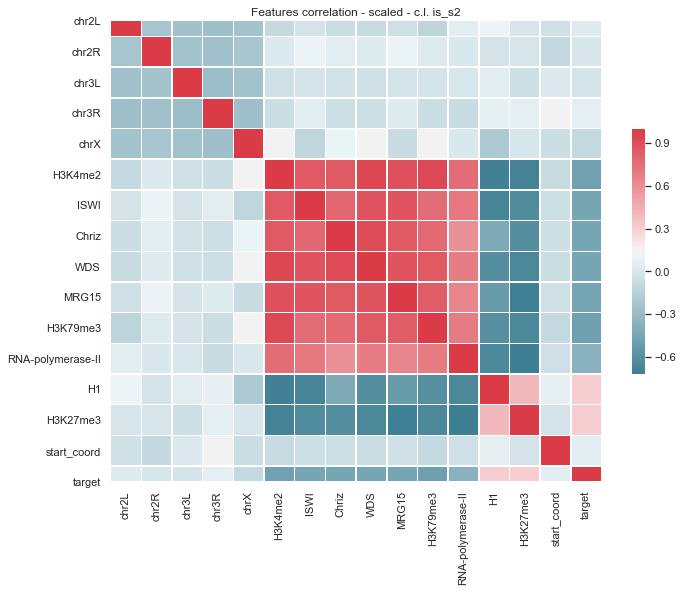

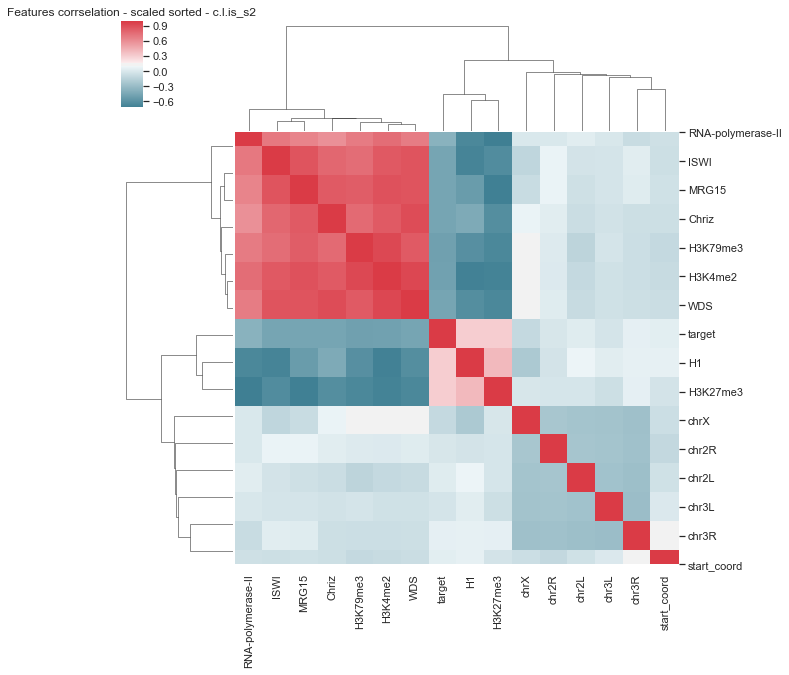

chr2L                0.040893
chr2R               -0.001248
chr3L               -0.016377
chr3R                0.063608
chrX                -0.092044
H3K4me2             -0.478476
ISWI                -0.450137
Chriz               -0.449578
WDS                 -0.453064
MRG15               -0.453526
H3K79me3            -0.485059
RNA-polymerase-II   -0.367820
H1                   0.313379
H3K27me3             0.314305
start_coord          0.051515
target               1.000000
Name: target, dtype: float64 Index(['H3K79me3', 'H3K4me2', 'MRG15', 'WDS', 'ISWI', 'Chriz',
       'RNA-polymerase-II', 'chrX', 'chr3L', 'chr2R', 'chr2L', 'start_coord',
       'chr3R', 'H1', 'H3K27me3', 'target'],
      dtype='object')

-----
 DROP FEATURE NUMBER -- 0
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... 

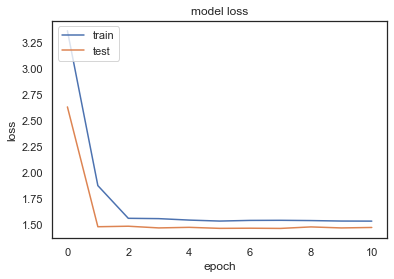

TEST WMSE =  1.6600668538803014
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00012: early stopping
duration: 9.029971837997437


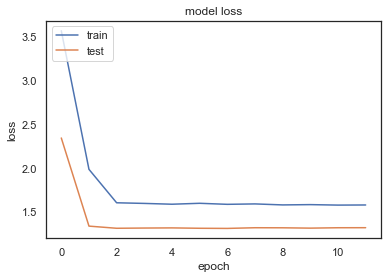

TEST WMSE =  1.453456814829921
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00012: early stopping
duration: 9.639615058898926


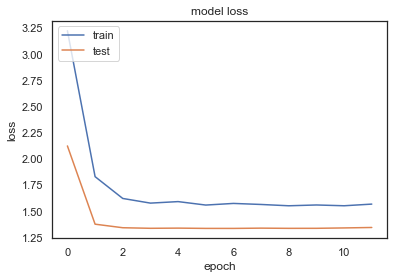

TEST WMSE =  1.480351368279748
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00014: early stopping
duration: 9.824559926986694


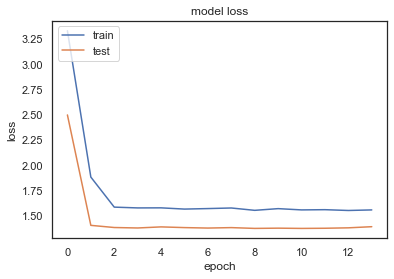

TEST WMSE =  1.4826621196134566
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00008: early stopping
duration: 7.507519960403442


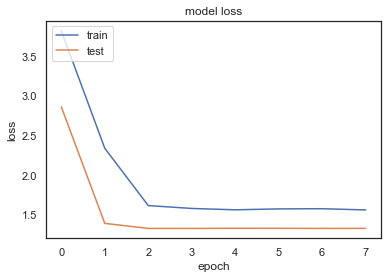

TEST WMSE =  1.5485257123353178
TEST MEAN WMSE =  1.5485257123353178


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 1
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00012: early stopping
duration: 9.036477088928223


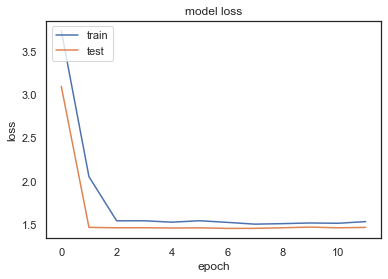

TEST WMSE =  1.661687624250128
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00010: early stopping
duration: 7.648585319519043


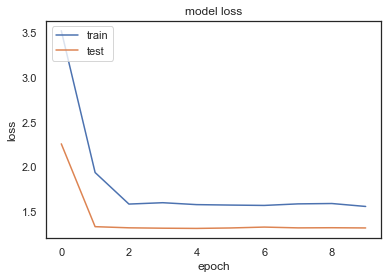

TEST WMSE =  1.4562294983365511
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00013: early stopping
duration: 9.256098985671997


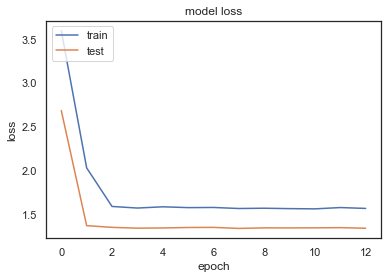

TEST WMSE =  1.4759073054463085
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 7.012377977371216


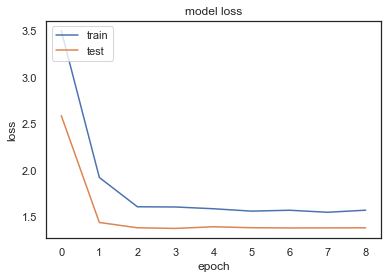

TEST WMSE =  1.4745633460420302
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00010: early stopping
duration: 7.697879076004028


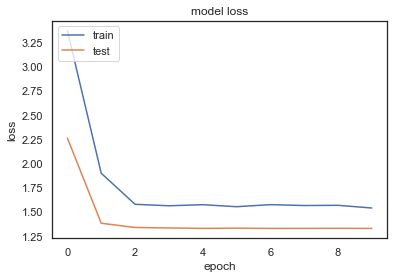

TEST WMSE =  1.5535338042984577
TEST MEAN WMSE =  1.5535338042984577


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 2
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00012: early stopping
duration: 8.66063117980957


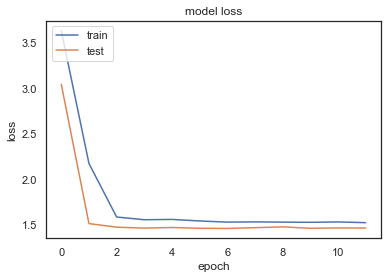

TEST WMSE =  1.6549267003738188
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 6.568645715713501


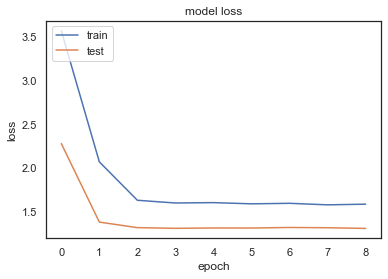

TEST WMSE =  1.459651032139859
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 7.7532689571380615


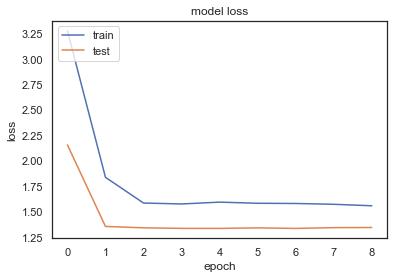

TEST WMSE =  1.4784438440610679
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00008: early stopping
duration: 6.6509199142456055


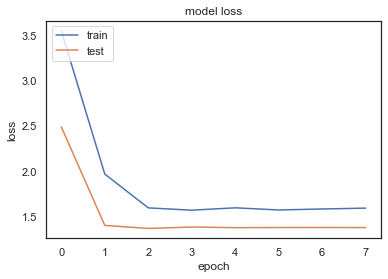

TEST WMSE =  1.4721857064589505
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 7.312302112579346


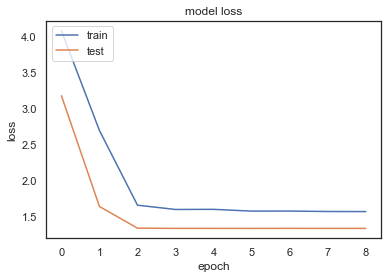

TEST WMSE =  1.5536514429951844
TEST MEAN WMSE =  1.5536514429951844


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 3
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00016: early stopping
duration: 10.10663890838623


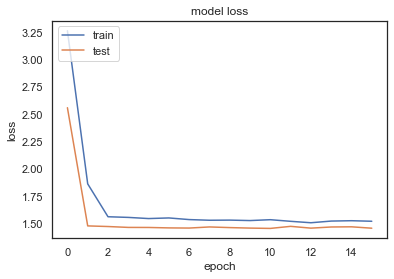

TEST WMSE =  1.638286545732514
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00013: early stopping
duration: 9.038683891296387


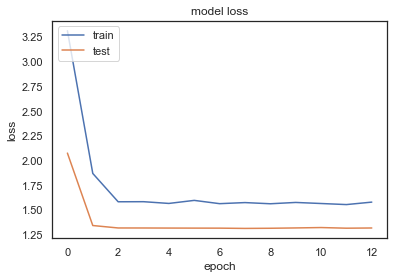

TEST WMSE =  1.4531172678743869
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00011: early stopping
duration: 8.058698177337646


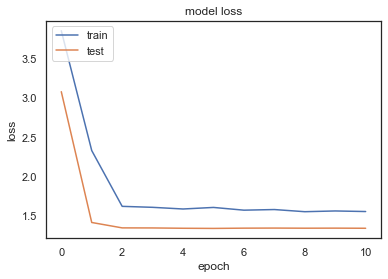

TEST WMSE =  1.4744151373271228
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00012: early stopping
duration: 8.232608795166016


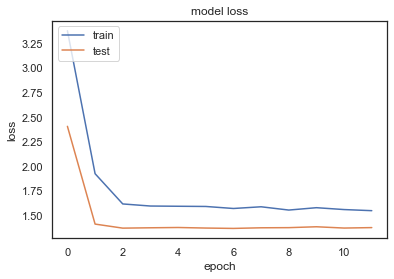

TEST WMSE =  1.4726153432309104
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 7.086516857147217


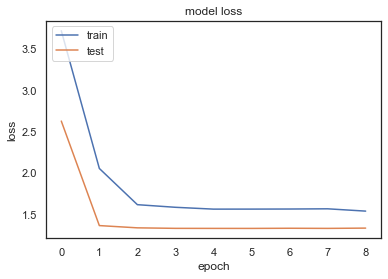

TEST WMSE =  1.5463488431265942
TEST MEAN WMSE =  1.5463488431265942


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 4
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00017: early stopping
duration: 10.378891944885254


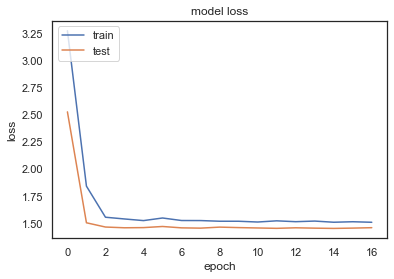

TEST WMSE =  1.649387487606771
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00009: early stopping
duration: 6.911405801773071


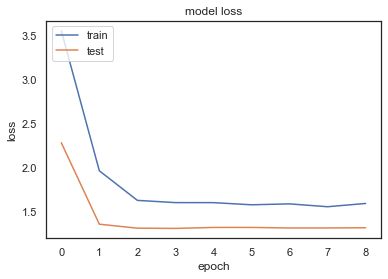

TEST WMSE =  1.4492698395190242
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00008: early stopping
duration: 6.602558135986328


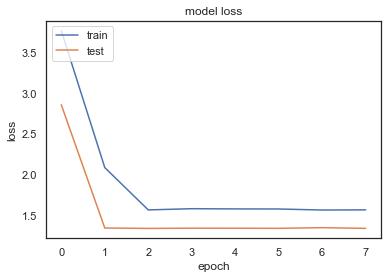

TEST WMSE =  1.4766637070895798
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00013: early stopping
duration: 8.76075005531311


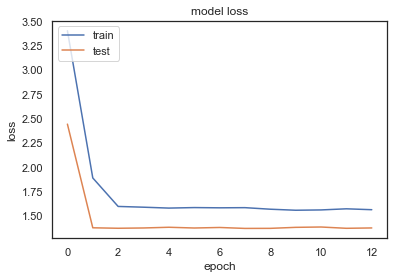

TEST WMSE =  1.4678995838929838
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00008: early stopping
duration: 6.714762926101685


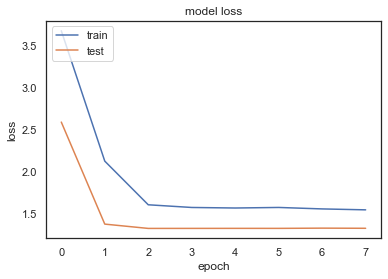

TEST WMSE =  1.5435667462557043
TEST MEAN WMSE =  1.5435667462557043


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 5
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00044: early stopping
duration: 22.093805074691772


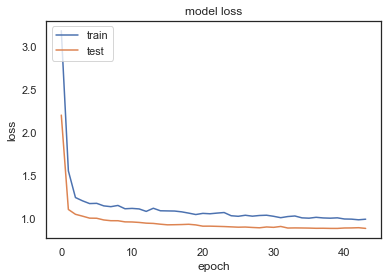

TEST WMSE =  1.1147779138175407
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00062: early stopping
duration: 26.781222820281982


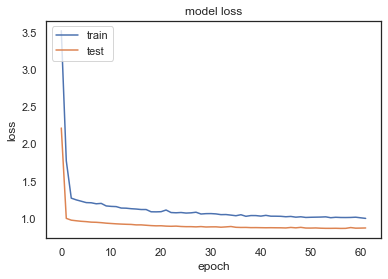

TEST WMSE =  0.9042293547358518
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00052: early stopping
duration: 22.143769025802612


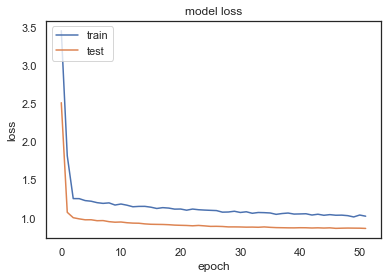

TEST WMSE =  0.9172877417114251
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00042: early stopping
duration: 18.811142206192017


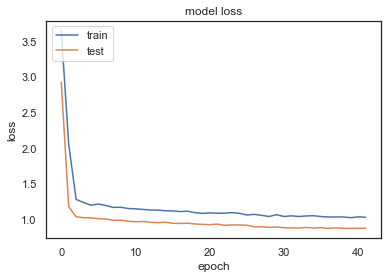

TEST WMSE =  0.9475633994703269
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00066: early stopping
duration: 27.29037880897522


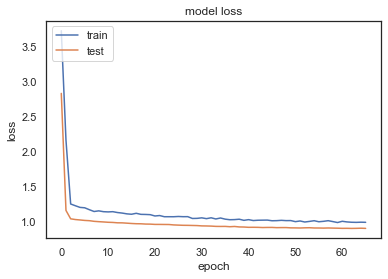

TEST WMSE =  1.0244154282346818
TEST MEAN WMSE =  1.0244154282346818


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 6
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00050: early stopping
duration: 22.4532790184021


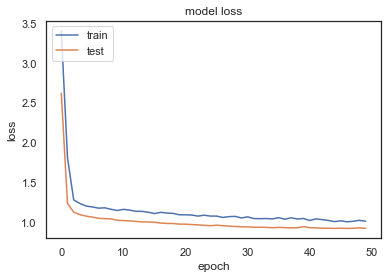

TEST WMSE =  1.1488791182170857
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00068: early stopping
duration: 27.935513734817505


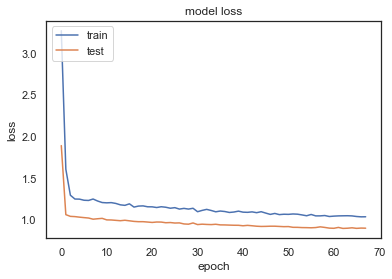

TEST WMSE =  0.964820234814884
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00026: early stopping
duration: 12.791458129882812


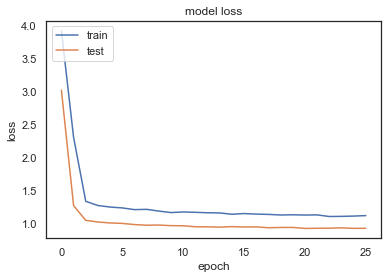

TEST WMSE =  0.969621519982171
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00047: early stopping
duration: 20.698890924453735


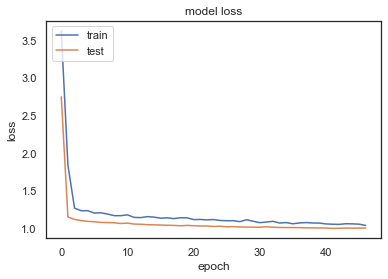

TEST WMSE =  0.9863935686368417
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00060: early stopping
duration: 25.37545084953308


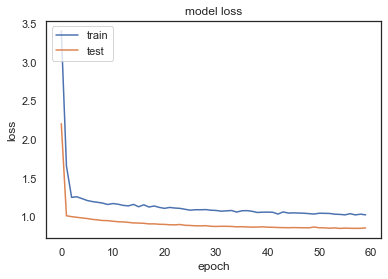

TEST WMSE =  1.0448814090666245
TEST MEAN WMSE =  1.0448814090666245


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 7
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00071: early stopping
duration: 29.102671146392822


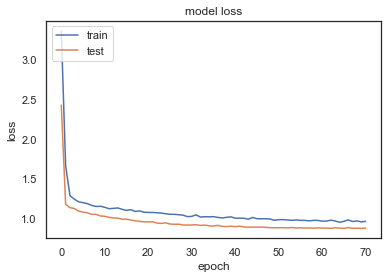

TEST WMSE =  1.1168105991702086
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00054: early stopping
duration: 22.33202314376831


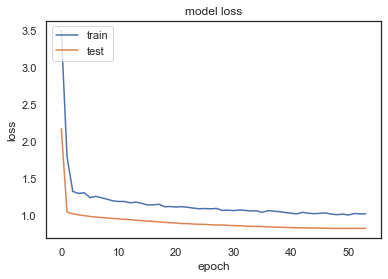

TEST WMSE =  0.9368922106298453
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00033: early stopping
duration: 14.76979684829712


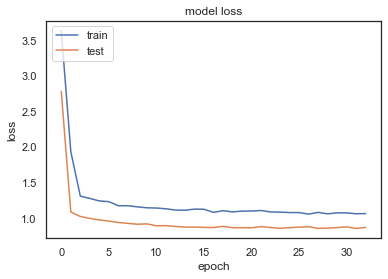

TEST WMSE =  0.9380601314965809
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00051: early stopping
duration: 21.550186157226562


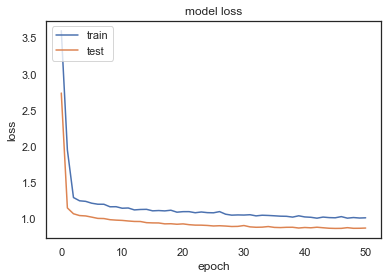

TEST WMSE =  0.9286980702517091
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00060: early stopping
duration: 25.462255239486694


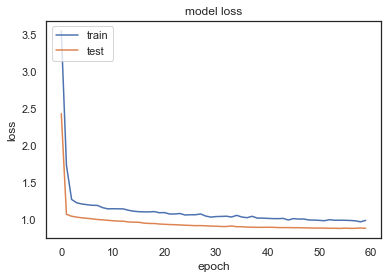

TEST WMSE =  1.0347232008506557
TEST MEAN WMSE =  1.0347232008506557


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 8
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00043: early stopping
duration: 22.991930961608887


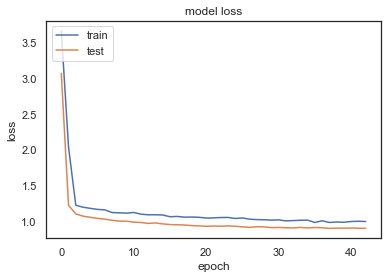

TEST WMSE =  1.1385763917163896
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00059: early stopping
duration: 30.07842707633972


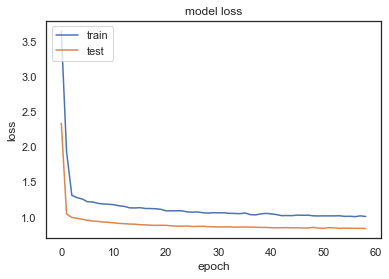

TEST WMSE =  0.9201665558986701
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00047: early stopping
duration: 23.178335905075073


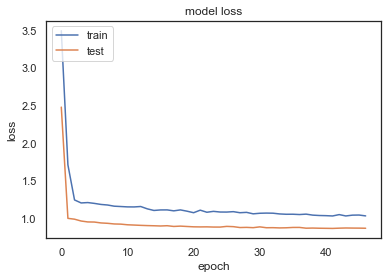

TEST WMSE =  0.9171261874555477
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00044: early stopping
duration: 22.15510606765747


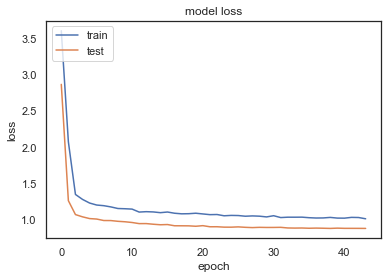

TEST WMSE =  0.9273245112691388
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00044: early stopping
duration: 22.544681310653687


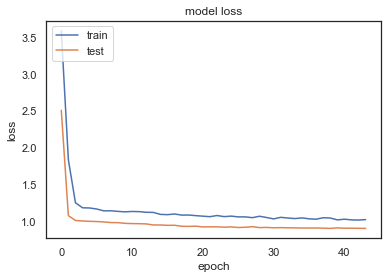

TEST WMSE =  1.0296994047051777
TEST MEAN WMSE =  1.0296994047051777


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 9
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00045: early stopping
duration: 24.03309416770935


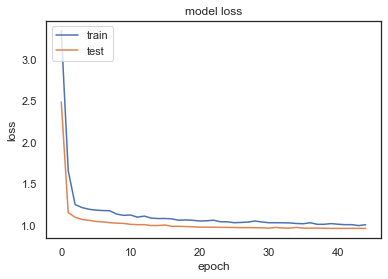

TEST WMSE =  1.1390333807486295
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00053: early stopping
duration: 26.413438081741333


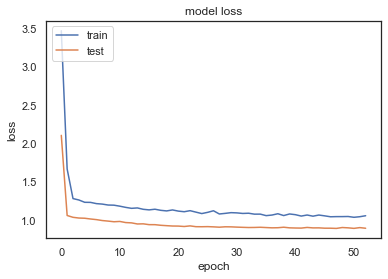

TEST WMSE =  0.9531658552717133
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00039: early stopping
duration: 20.004889011383057


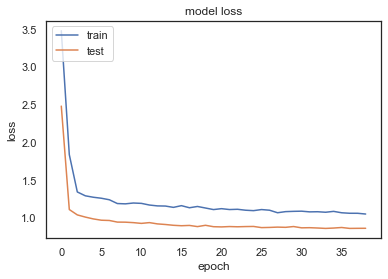

TEST WMSE =  0.9307470734510126
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00080: early stopping
duration: 41.093114137649536


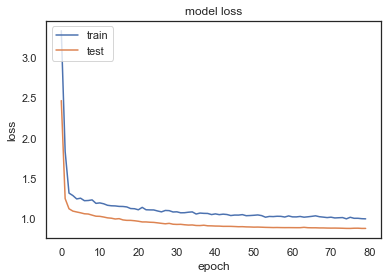

TEST WMSE =  0.9486368277610441
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00075: early stopping
duration: 39.99575996398926


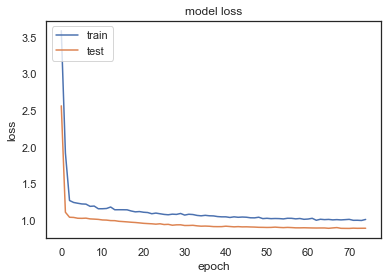

TEST WMSE =  1.0514199086998923
TEST MEAN WMSE =  1.0514199086998923


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 10
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00057: early stopping
duration: 31.070863962173462


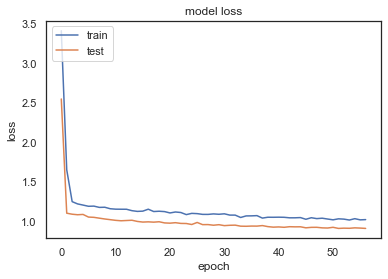

TEST WMSE =  1.1449492349822576
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00058: early stopping
duration: 27.120605945587158


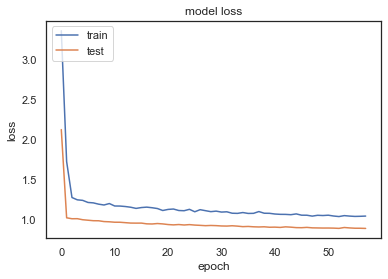

TEST WMSE =  0.944861923122652
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00054: early stopping
duration: 27.192555904388428


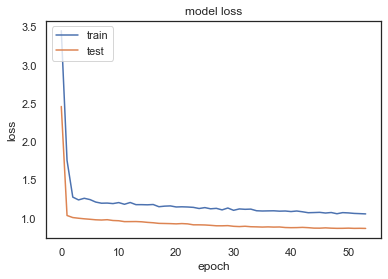

TEST WMSE =  0.9358792926090477
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00043: early stopping
duration: 22.6219961643219


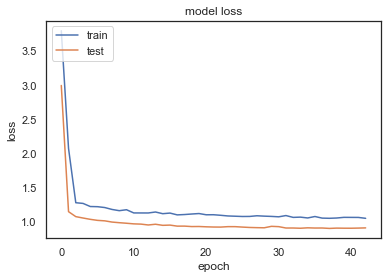

TEST WMSE =  0.9846626904297288
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00050: early stopping
duration: 25.304111003875732


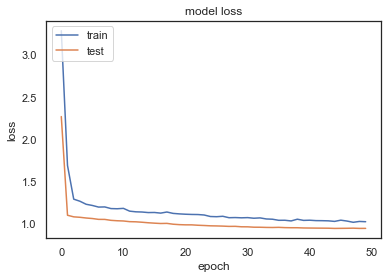

TEST WMSE =  1.0793376790121791
TEST MEAN WMSE =  1.0793376790121791


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 11
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00029: early stopping
duration: 16.047213077545166


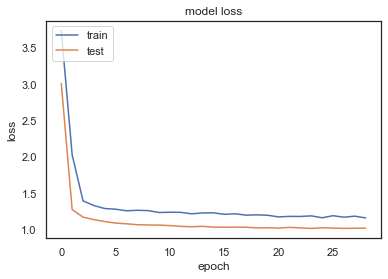

TEST WMSE =  1.2739466326435591
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00024: early stopping
duration: 13.538097858428955


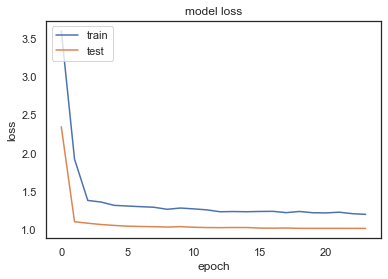

TEST WMSE =  1.070462231960189
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00046: early stopping
duration: 22.468180179595947


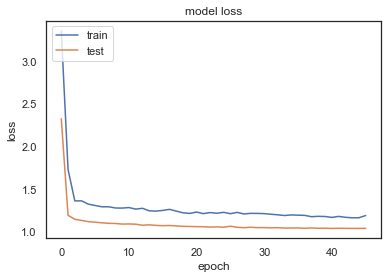

TEST WMSE =  1.0317109591928115
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00027: early stopping
duration: 17.292803049087524


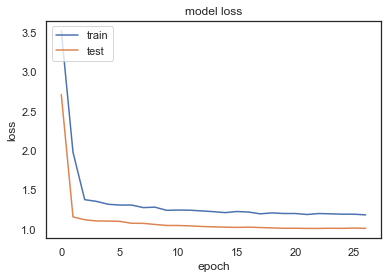

TEST WMSE =  1.091913335193208
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00050: early stopping
duration: 24.943341732025146


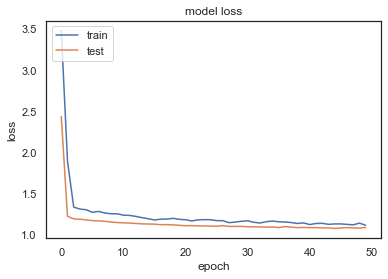

TEST WMSE =  1.192290640898437
TEST MEAN WMSE =  1.192290640898437


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 12
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00047: early stopping
duration: 24.425336837768555


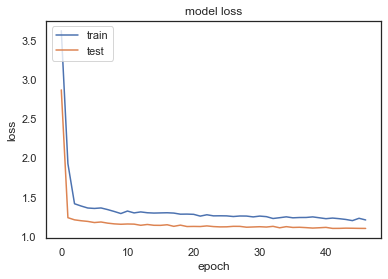

TEST WMSE =  1.3149359637704923
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00043: early stopping
duration: 19.410688877105713


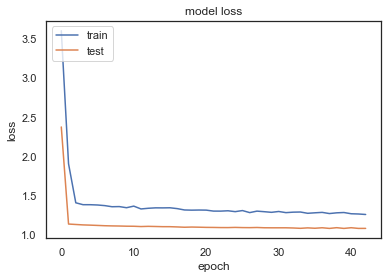

TEST WMSE =  1.1534080478243374
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00039: early stopping
duration: 18.692296028137207


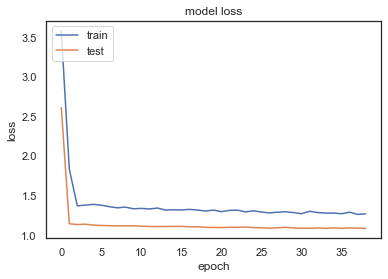

TEST WMSE =  1.1878818253253884
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00037: early stopping
duration: 18.19177770614624


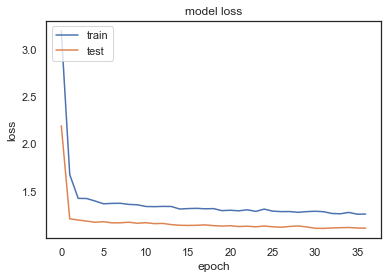

TEST WMSE =  1.2229303634279778
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00031: early stopping
duration: 16.424279928207397


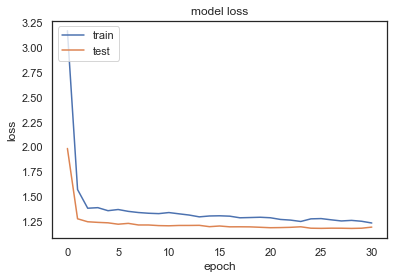

TEST WMSE =  1.2855899929599905
TEST MEAN WMSE =  1.2855899929599905


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 13
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00057: early stopping
duration: 28.08936381340027


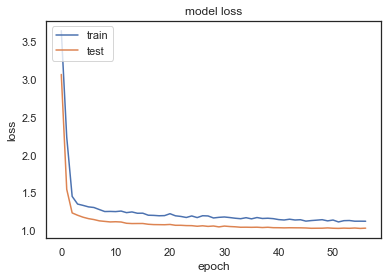

TEST WMSE =  1.2257294889970818
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00051: early stopping
duration: 25.956101894378662


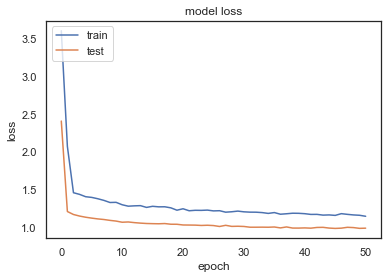

TEST WMSE =  1.0749320213081304
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00073: early stopping
duration: 36.96120882034302


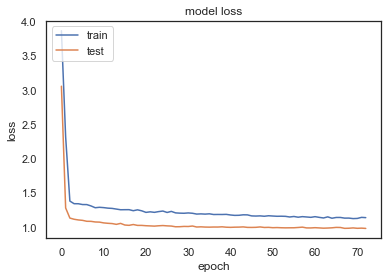

TEST WMSE =  1.0159436414603678
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00058: early stopping
duration: 29.367552042007446


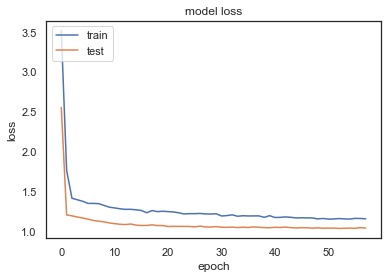

TEST WMSE =  1.1026602817433635
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00066: early stopping
duration: 37.32749009132385


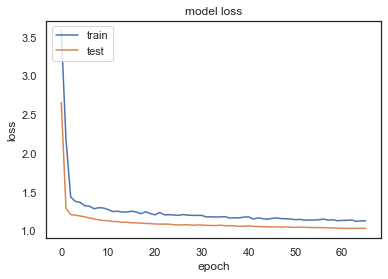

TEST WMSE =  1.1839464697955548
TEST MEAN WMSE =  1.1839464697955548


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 14
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 1) (1248, 6, 1) (4161,) (1248,)
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00034: early stopping
duration: 20.39760708808899


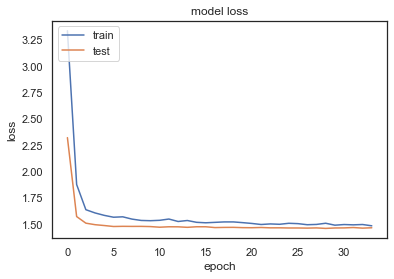

TEST WMSE =  1.6555278066731838
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00017: early stopping
duration: 10.393879890441895


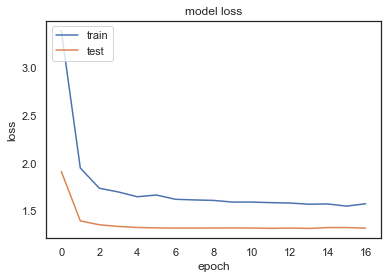

TEST WMSE =  1.458737330712565
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00017: early stopping
duration: 10.411371231079102


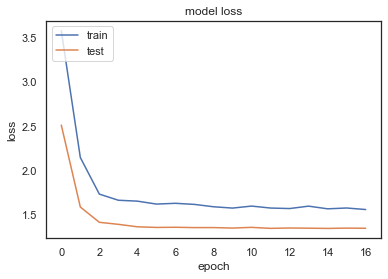

TEST WMSE =  1.4763565663479097
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00025: early stopping
duration: 13.643718004226685


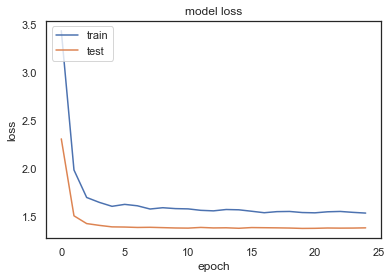

TEST WMSE =  1.4717319959368638
x_val.shape = (357, 6, 1)
y_val.shape = (357,)
x_train.shape = (4756, 6, 1)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00027: early stopping
duration: 14.927885055541992


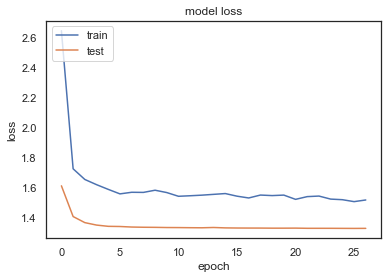

TEST WMSE =  1.552202023190165
TEST MEAN WMSE =  1.552202023190165


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 KEEP FEATURES -- 14
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00042: early stopping
duration: 11.108644723892212


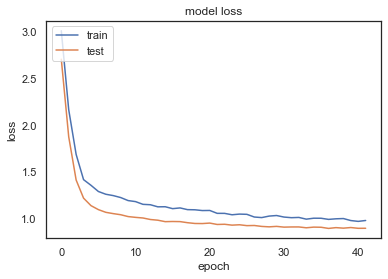

TEST WMSE =  1.008111526666847
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00069: early stopping
duration: 15.788991212844849


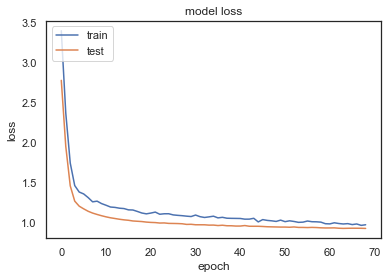

TEST WMSE =  0.8165413149246742
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00075: early stopping
duration: 17.11780095100403


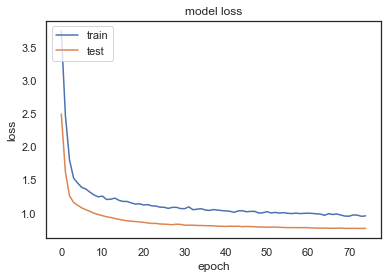

TEST WMSE =  0.861447936875863
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00082: early stopping
duration: 18.21562123298645


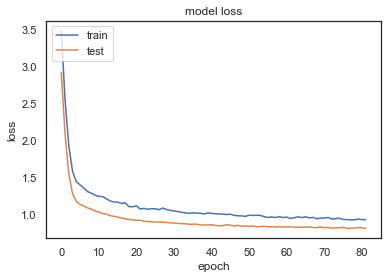

TEST WMSE =  0.8836435148683758
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00057: early stopping
duration: 13.855070352554321


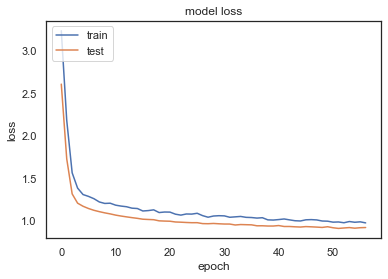

TEST WMSE =  0.9638788130807917
TEST MEAN WMSE =  0.9638788130807917


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


    exper_num  sequenc_len  num_lstm_units   n_epochs  weighted_mse_test  \
0           0          6.0             6.0  11.000000           1.660067   
1           0          6.0             6.0  12.000000           1.453457   
2           0          6.0             6.0  12.000000           1.480351   
3           0          6.0             6.0  14.000000           1.482662   
4           0          6.0             6.0   8.000000           1.548526   
5        mean          6.0             6.0  11.400000           1.525013   
6         std          0.0             0.0   2.179908           0.038123   
7           0          6.0             6.0  12.000000           1.661688   
8           0          6.0             6.0  10.000000           1.456229   
9           0          6.0             6.0  13.000000           1.475907   
10          0          6.0             6.0   9.000000           1.474563   
11          0          6.0             6.0  10.000000           1.553534   
12       mea

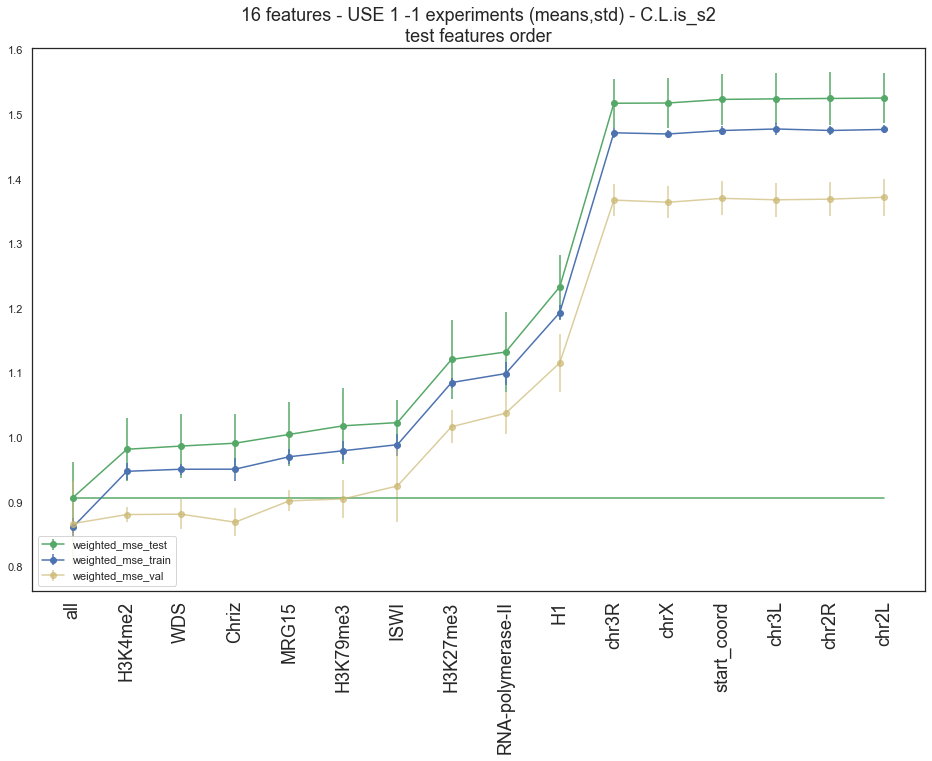

all
H3K4me2
WDS
Chriz
MRG15
H3K79me3
ISWI
H3K27me3
RNA-polymerase-II
H1
chrX
chr3R
start_coord
chr2R
chr2L
chr3L
num_features:  16


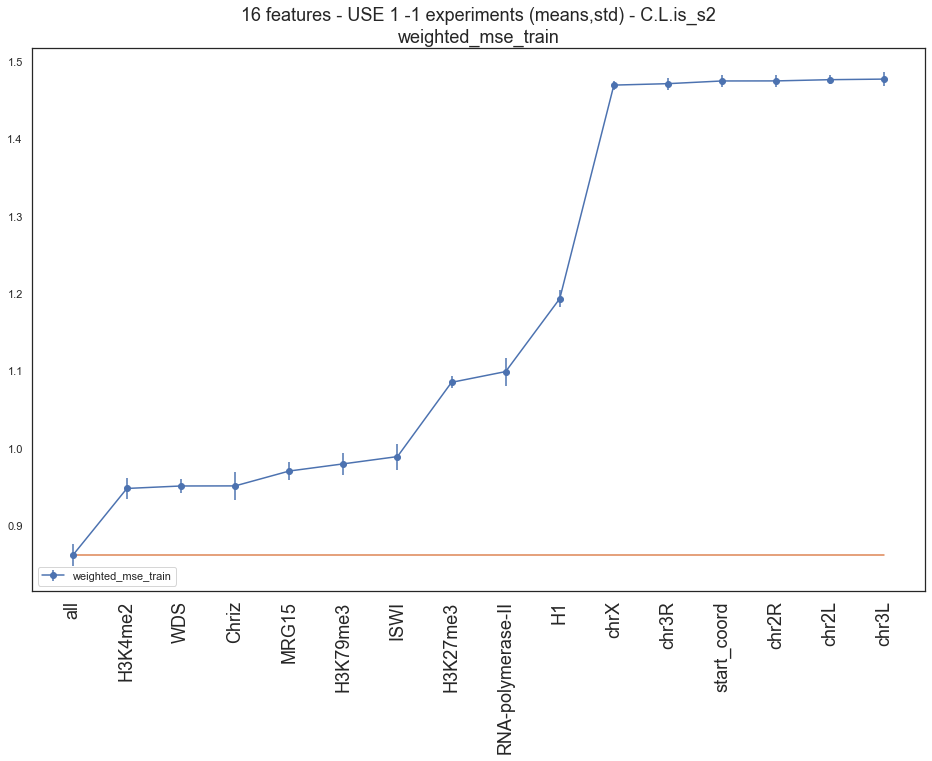

all
H3K4me2
WDS
Chriz
MRG15
H3K79me3
ISWI
H3K27me3
RNA-polymerase-II
H1
chr3R
chrX
start_coord
chr3L
chr2R
chr2L
num_features:  16


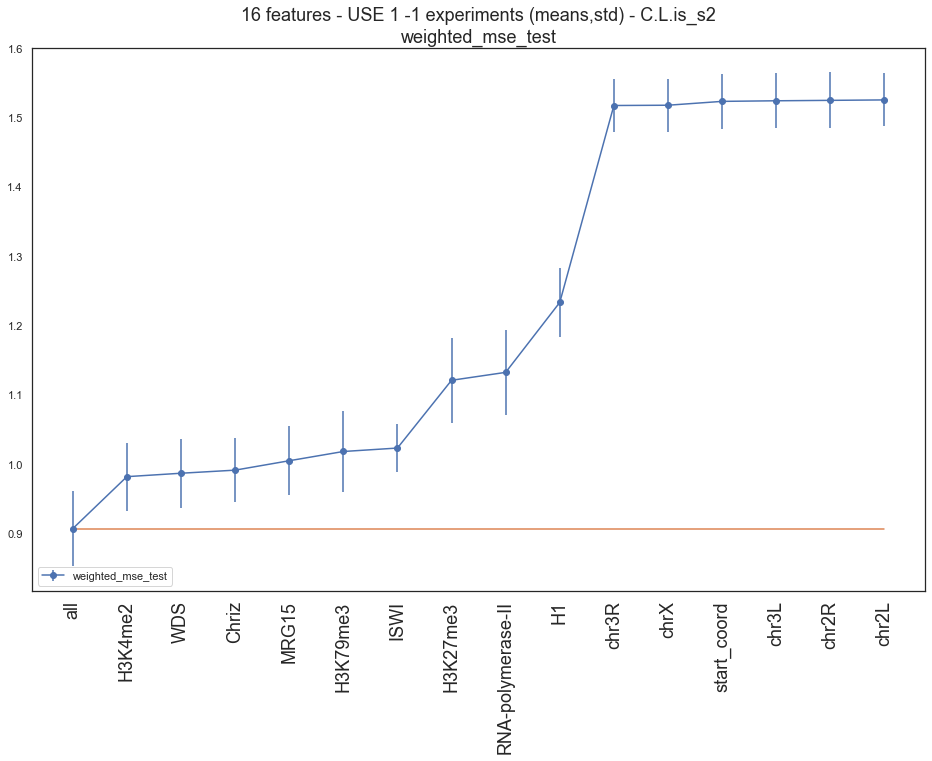

TEST wMSE using 1
all , 0.9067246212833103
H3K4me2 , 0.9816547675939653
WDS , 0.9865786102089847
Chriz , 0.9910368424798
MRG15 , 1.0046006091864583
H3K79me3 , 1.017938164031173
ISWI , 1.0229191701435212
H3K27me3 , 1.1206423806608998
RNA-polymerase-II , 1.132064759977641
H1 , 1.2329492386616372
chr3R , 1.5169566274583057
chrX , 1.5173574728728128
start_coord , 1.5229111445721375
chr3L , 1.5237717452057762
chr2R , 1.5243843156746952
chr2L , 1.5250125737877487

-----
 DROP FEATURE NUMBER -- 0
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00064: early stopping
duration: 32.42726016044617


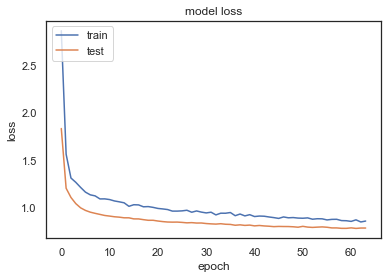

TEST WMSE =  0.9818429815291217
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00038: early stopping
duration: 20.571763038635254


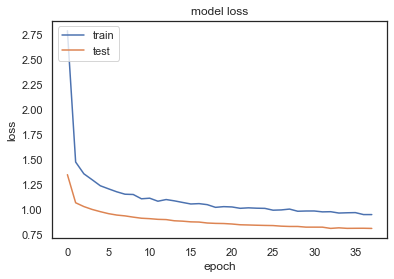

TEST WMSE =  0.8487103202759813
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00039: early stopping
duration: 21.09718084335327


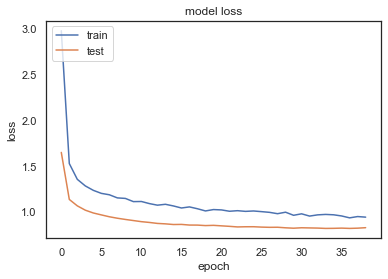

TEST WMSE =  0.836240934613312
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00050: early stopping
duration: 27.923837900161743


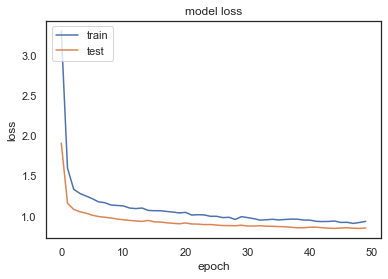

TEST WMSE =  0.8683724111934699
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00036: early stopping
duration: 23.383185148239136


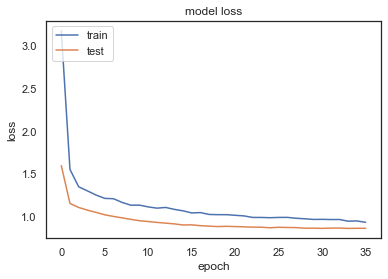

TEST WMSE =  0.9546702197110001
TEST MEAN WMSE =  0.9546702197110001


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 1
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00047: early stopping
duration: 27.77965807914734


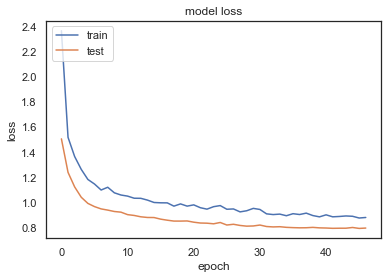

TEST WMSE =  1.0247806154871728
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00079: early stopping
duration: 40.52802801132202


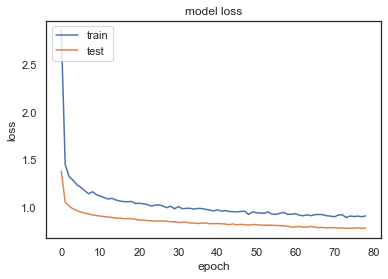

TEST WMSE =  0.8519770221952203
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00038: early stopping
duration: 20.494822025299072


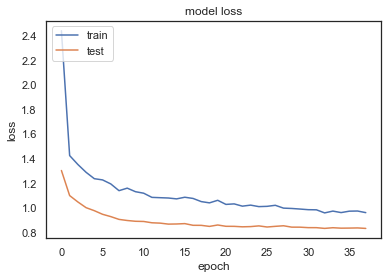

TEST WMSE =  0.8280316515131356
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00080: early stopping
duration: 38.49381923675537


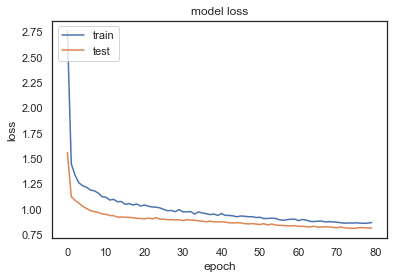

TEST WMSE =  0.8455253774224036
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00055: early stopping
duration: 29.407469987869263


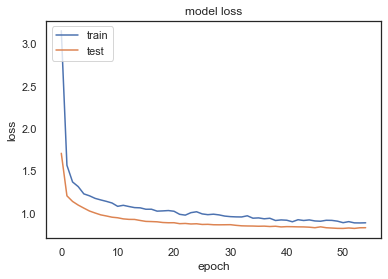

TEST WMSE =  0.9199806074666075
TEST MEAN WMSE =  0.9199806074666075


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 2
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00062: early stopping
duration: 37.15639400482178


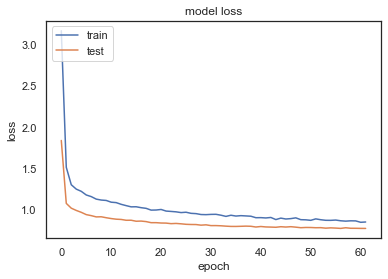

TEST WMSE =  0.9814037400062012
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00074: early stopping
duration: 38.306373834609985


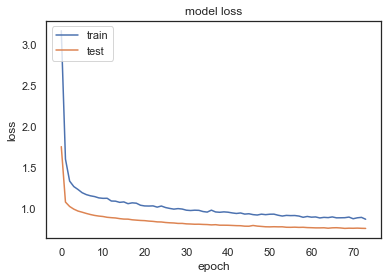

TEST WMSE =  0.839623156474283
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00063: early stopping
duration: 30.01798701286316


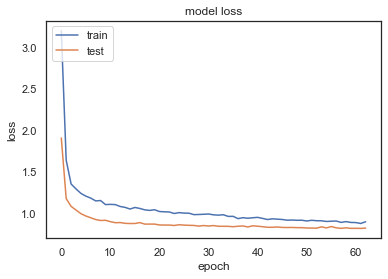

TEST WMSE =  0.8087616889369166
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00039: early stopping
duration: 21.453463077545166


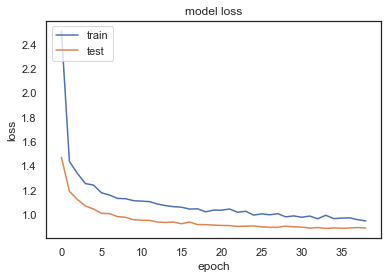

TEST WMSE =  0.8970140953901012
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00063: early stopping
duration: 33.39368009567261


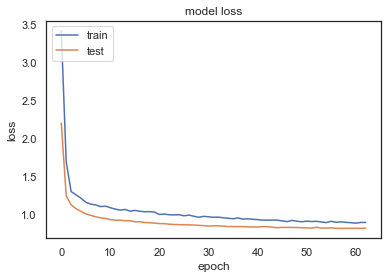

TEST WMSE =  0.9214728905765295
TEST MEAN WMSE =  0.9214728905765295


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 3
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00048: early stopping
duration: 25.662945985794067


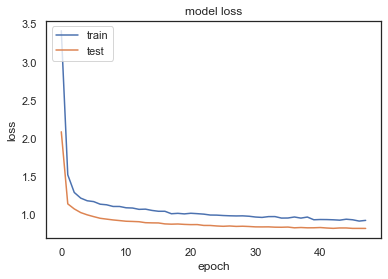

TEST WMSE =  1.056006195437172
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00058: early stopping
duration: 27.369262218475342


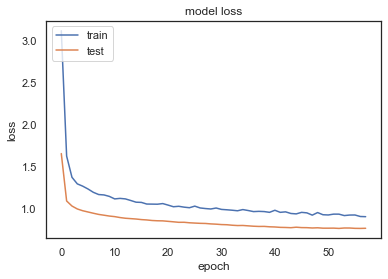

TEST WMSE =  0.82038354518974
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00038: early stopping
duration: 18.885584831237793


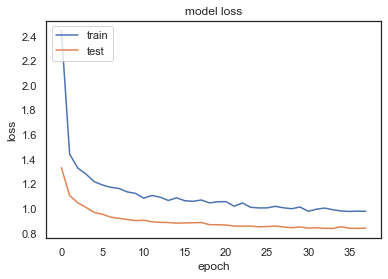

TEST WMSE =  0.8339544367568282
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00037: early stopping
duration: 17.828334093093872


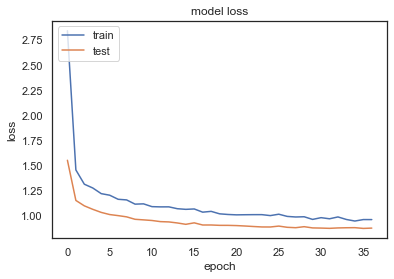

TEST WMSE =  0.8882778425658135
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00048: early stopping
duration: 27.114765882492065


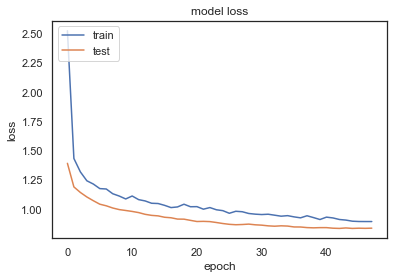

TEST WMSE =  0.9332706654002014
TEST MEAN WMSE =  0.9332706654002014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 4
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00088: early stopping
duration: 41.666019916534424


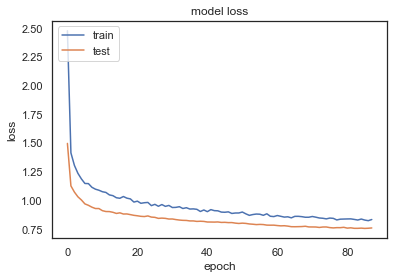

TEST WMSE =  0.9986113033636578
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00064: early stopping
duration: 30.799122095108032


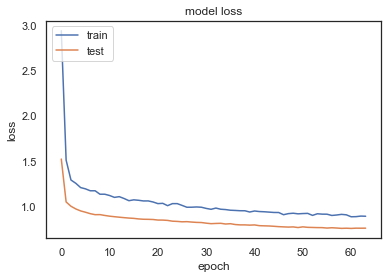

TEST WMSE =  0.8372500591524132
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00042: early stopping
duration: 20.147637844085693


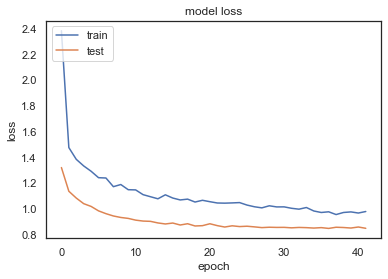

TEST WMSE =  0.8333249018960015
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00083: early stopping
duration: 36.12814784049988


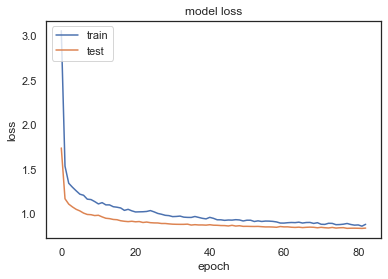

TEST WMSE =  0.8615510691372311
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00055: early stopping
duration: 25.607517957687378


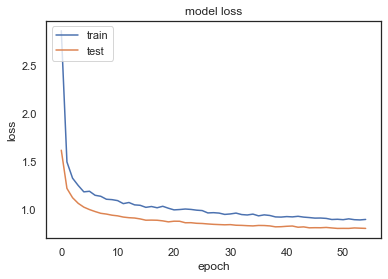

TEST WMSE =  0.9382930426813479
TEST MEAN WMSE =  0.9382930426813479


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 5
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00073: early stopping
duration: 34.93279504776001


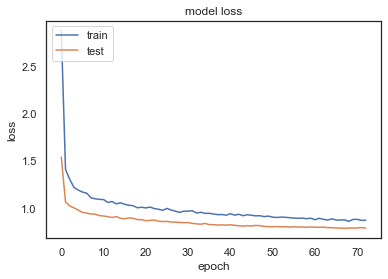

TEST WMSE =  1.0152749794244986
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00056: early stopping
duration: 27.881407976150513


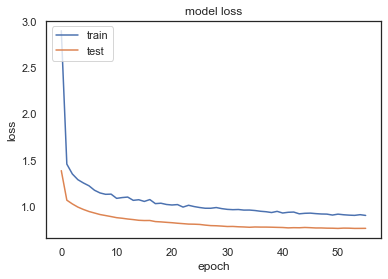

TEST WMSE =  0.8333394584059096
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00059: early stopping
duration: 28.778265237808228


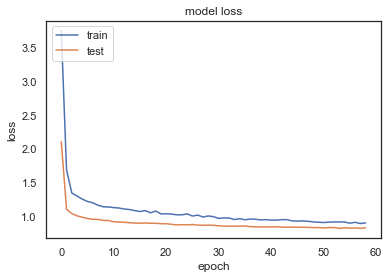

TEST WMSE =  0.8206011061803552
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00082: early stopping
duration: 37.93092179298401


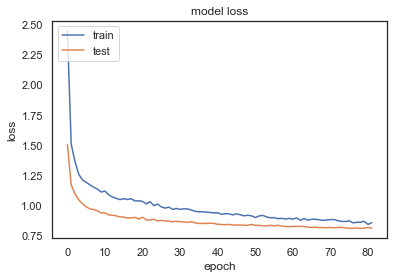

TEST WMSE =  0.8547371981023922
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00067: early stopping
duration: 33.33890414237976


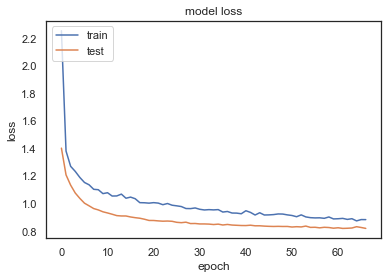

TEST WMSE =  0.9062803082563584
TEST MEAN WMSE =  0.9062803082563584


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 6
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00063: early stopping
duration: 28.412342071533203


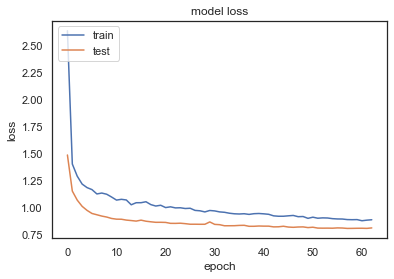

TEST WMSE =  1.0412881414412767
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00068: early stopping
duration: 32.246057987213135


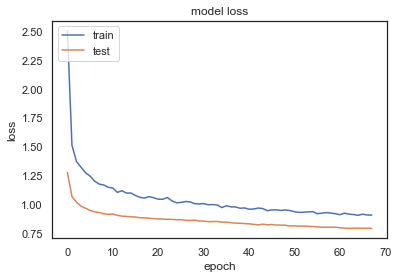

TEST WMSE =  0.8347263401516013
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00052: early stopping
duration: 25.23599600791931


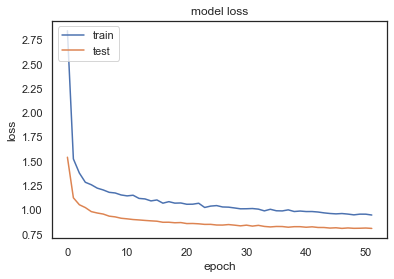

TEST WMSE =  0.8363696577573823
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00058: early stopping
duration: 24.708109140396118


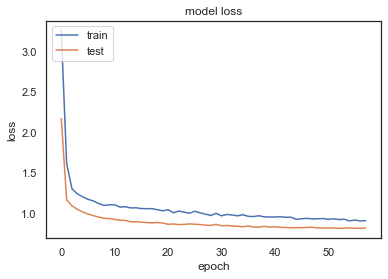

TEST WMSE =  0.8744385327059262
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00059: early stopping
duration: 25.18083381652832


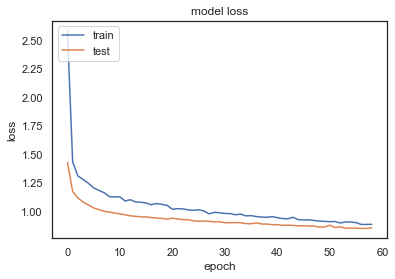

TEST WMSE =  0.937565370418869
TEST MEAN WMSE =  0.937565370418869


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 7
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00070: early stopping
duration: 29.940791130065918


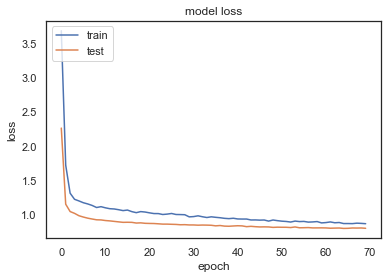

TEST WMSE =  1.0146306674004215
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00070: early stopping
duration: 41.325220823287964


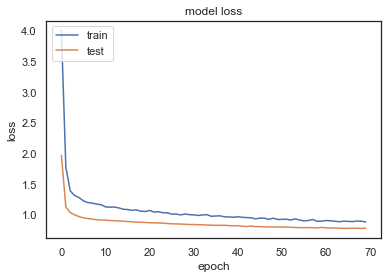

TEST WMSE =  0.8473478090092178
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00046: early stopping
duration: 30.193281888961792


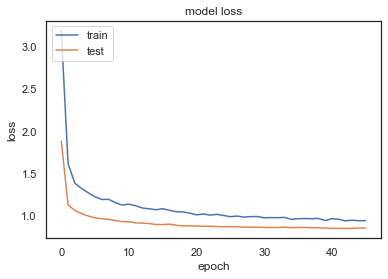

TEST WMSE =  0.8330302940080017
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00050: early stopping
duration: 27.96123695373535


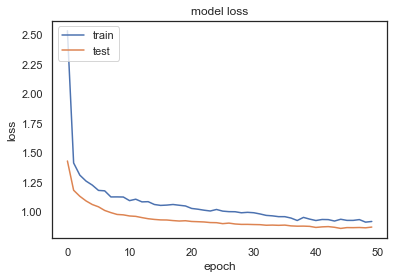

TEST WMSE =  0.8832681109485976
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00036: early stopping
duration: 18.143821001052856


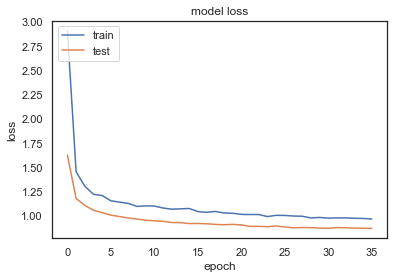

TEST WMSE =  0.9735634716246828
TEST MEAN WMSE =  0.9735634716246828


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 8
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00055: early stopping
duration: 27.50092887878418


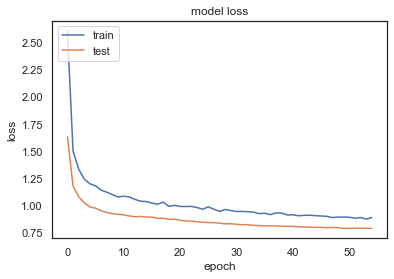

TEST WMSE =  1.0145146850243725
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00048: early stopping
duration: 23.53434109687805


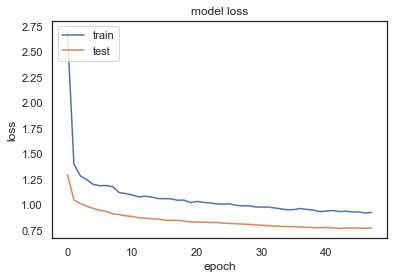

TEST WMSE =  0.8255721405823846
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00067: early stopping
duration: 32.31109094619751


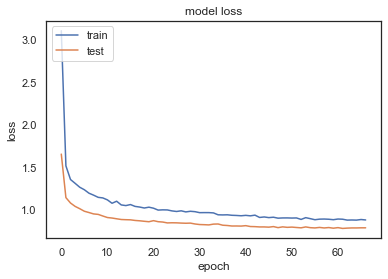

TEST WMSE =  0.803581513194072
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00032: early stopping
duration: 17.310749292373657


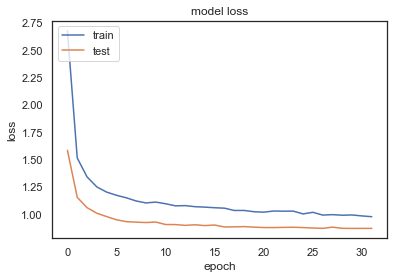

TEST WMSE =  0.8850775587230636
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00033: early stopping
duration: 18.467793941497803


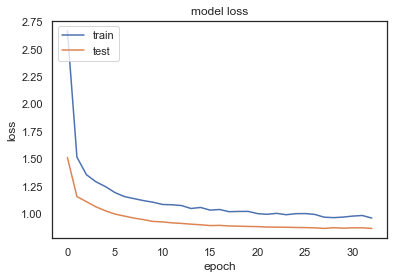

TEST WMSE =  0.9690316607129404
TEST MEAN WMSE =  0.9690316607129404


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 9
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00059: early stopping
duration: 29.97549295425415


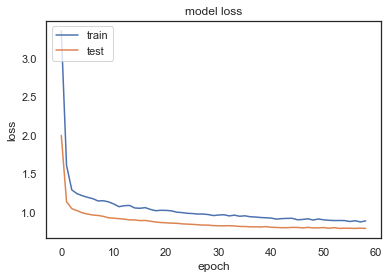

TEST WMSE =  1.0043227309048939
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00064: early stopping
duration: 31.397953033447266


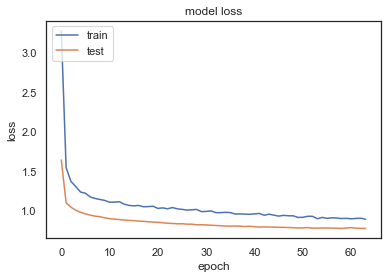

TEST WMSE =  0.8116401579470867
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00051: early stopping
duration: 25.149399995803833


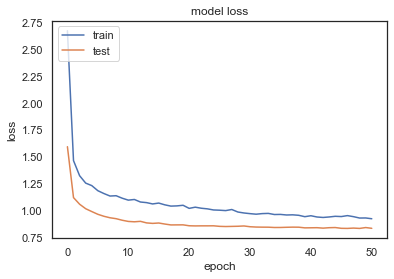

TEST WMSE =  0.8137721855617923
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00053: early stopping
duration: 26.376803159713745


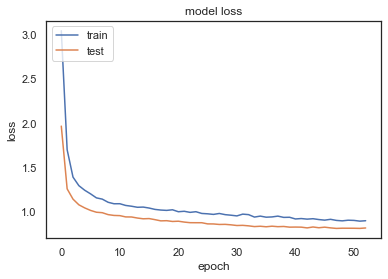

TEST WMSE =  0.8676306513848077
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00056: early stopping
duration: 30.17506694793701


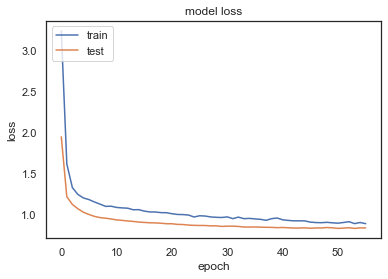

TEST WMSE =  0.9018682310970143
TEST MEAN WMSE =  0.9018682310970143


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 10
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00064: early stopping
duration: 36.56956386566162


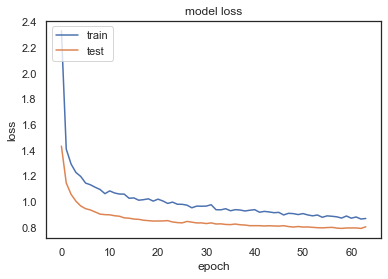

TEST WMSE =  1.0342808280706064
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00071: early stopping
duration: 36.03429698944092


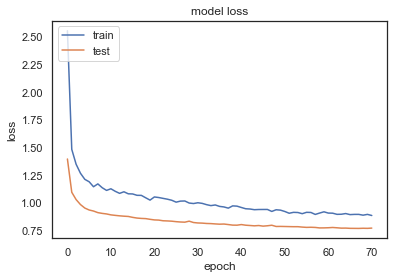

TEST WMSE =  0.8230950084886456
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00032: early stopping
duration: 17.185341119766235


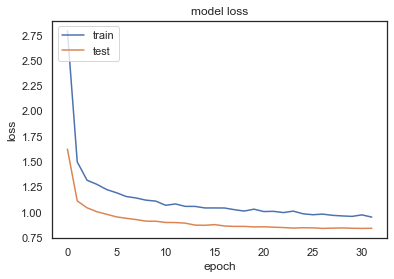

TEST WMSE =  0.8426167197568882
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00039: early stopping
duration: 20.357242107391357


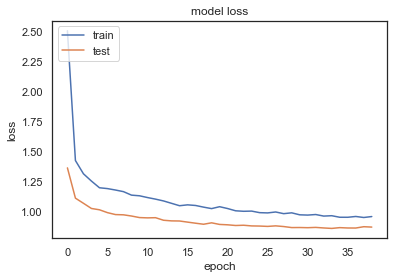

TEST WMSE =  0.8933765963069967
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00049: early stopping
duration: 25.45770764350891


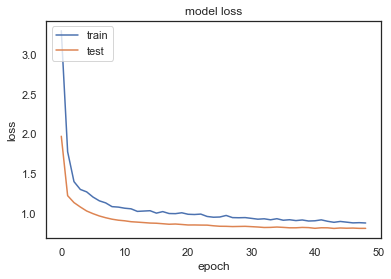

TEST WMSE =  0.9273277420004746
TEST MEAN WMSE =  0.9273277420004746


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 11
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00045: early stopping
duration: 23.752854108810425


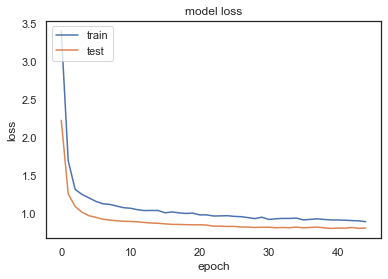

TEST WMSE =  1.0171128330503505
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00069: early stopping
duration: 33.495726108551025


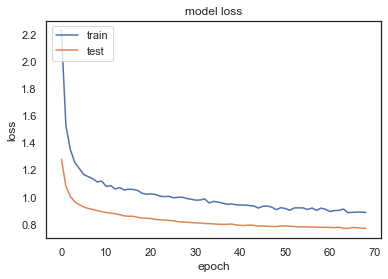

TEST WMSE =  0.8432243052864926
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00057: early stopping
duration: 29.297138929367065


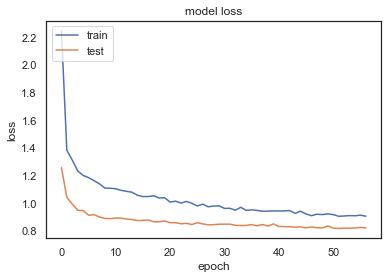

TEST WMSE =  0.8184998370074509
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00071: early stopping
duration: 34.83955216407776


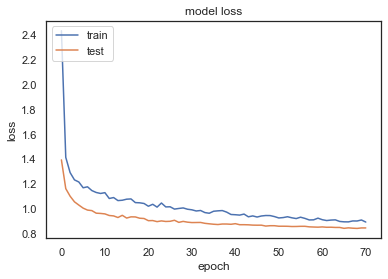

TEST WMSE =  0.8656429115054298
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00042: early stopping
duration: 22.219552040100098


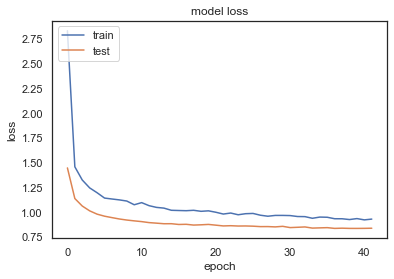

TEST WMSE =  0.9680413086484443
TEST MEAN WMSE =  0.9680413086484443


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 12
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00048: early stopping
duration: 24.17204189300537


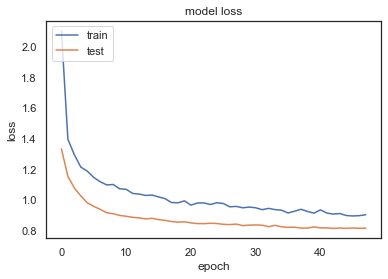

TEST WMSE =  1.0400234449213213
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00042: early stopping
duration: 21.682472229003906


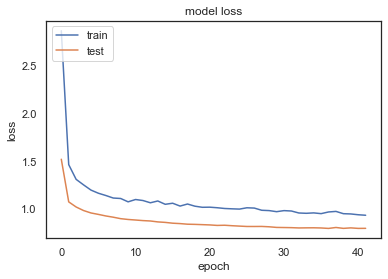

TEST WMSE =  0.8464655851651144
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00036: early stopping
duration: 19.563172817230225


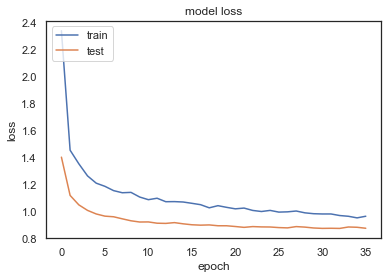

TEST WMSE =  0.8366388999015903
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00029: early stopping
duration: 15.270745992660522


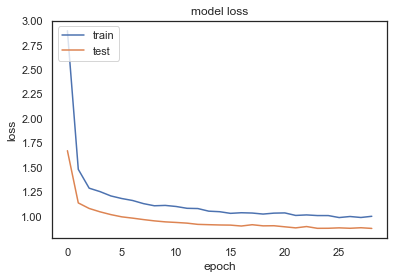

TEST WMSE =  0.8830063945711563
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00039: early stopping
duration: 19.894974946975708


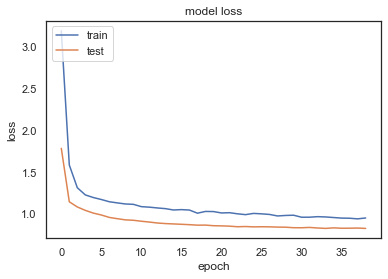

TEST WMSE =  0.9469454623538858
TEST MEAN WMSE =  0.9469454623538858


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 13
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00053: early stopping
duration: 24.85679578781128


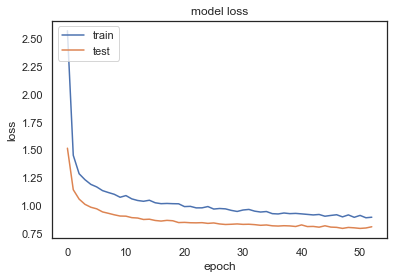

TEST WMSE =  1.0429929036268393
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00082: early stopping
duration: 33.53437900543213


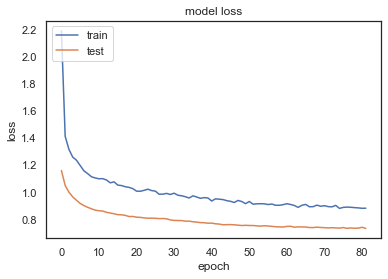

TEST WMSE =  0.8474022258040126
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00051: early stopping
duration: 22.86417293548584


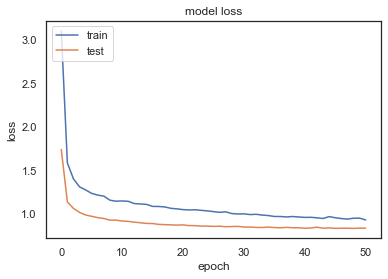

TEST WMSE =  0.8183787880496207
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00037: early stopping
duration: 17.277733087539673


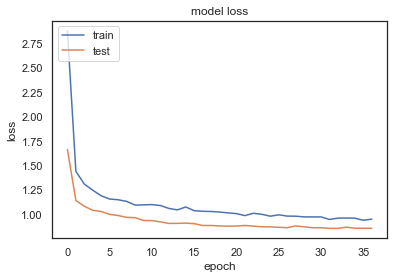

TEST WMSE =  0.885819319905157
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00074: early stopping
duration: 30.88310480117798


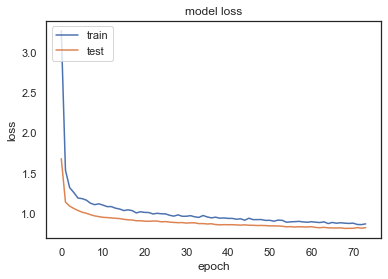

TEST WMSE =  0.9121637441283177
TEST MEAN WMSE =  0.9121637441283177


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 DROP FEATURE NUMBER -- 14
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00061: early stopping
duration: 25.470157146453857


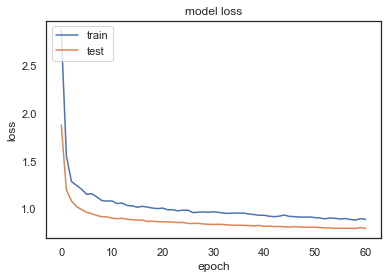

TEST WMSE =  1.0137023734320587
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00057: early stopping
duration: 24.70128583908081


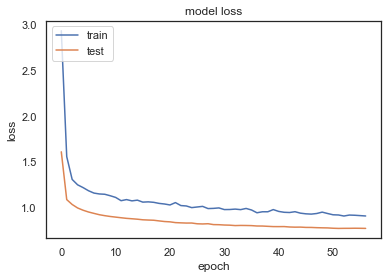

TEST WMSE =  0.8516342587228203
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00049: early stopping
duration: 21.55947780609131


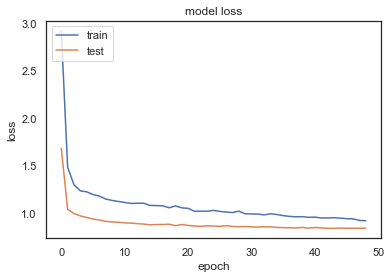

TEST WMSE =  0.8280349291340525
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00073: early stopping
duration: 32.06357192993164


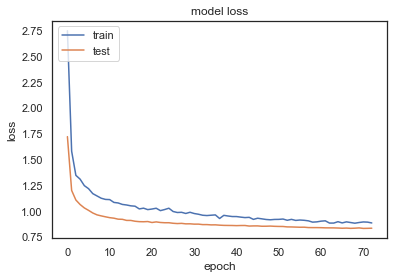

TEST WMSE =  0.869304699786282
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00066: early stopping
duration: 30.073421001434326


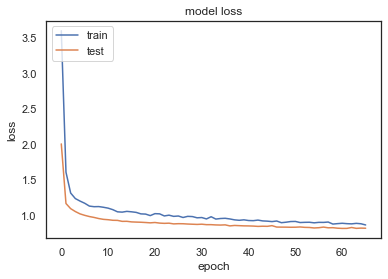

TEST WMSE =  0.9370146093902872
TEST MEAN WMSE =  0.9370146093902872


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----
 KEEP FEATURES -- 14
-----

X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00056: early stopping
duration: 11.92466402053833


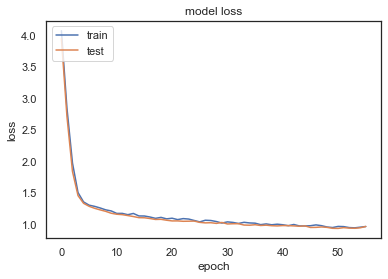

TEST WMSE =  0.9725414821323844
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00091: early stopping
duration: 17.58828616142273


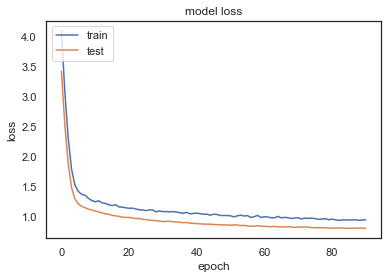

TEST WMSE =  0.8222738127043652
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00073: early stopping
duration: 14.423312902450562


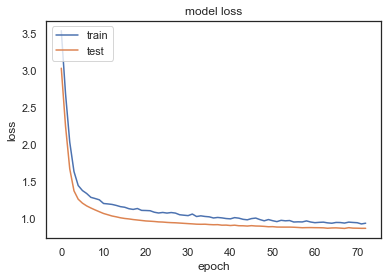

TEST WMSE =  0.7923482692849135
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00084: early stopping
duration: 16.25183892250061


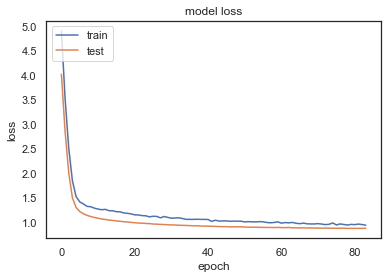

TEST WMSE =  0.8690470651505915
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00111: early stopping
duration: 20.666509866714478


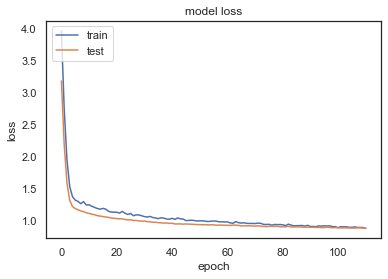

TEST WMSE =  0.8734449468588482
TEST MEAN WMSE =  0.8734449468588482


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


    exper_num  sequenc_len  num_lstm_units    n_epochs  weighted_mse_test  \
0           0          6.0             6.0   64.000000           0.981843   
1           0          6.0             6.0   38.000000           0.848710   
2           0          6.0             6.0   39.000000           0.836241   
3           0          6.0             6.0   50.000000           0.868372   
4           0          6.0             6.0   36.000000           0.954670   
5        mean          6.0             6.0   45.400000           0.897967   
6         std          0.0             0.0    5.831981           0.047224   
7           0          6.0             6.0   47.000000           1.024781   
8           0          6.0             6.0   79.000000           0.851977   
9           0          6.0             6.0   38.000000           0.828032   
10          0          6.0             6.0   80.000000           0.845525   
11          0          6.0             6.0   55.000000           0.919981   

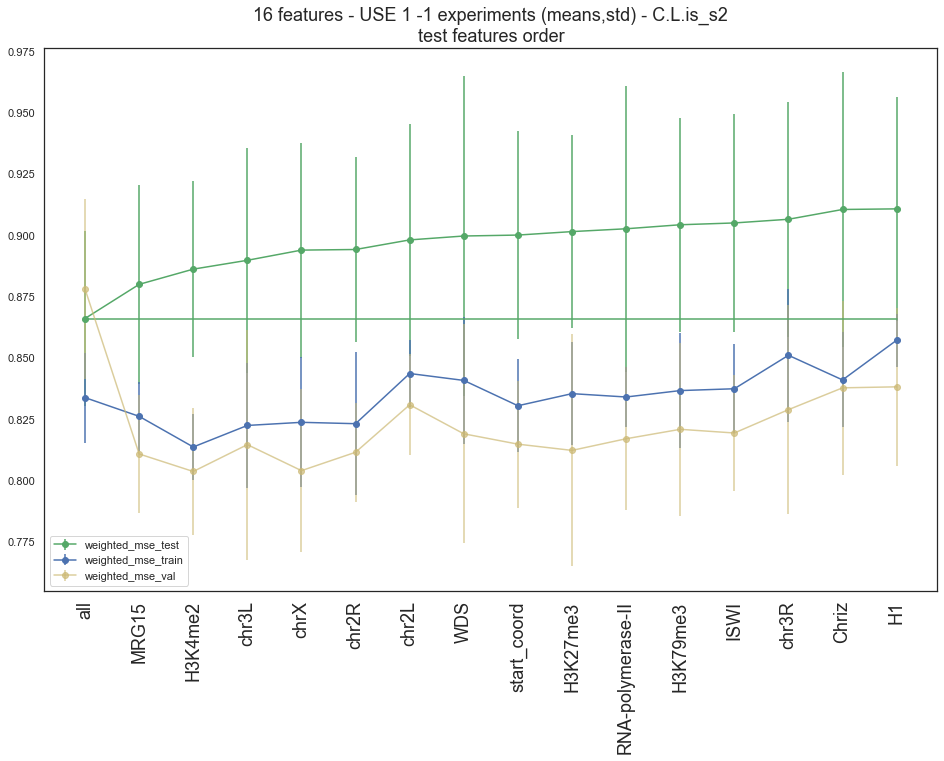

H3K4me2
chr3L
chr2R
chrX
MRG15
start_coord
all
RNA-polymerase-II
H3K27me3
H3K79me3
ISWI
WDS
Chriz
chr2L
chr3R
H1
num_features:  16


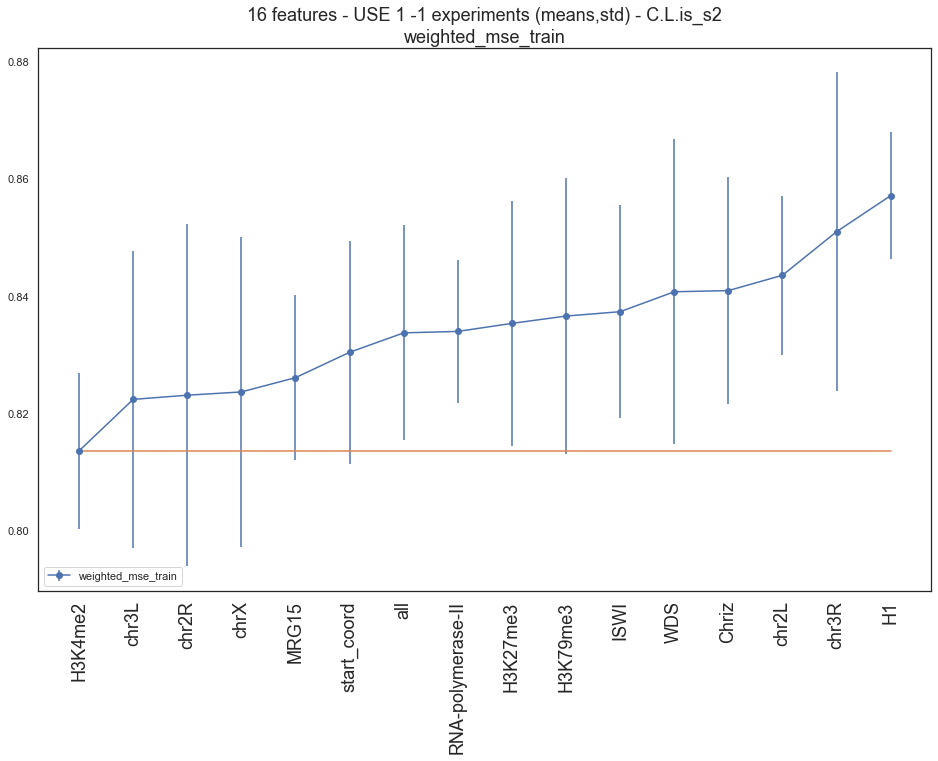

all
MRG15
H3K4me2
chr3L
chrX
chr2R
chr2L
WDS
start_coord
H3K27me3
RNA-polymerase-II
H3K79me3
ISWI
chr3R
Chriz
H1
num_features:  16


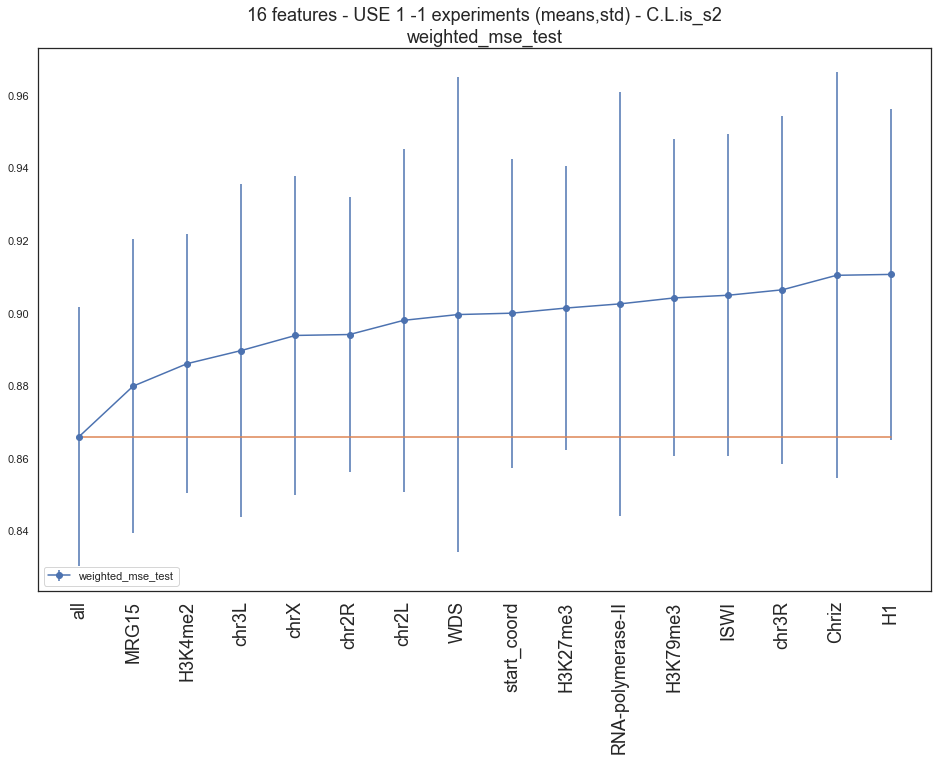

TEST wMSE using 1
all , 0.8659311152262206
MRG15 , 0.8798467913791189
H3K4me2 , 0.8860466100739028
chr3L , 0.8896551142768063
chrX , 0.8938060752461302
chr2R , 0.8940590548169081
chr2L , 0.897967373464577
WDS , 0.8995555116473666
start_coord , 0.8999381740931002
H3K27me3 , 0.9013513963027895
RNA-polymerase-II , 0.9025042390996336
H3K79me3 , 0.9041393789247223
ISWI , 0.9048776084950111
chr3R , 0.906378537069951
Chriz , 0.9103680705981845
H1 , 0.9106159573826137
X_train.shape, X_test.shape, y_train.shape, y_test.shape = (4161, 6, 15) (1248, 6, 15) (4161,) (1248,)
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00054: early stopping
duration: 24.463202953338623


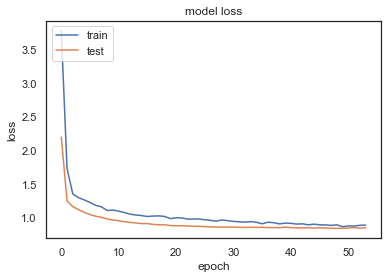

TEST WMSE =  0.9774959755737501
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00033: early stopping
duration: 15.748439073562622


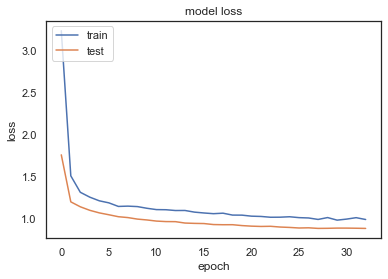

TEST WMSE =  0.8478612210608929
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00060: early stopping
duration: 27.126292943954468


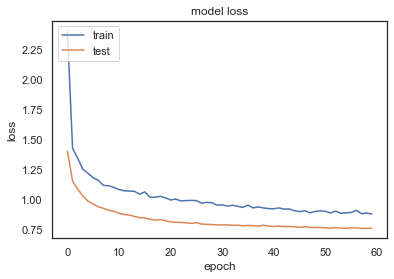

TEST WMSE =  0.8234450731135972
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00066: early stopping
duration: 29.7569420337677


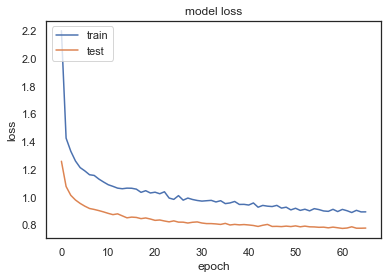

TEST WMSE =  0.8912575700141768
x_val.shape = (357, 6, 15)
y_val.shape = (357,)
x_train.shape = (4756, 6, 15)
y_train.shape = (4756,)
min_delta =  0.001 patience =  5
Train... with 
Epoch 00073: early stopping
duration: 30.153145790100098


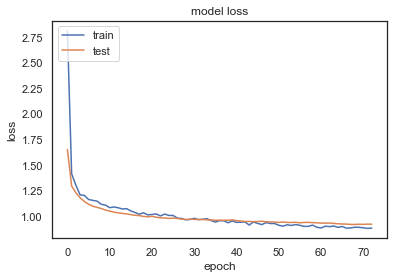

TEST WMSE =  0.8820163555920815
TEST MEAN WMSE =  0.8820163555920815


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
data_csv = "_example_results_18_bioset_10_exps_23_04_20.csv"

num_experements = 1

cell_line = 'is_s2' #  'all' #  'is_bg' # 'all' # 'is_s2' # cell_line one of: 'is_s2', 'is_kc', 'is_bg',  or 'all'

bioset = None  # bioset: defines the biological features to use. 
               #  If bioset is None, use all availible features
bioset = [ 
    'H3K4me2', 
    'ISWI',
    'Chriz',
    'WDS', 
    'MRG15',
    'H3K79me3', 
    'RNA-polymerase-II',
    'H1', 
    'H3K27me3',
    'is_s2', 'is_kc', 'is_bg', 
    'chrN', 
    'start_coord',
  ]


data_path_18features = '../../data/epigenetics/s2_kc_bg_scaled_18_features.csv'
data_path_35features = '../../data/epigenetics/s2_kc_bg_scaled_34_overlap_features_2901.csv'
data_path = data_path_35features


target_path = "../../data/target/s2_kc_bg_clean_gamma_2901.csv"  # "../data/epigenetics/s2_kc_bg_clean_gamma.csv"
index_col = 0
random_state = 16 # None  # Shuffle the data splittings
batch_size = 60 
sequenc_len_list =  [6]
num_lstm_units = 64 
n_epochs_max = 364 
num_folds = 5
file_path = "../exps" + data_csv
use_chr_onehotenc = True
use_coord_scale = True

do_only_1_feature_exps = True 
do_drop_1_feature_exps = True

eval_models_df_1_10x_5f, eval_models_df_drop_10x_5f, eval_models_df_together_10x_5f, \
            mean_together_10x_5f, std_together_10x_5f, feature_score_1, feature_score_drop, \
            data_scaled_clean, target_clean, = main_analysis(data_path,  
                                                       cell_line, 
                                                       bioset, 
                                                       num_experements,
                                                       sequenc_len_list = [6], 
                                                       num_lstm_units = 6,
                                                       num_folds = num_folds,
                                                       batch_size = batch_size,
                                                       do_only_1_feature_exps = do_only_1_feature_exps, 
                                                       do_drop_1_feature_exps = do_drop_1_feature_exps,
                                                       do_all_together = True,
                                                       use_chr_onehotenc = use_chr_onehotenc,
                                                       use_coord_scale=use_coord_scale,
                                                       verbose=True)


In [27]:
eval_models_df_together_10x_5f

exper_num  sequenc_len  num_lstm_units   n_epochs  weighted_mse_test  \
0         0          6.0             6.0  54.000000           0.977496   
1         0          6.0             6.0  33.000000           0.847861   
2         0          6.0             6.0  60.000000           0.823445   
3         0          6.0             6.0  66.000000           0.891258   
4         0          6.0             6.0  73.000000           0.882016   
5      mean          6.0             6.0  57.200000           0.884415   
6       std          0.0             0.0  15.153481           0.029040   

   weighted_mse_train  weighted_mse_val  weighted_mse_test_const  batch_size  \
0            0.803833          0.854980                 1.654079        60.0   
1            0.888689          0.877758                 1.613542        60.0   
2            0.810757          0.759329                 1.630521        60.0   
3            0.822202          0.778491                 1.671273        60.0   
4            0.815993          0.925336                 1.651430        60.0   
5            0.828295          0.839179                 1.644169        60.0   
6            0.031717          0.068776                 0.021749         0.0   

    duration  missing_feature  
0  24.463203             -1.0  
1  15.748439             -1.0  
2  27.126293             -1.0  
3  29.756942             -1.0  
4  30.153146             -1.0  
5  25.449605             -1.0  
6   5.861010              0.0